In [106]:
import pickle
import torch
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
import os
import numpy as np
import sys
import pandas as pd 
sys.path.append("../../../..")
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
from datasets.morpho_mnist.dataset import ImageDataset, MetadataDataset, TripletDataset
from auto_localization.models.BasicVAE import BasicVAE
from auto_localization.experiment_management.basic_experiment import BasicExperiment
from auto_localization.experiment_management.hyperparameter_experiment import HyperparameterExperiment
from auto_localization.dataset_management.data_manager import DataManager
from auto_localization.plotting.localization import save_localization_metadata_distance_plots
from auto_localization.oracles.metadata_oracle import MetadataOracle
from auto_localization.oracles.indexed_metadata_oracle import IndexedMetadataOracle
from auto_localization.training.training_test import reconstruction_of_metadata
from datasets.morpho_mnist.measure import measure_image
from auto_localization.localization.localization_experiment_manager import LocalizationExperimentManager
from auto_localization.plotting.localization import embedding_with_posterior_path, embedding_with_planes
import auto_localization.plotting.localization as localization_plotting
import auto_localization.plotting.image_sampling as image_sampling

### High Level Description
This Jupyter Notebook is being used to create a qualitative plot of two 2D MorphoMNIST embeddings, one with and one without triplets.

### Utility Functions

In [2]:
def setup_data_manager(config):
    which_digits = config["dataset_config"]["which_digits"]
    component_weighting = config["dataset_config"]["component_weighting"]
    one_two_ratio = config["dataset_config"]["one_two_ratio"]
    metadata_dataset = MetadataDataset(train=False, which_digits=which_digits, apply_transform=False)
    localization_oracle = MetadataOracle(metadata_dataset=metadata_dataset, component_weighting=component_weighting)
    triplet_train_dataset = TripletDataset(train=True, which_digits=which_digits, oracle=localization_oracle, one_two_ratio=one_two_ratio)
    triplet_test_dataset = TripletDataset(train=False, which_digits=which_digits, oracle=localization_oracle, one_two_ratio=one_two_ratio)
    image_train_dataset = ImageDataset(train=True, which_digits=which_digits)
    image_test_dataset = ImageDataset(train=False, which_digits=which_digits)
    data_manager = DataManager((image_train_dataset, image_test_dataset), (triplet_train_dataset, triplet_train_dataset))
    
    return data_manager

In [3]:
"""
    Function that loads a model from a given path.
"""
def load_model_and_config(model_dir):
    # load params from model_dir
    with open(model_dir+"/params.pkl", "rb") as f:
        config = pickle.load(f)
        print("Config object:")
        print(config)
    # load model
    model_path = model_dir+"/model.pkl"
    z_dim = config["model_config"]["latent_dim"]
    in_shape = config["model_config"]["in_shape"]
    d = config["model_config"]["d"]
    layer_count = config["model_config"]["layer_count"]
    channels = config["model_config"]["channels"]
    model = BasicVAE(z_dim = z_dim, in_shape = in_shape, d = d, layer_count=layer_count, channels=channels)
    #model = BasicVAE(z_dim = z_dim, in_shape = in_shape, d = d, layer_count=layer_count, channels=channels, loss_name="GlobalMaskVAETripletLoss")
    model.load_state_dict(torch.load(model_path))
    model.to("cuda")
    model.eval()
        
    return model, config

In [4]:
"""
    This function takes a model and data manager. It makes sure the model has a 2D embedding.
    The model takes in a sample of images through the data manager. The metadata characteristics
    of each of the images are measured as well.
    
    return (images, embedding_locations, morpho_mnist_metadata)
"""
def sample_embedding(model, data_manager, num_samples=500):
    # get a random sample of images from the test_images
    test_images = data_manager.image_test[0:num_samples]
    test_images = test_images.permute(1, 0, 2, 3)
    # run a forward pass on those images
    mean, logvar, encoded_vector, reconstructed = model.forward(test_images.cuda())
    embedding_locations = mean.detach().cpu().numpy()
    # get the metadata characteristics of them
    test_images = test_images.squeeze()
    morpho_mnist_metadata = data_manager.triplet_train.metadata_dataset.measure_images(test_images)
    # package them up and return
    return (test_images, embedding_locations, morpho_mnist_metadata)

In [5]:
"""
    function takes in a set of embedding_locations, morpho_mnist_metadata, and a feature inex
    and figures out which line in the embedding locations space has the best 
"""
def line_with_best_ordering(embedding_locations, morpho_mnist_metadata, feature_index, num_lines=1000):
    # generate a list of 'num_lines' unit vectors sampled from an n-d Gaussian 
    dimensionality = np.shape(embedding_locations)[-1]
    gaussian_random_vectors = np.random.normal(size=(num_lines, dimensionality))
    unit_vectors = gaussian_random_vectors / np.linalg.norm(gaussian_random_vectors, axis=1)[:, None]
    # depracated 2D variant 
    # thetas = np.linspace(0.0, 2*np.pi, num=num_lines)
    # x_vals = np.cos(thetas)
    # y_vals = np.sin(thetas)
    # unit_vectors = np.stack((x_vals, y_vals)).T
    # these vectors will be centered at the mean of a distribution
    mean = np.mean(embedding_locations, axis=0)
    embedding_locations = embedding_locations - mean
    morpho_mnist_metadata = np.array(morpho_mnist_metadata)
    # go thorugh each unit vector
    spearmans = []
    for unit_vector in unit_vectors:
        # project the embedding points down to this line and order them
        overlap_with = np.dot(embedding_locations, unit_vector[:, None])
        # find the spearman rank coefficient of each of the lines
        spearman = stats.spearmanr(overlap_with, morpho_mnist_metadata[:, feature_index])
        spearmans.append(spearman[0])
    spearmans = np.abs(spearmans)
    # return the best line
    best_index = np.argmax(spearmans)
    return unit_vectors[best_index], spearmans[best_index]


### Plotting Functions


In [6]:
"""
    Plots a 2D colored feature embedding based on the intensity of the metadata
    feature with feature_index
"""
def plot_feature_embedding(embedding_locations, morpho_mnist_metadata, feature_index=0, title=""):
    feature_names = ["area", "length", "thickness", "slant", "width", "height"]
    # normalize metadata
    original_morpho_mnist_metadata = np.array(morpho_mnist_metadata)
    morpho_mnist_metadata = original_morpho_mnist_metadata[:, feature_index]
    normalized_metadata = (morpho_mnist_metadata - np.min(morpho_mnist_metadata))/(np.max(morpho_mnist_metadata) - np.min(morpho_mnist_metadata))
    # get line with best spearman correlation
    spearman_direction, spearman = line_with_best_ordering(embedding_locations, original_morpho_mnist_metadata, feature_index)
    # get cmap and colors
    fig = plt.figure(figsize=(6, 5), dpi=500)
    plt.scatter(embedding_locations[:, 0], embedding_locations[:, 1], c=normalized_metadata, s=5, cmap="plasma")
    plt.xticks([])
    plt.title(title)
    plt.yticks([])
    plt.xlabel("Latent Dim 1")
    plt.ylabel("Latent Dim 2")
    cbar = plt.colorbar()#matplotlib.cm.ScalarMappable(norm=None, cmap=cmap), pad=0.1)
    cbar.set_label(f"'{feature_names[feature_index]}' Level")
    # plot line with best ordering
    mean = np.mean(embedding_locations, axis=0)
    vector_scale = 3.0
    if not spearman_direction is None:
        quiver = plt.quiver(mean[0], mean[1], spearman_direction[0], spearman_direction[1], scale=vector_scale, angles="xy", zorder=5, pivot="tail")
    # make arrow in legend
    def make_legend_arrow(legend, orig_handle,
                          xdescent, ydescent,
                          width, height, fontsize):
        p = mpatches.FancyArrow(0, 0.5*height, width, 0, length_includes_head=True, head_width=0.75*height )
        return p

    black_circle = Line2D([0], [0], color='black', label='Circle',
                        markerfacecolor='r', markersize=2),
    arrow = plt.arrow(0, 0, 0, 0, label='My label', color='black')
    legend = plt.legend([arrow, black_circle], 
                        ['Best Ordered Axis', "Spearman's = {:.3f}".format(spearman)],
                        handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow)},
                        bbox_to_anchor=(0.39, 0., 0.2, 0.5))
    
    second = legend.get_texts()[1]
    #second.set_ha('right') # ha is alias for horizontalalignment
    second.set_position((3.00,0))
    plt.show() 

In [7]:
"""
    Plots a 2D image sampling
"""
def plot_image_sampling():
    pass

### Plotting posterior mean

In [8]:
# load up a basic 2D triplet model
model_dir = "../../../logs/leafy-frog-7552"
print(os.listdir(model_dir))
feature_index = 2 # thickness
model, config = load_model_and_config(model_dir)
data_manager = setup_data_manager(config)

['model.pkl', 'params.pkl', 'localizers.pkl', 'localizer_metrics.pkl', 'loss.pkl']
Config object:
{'trials': 1, 'epochs': 50, 'lr': 0.001, 'batch_size': 512, 'trainer': 'triplet', 'group': 'thickness_slant_localization_0', 'localization_config': {'indexed': False, 'trials': 10, 'k': 1.0, 'localizer_type': ['Random', 'MCMV'], 'num_queries': 20, 'similarity_mode': False}, 'model_config': {'model_type': 'BasicVAE', 'latent_dim': 2, 'in_shape': 32, 'd': 32, 'layer_count': 4, 'channels': 1, 'loss_name': 'VAETripletLoss', 'kl_beta': 0.01, 'triplet_beta': 1.0, 'triplet_margin': 1.0, 'warm_start': 30, 'kl_max': 0.01, 'triplet_mining': False}, 'dataset_config': {'dataset_name': 'MorphoMNIST', 'component_weighting': [0.0, 0.0, 1.0, 1.0, 0.0, 0.0], 'localization_component_weighting': [0.0, 0.0, 1.0, 1.0, 0.0, 0.0], 'which_digits': [1], 'one_two_ratio': 0.0, 'batch_size': 512}}


In [9]:
print(os.listdir(model_dir))
with open(model_dir+"/localizers.pkl", "rb") as f:
    localizers = pickle.load(f)
    
with open(model_dir+"/localizer_metrics.pkl", "rb") as f:
    localizer_metrics = pickle.load(f)

['model.pkl', 'params.pkl', 'localizers.pkl', 'localizer_metrics.pkl', 'loss.pkl']


In [10]:
localizer_0 = localizers[17]
print(localizer_0.vars)

[array([[ 2.99623654, -0.33975792],
       [-0.33975792,  4.38263475]]), array([[2.66291699, 0.34170981],
       [0.34170981, 1.97059941]]), array([[ 1.47785127, -0.17277921],
       [-0.17277921,  1.78711324]]), array([[ 1.52952161, -0.12446176],
       [-0.12446176,  1.5232549 ]]), array([[0.70915754, 0.33581409],
       [0.33581409, 0.25314371]]), array([[0.70443692, 0.32796836],
       [0.32796836, 0.24706455]]), array([[0.63010183, 0.27861035],
       [0.27861035, 0.20786773]]), array([[0.59783339, 0.25785518],
       [0.25785518, 0.19892661]]), array([[0.4886989 , 0.24002944],
       [0.24002944, 0.19620843]]), array([[0.40152518, 0.19851601],
       [0.19851601, 0.17982087]]), array([[0.42327867, 0.20532174],
       [0.20532174, 0.17184305]]), array([[0.47975329, 0.22660664],
       [0.22660664, 0.18075228]]), array([[0.46652793, 0.23353826],
       [0.23353826, 0.19236223]]), array([[0.4300073 , 0.20417145],
       [0.20417145, 0.17092284]]), array([[0.43246257, 0.19819956],
  

plot posterior path


../../../../auto_localization/plotting/util.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Error: You must call wandb.init() before wandb.log()

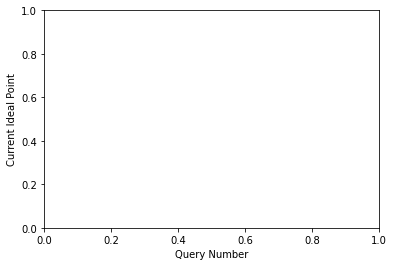

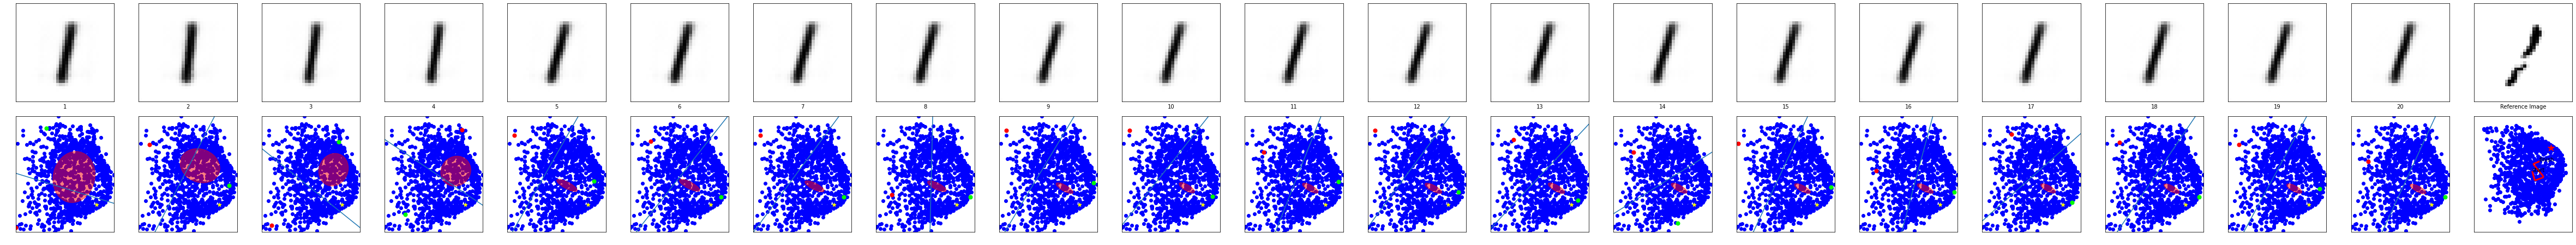

In [11]:
model.eval()
localization_plotting.plot_posterior_mean_images(model, localizer_0, data_manager, plot_num=1)
plt.show()

### Calculate probability that reference comes from posterior

In [ ]:
first_mean = localizer_0.posterior_means[0]
first_var = localizer_0.vars[0]

from scipy import stats
import numpy as np

x = localizer_0.embedded_reference
mu = first_mean
sigma = first_var
m_dist_x = np.dot((x-mu).transpose(),np.linalg.inv(sigma))
m_dist_x = np.dot(m_dist_x, (x-mu))
probability = 1-stats.chi2.cdf(m_dist_x, 3)

for i in range(len(localizer_0.posterior_means)):
    mean = localizer_0.posterior_means[i]
    var = localizer_0.vars[i]
    x = localizer_0.embedded_reference
    mu = mean
    sigma = var
    m_dist_x = np.dot((x-mu).transpose(),np.linalg.inv(sigma))
    m_dist_x = np.dot(m_dist_x, (x-mu))
    probability = 1-stats.chi2.cdf(m_dist_x, 3)
    print(probability)

In [ ]:
from scipy.spatial import distance
# calculate the mahalnobis distance of each point compared to the posterior
embedding = localizer_0.embedding
#for embedding_point in localizer_0.embedding
def calculate_mahalanobis_percentile(mean, covariance, embedded_reference):
    inv_cov = np.linalg.inv(covariance)
    distances = []
    for point in embedding:
        # calculate the mahalanobis distance of each point from the posterior mean
        mahalanobis_distance = distance.mahalanobis(mean, point, inv_cov)
        distances.append(mahalanobis_distance)
    distances = np.array(distances)
    distances = np.sort(distances)
    # calculate the percentile of the embedded_reference
    ref_distance = distance.mahalanobis(mean, embedded_reference, inv_cov)
    percentile = np.searchsorted(distances, ref_distance) / np.shape(distances)[0]
    
    return percentile

def calculate_mahalanobis_percentiles(localizer):
    percentiles = []
    for iteration in range(len(localizer.posterior_means)):
        percentile = calculate_mahalanobis_percentile(localizer.posterior_means[iteration], localizer.vars[iteration], localizer.embedded_reference)
        percentiles.append(percentile)
    return percentiles
        
percentiles = calculate_mahalanobis_percentiles(localizer_0)
print(percentiles)   
plt.plot(percentiles)
plt.show()

### Plot final spearman coefficients

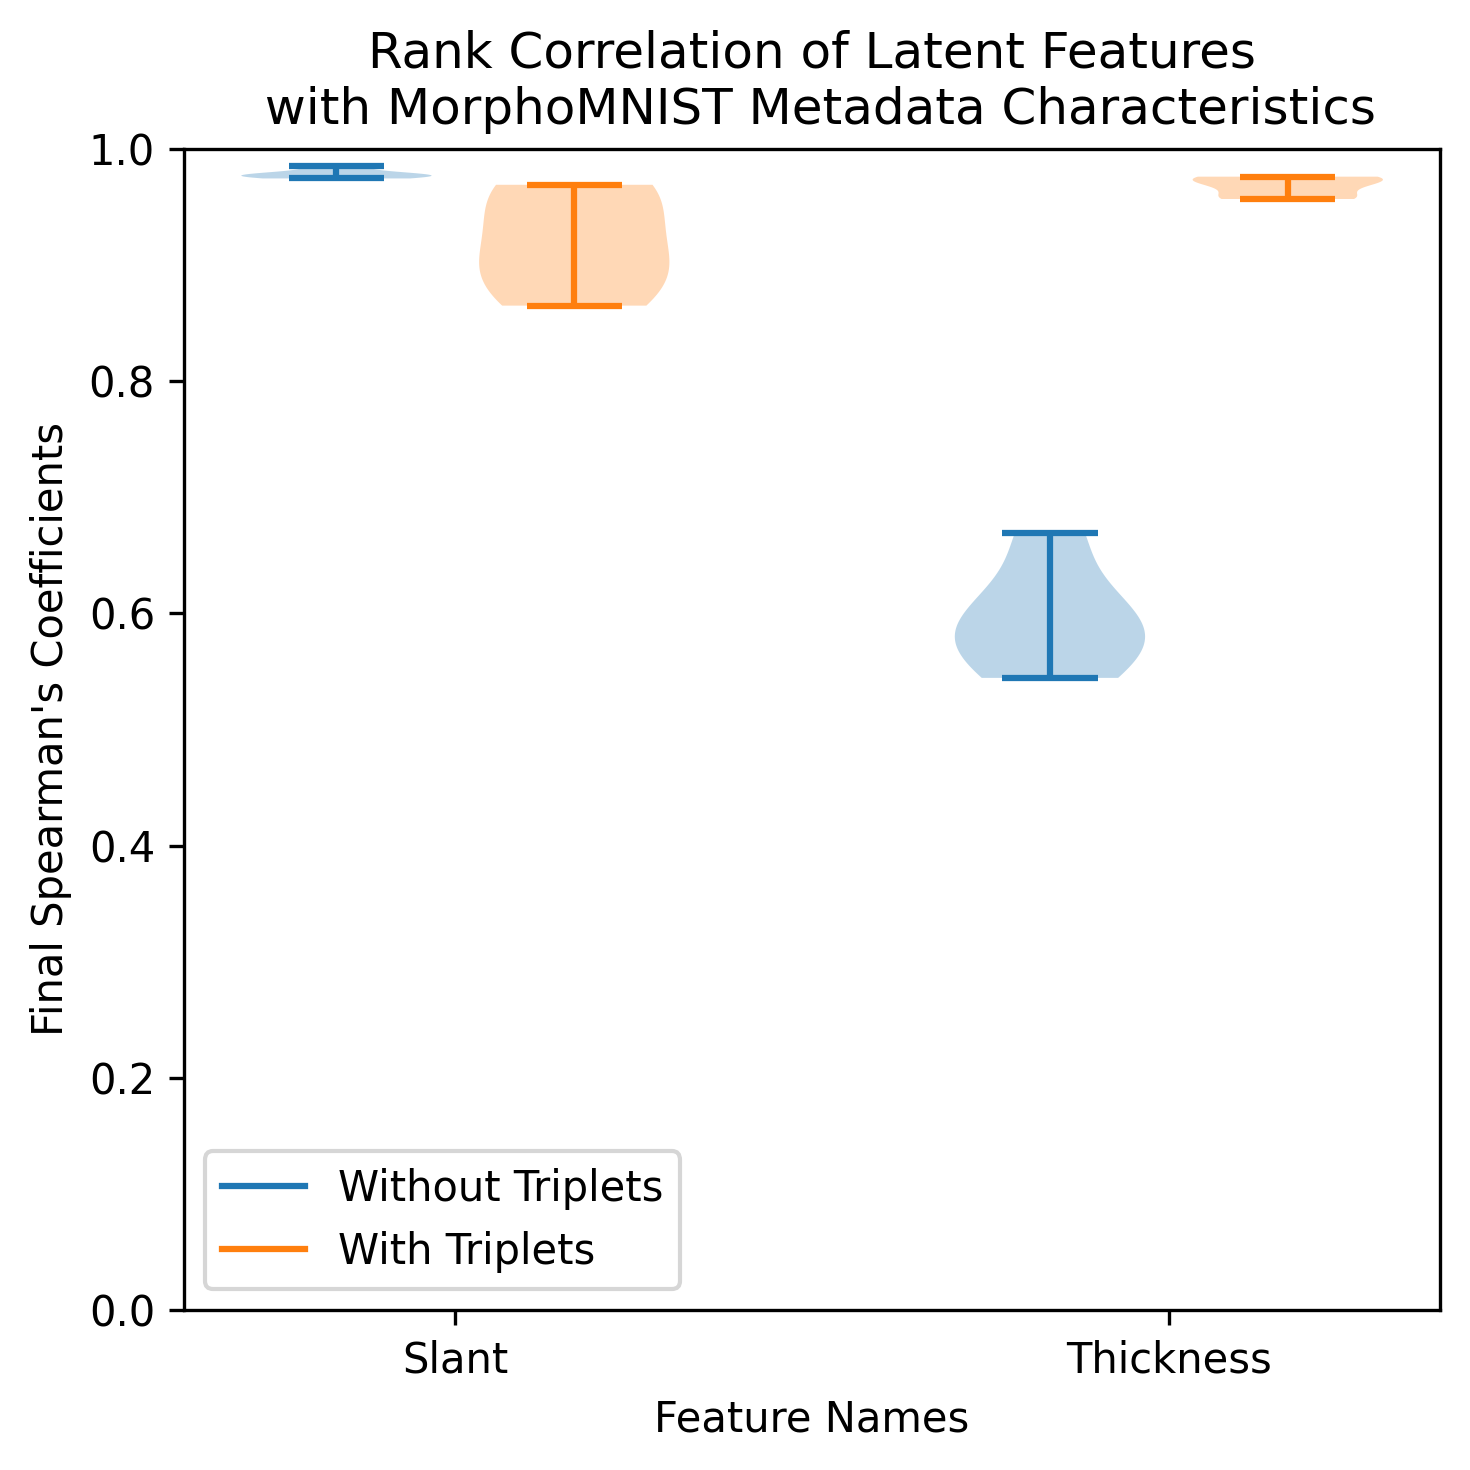

<Figure size 432x288 with 0 Axes>

In [29]:
zero_triplet_spearmans_slant = [0.9772450805, 0.9743134924, 0.9763770709, 0.9848624985, 0.9783219814]
one_triplet_spearmans_slant = [0.9594208825, 0.9688440983, 0.9128474761, 0.8648171646, 0.8911392349]
zero_triplet_spearmans_thickness = [0.6041231569, 0.5443367149, 0.5872665252, 0.5713894599, 0.6688056534]
one_triplet_spearmans_thickness = [0.9578630874, 0.9739765997, 0.9758348426, 0.9720374671, 0.9566199624]
# make violin plot

# final_rank_correlations is a dictionary that maps
# the model name to a 2D arrays of shape (num_metadata_features, num_trials) 
# holding the final rank correlations
fig = plt.figure(figsize=(5, 5), dpi=300)
feature_names = ["Slant", "Thickness"]
# make violin plot for the model
violin_plot = plt.violinplot(zero_triplet_spearmans_slant, positions=[0.5], widths=0.4)
violin_plot = plt.violinplot(one_triplet_spearmans_slant, positions=[1.0], widths=0.4)
plt.gca().set_prop_cycle(None)
violin_plot = plt.violinplot(zero_triplet_spearmans_thickness, positions=[2.0], widths=0.4)
violin_plot = plt.violinplot(one_triplet_spearmans_thickness, positions=[2.5], widths=0.4)
# make ticks
xticks = ["Slant", "Thickness"]
xtick_positions = [0.75, 2.25]
plt.xticks(xtick_positions, xticks)
# high level plot info
plt.ylim(0, 1.0)
plt.ylabel("Final Spearman's Coefficients")
plt.xlabel("Feature Names")
plt.title("Rank Correlation of Latent Features\n with MorphoMNIST Metadata Characteristics")
plt.tight_layout()
# make legends
plt.gca().set_prop_cycle(None)
plt.plot([], label="Without Triplets")
plt.plot([], label="With Triplets")
# show plot
plt.legend(loc="lower left")
plt.show()
plt.draw()
plt.savefig("RankCorrelationMetadata.pdf")

### Show an image sampling for both

In [41]:
with_triplet_path = "youthful-water-7673"
model_dir = "../../../logs/"+with_triplet_path
# load up a basic 2D triplet model
model, config = load_model_and_config(model_dir)
data_manager = setup_data_manager(config)
test_images, embedding, morpho_mnist_metadata = sample_embedding(model, data_manager, num_samples=500)
print(os.listdir(model_dir))
with open(model_dir+"/localizers.pkl", "rb") as f:
    triplet_localizers = pickle.load(f)
    
with open(model_dir+"/localizer_metrics.pkl", "rb") as f:
    triplet_localizer_metrics = pickle.load(f)

Config object:
{'trials': 1, 'epochs': 50, 'lr': 0.001, 'batch_size': 512, 'trainer': 'triplet', 'group': 'thickness_slant_localization_5', 'localization_config': {'indexed': False, 'trials': 20, 'k': 1.0, 'localizer_type': ['MCMV', 'Random'], 'num_queries': 50, 'similarity_mode': False}, 'model_config': {'model_type': 'BasicVAE', 'latent_dim': 2, 'in_shape': 32, 'd': 32, 'layer_count': 4, 'channels': 1, 'loss_name': 'VAETripletLoss', 'kl_beta': 0.01, 'triplet_beta': 1.0, 'triplet_margin': 1.0, 'warm_start': 30, 'kl_max': 0.01, 'triplet_mining': False}, 'dataset_config': {'dataset_name': 'MorphoMNIST', 'component_weighting': [0.0, 0.0, 3.0, 1.0, 0.0, 0.0], 'localization_component_weighting': [0.0, 0.0, 3.0, 1.0, 0.0, 0.0], 'which_digits': [1], 'one_two_ratio': 0.0, 'batch_size': 512}}
unnormalized metadata
Morphometrics(area=39.375, length=21.149494936611667, thickness=1.9390875132151943, slant=0.2911125601885791, width=3.6947053953511713, height=19.595991281599634)
unnormalized metada

unnormalized metadata
Morphometrics(area=57.6875, length=21.442388155425117, thickness=2.82453317489571, slant=-0.014288492510672266, width=4.67351441321312, height=19.60977537747191)
unnormalized metadata
Morphometrics(area=60.625, length=20.424621202458752, thickness=3.122509800554659, slant=0.05564967873629239, width=4.718425784095466, height=19.343513603416508)
unnormalized metadata
Morphometrics(area=49.0625, length=22.338834764831848, thickness=2.430238518050876, slant=0.04161732833176242, width=4.2029130170845495, height=19.18217630259171)
unnormalized metadata
Morphometrics(area=51.3125, length=18.77817459305202, thickness=2.804148254155483, slant=0.10522421789662552, width=4.274507529086517, height=18.96907293497672)
unnormalized metadata
Morphometrics(area=52.8125, length=19.36396103067893, thickness=2.7980439628286686, slant=0.045814226610336406, width=4.192959176141272, height=19.37691409394247)
unnormalized metadata
Morphometrics(area=68.5, length=20.753048327204944, thick

unnormalized metadata
Morphometrics(area=51.125, length=21.149494936611667, thickness=2.615390108739207, slant=-0.06060704617207442, width=4.328431729636298, height=19.11874757414156)
unnormalized metadata
Morphometrics(area=68.5, length=21.106601717798213, thickness=3.199260411299736, slant=0.37686904169904595, width=5.096138578750448, height=19.473490221639768)
unnormalized metadata
Morphometrics(area=34.625, length=19.61396103067893, thickness=1.8368873458346882, slant=0.1918145963980984, width=3.465067166754082, height=19.40668302226271)
unnormalized metadata
Morphometrics(area=43.375, length=19.053300858899107, thickness=2.286485838317708, slant=0.19320647845485064, width=3.8431429578449894, height=19.383502067764883)
unnormalized metadata
Morphometrics(area=42.0, length=19.656854249492383, thickness=2.21716389745308, slant=-0.10818879666376875, width=3.796181838497345, height=19.269209818375664)
unnormalized metadata
Morphometrics(area=41.25, length=20.856601717798217, thickness=

unnormalized metadata
Morphometrics(area=43.1875, length=21.235281374238575, thickness=2.1783300022674856, slant=0.21333525135749357, width=3.9982361674075513, height=18.768459985506787)
unnormalized metadata
Morphometrics(area=52.25, length=18.053300858899107, thickness=2.762161883137128, slant=0.04985943972289876, width=4.48773281426074, height=19.406642311423468)
unnormalized metadata
Morphometrics(area=35.3125, length=19.46015510839149, thickness=1.983831838739144, slant=-0.018514018261755142, width=3.318613766393481, height=18.64165699759732)
unnormalized metadata
Morphometrics(area=35.5625, length=19.73528137423857, thickness=1.9399677868597216, slant=0.06660806992104476, width=3.547528080034704, height=19.586801938101424)
unnormalized metadata
Morphometrics(area=47.4375, length=19.699747468305837, thickness=2.4974196934876263, slant=0.11740370490902055, width=4.362967681818141, height=19.278322282526233)
unnormalized metadata
Morphometrics(area=36.0625, length=20.735281374238575

unnormalized metadata
Morphometrics(area=48.3125, length=19.34619407771256, thickness=2.5949595788413395, slant=-0.09781911122215954, width=4.096973217921899, height=19.04539809847354)
unnormalized metadata
Morphometrics(area=37.5, length=21.50304832720494, thickness=1.9153768178331105, slant=0.12369005812832733, width=3.6573936570331522, height=19.628847080666823)
unnormalized metadata
Morphometrics(area=79.125, length=17.199747468305837, thickness=4.079657699419089, slant=0.10508029706706953, width=5.421811701285327, height=19.719478352688412)
unnormalized metadata
Morphometrics(area=80.6875, length=24.631727983645295, thickness=3.000319158759903, slant=-0.09677393736112634, width=9.933254854812814, height=19.474807047327936)
unnormalized metadata
Morphometrics(area=49.125, length=19.86396103067893, thickness=2.5365240662790134, slant=0.06893934064435962, width=4.2380073905248175, height=19.493715884595687)
unnormalized metadata
Morphometrics(area=43.4375, length=20.8817279836453, th

unnormalized metadata
Morphometrics(area=60.1875, length=23.970562748477146, thickness=2.540723295562941, slant=0.5751237790013888, width=6.533977641143764, height=19.189666854635266)
unnormalized metadata
Morphometrics(area=44.375, length=19.674621202458752, thickness=2.2457847165834184, slant=0.17429887935996094, width=4.003222304306185, height=19.149559319361074)
unnormalized metadata
Morphometrics(area=107.375, length=27.988329701443515, thickness=4.030890447945079, slant=0.6057007496382679, width=8.728819194072198, height=18.86128356174948)
unnormalized metadata
Morphometrics(area=84.0625, length=17.717514421272202, thickness=4.266543293415982, slant=0.15951649690978512, width=6.53252381885431, height=19.265595265705258)
unnormalized metadata
Morphometrics(area=43.0625, length=20.235281374238575, thickness=2.209457438824106, slant=0.2371683453957619, width=4.137496814245672, height=19.120270615665465)
unnormalized metadata
Morphometrics(area=52.6875, length=20.80330085889911, thic

unnormalized metadata
Morphometrics(area=49.0, length=20.803300858899107, thickness=2.4894141604212594, slant=0.0054873131862048586, width=4.087902721705218, height=19.679932890979487)
unnormalized metadata
Morphometrics(area=69.875, length=17.139087296526014, thickness=3.79799300033097, slant=0.04175035012459778, width=5.04444556942728, height=19.262776982196048)
unnormalized metadata
Morphometrics(area=57.25, length=20.760407640085656, thickness=2.8893681899622807, slant=-0.014015050722659465, width=4.376110342688975, height=19.50260287496583)
unnormalized metadata
Morphometrics(area=55.875, length=21.649494936611667, thickness=2.5851479297115674, slant=0.15029977358338795, width=5.655856661289807, height=19.653071459746336)
unnormalized metadata
Morphometrics(area=84.5, length=20.3817279836453, thickness=4.024890677107436, slant=0.16366561854331962, width=6.803325666246364, height=18.91771820033269)
unnormalized metadata
Morphometrics(area=50.25, length=17.785533905932738, thickness

unnormalized metadata
Morphometrics(area=51.5, length=22.49568901432423, thickness=2.314137033553538, slant=0.46607115034931906, width=4.378124505100029, height=19.6582592594199)
unnormalized metadata
Morphometrics(area=60.5625, length=25.531222920256965, thickness=2.3673586814032226, slant=0.5783378393575271, width=6.740426913410829, height=18.95972434285744)
unnormalized metadata
Morphometrics(area=49.125, length=17.32842712474619, thickness=2.7576707898806796, slant=-0.013439611375261819, width=4.072807554388508, height=19.034796964961068)
unnormalized metadata
Morphometrics(area=32.3125, length=21.063708498984766, thickness=1.7430180673475466, slant=0.02547014461459531, width=3.1763020208011703, height=19.251738281506384)
unnormalized metadata
Morphometrics(area=39.0625, length=20.69238815542512, thickness=1.976017549238134, slant=0.1756594075385054, width=4.441090727668028, height=19.760360452559112)
unnormalized metadata
Morphometrics(area=63.125, length=24.634776310850242, thick

unnormalized metadata
Morphometrics(area=39.8125, length=21.235281374238575, thickness=2.052621822784816, slant=-0.011673917363835893, width=3.9460288747756884, height=19.17728345219069)
unnormalized metadata
Morphometrics(area=61.5, length=21.778174593052025, thickness=2.951144875285203, slant=-0.15590482440181494, width=4.710403395663663, height=19.395030274585192)
unnormalized metadata
Morphometrics(area=32.4375, length=20.52817459305202, thickness=1.6436391418763856, slant=0.26986281145927266, width=3.583901274185415, height=19.466758593893246)
unnormalized metadata
Morphometrics(area=34.3125, length=21.3817279836453, thickness=1.6998529965985265, slant=0.2205660728800815, width=3.625346603412723, height=19.706019718960277)
unnormalized metadata
Morphometrics(area=53.375, length=19.21015510839149, thickness=2.715509627233601, slant=0.4378061669469404, width=5.076293204324138, height=18.055873118085568)
unnormalized metadata
Morphometrics(area=47.625, length=23.220562748477146, thic

unnormalized metadata
Morphometrics(area=71.125, length=18.992640687119284, thickness=3.410324122702974, slant=-0.16285261421710226, width=6.289988258199205, height=19.365246728780743)
unnormalized metadata
Morphometrics(area=68.6875, length=23.05634918610405, thickness=3.000143649594161, slant=0.5457350227739388, width=5.472031921287396, height=19.45544298744435)
unnormalized metadata
Morphometrics(area=72.0625, length=20.003048327204944, thickness=3.47905959550379, slant=-0.4040712154362454, width=5.3919697720321125, height=19.32089212723283)
unnormalized metadata
Morphometrics(area=63.9375, length=20.1317279836453, thickness=3.122863877266015, slant=-0.10081723866038551, width=5.81936983174516, height=19.013833316249272)
unnormalized metadata
Morphometrics(area=71.875, length=21.44238815542512, thickness=3.2839517837812027, slant=0.32461044910613945, width=5.708228388125729, height=19.3543393230197)
unnormalized metadata
Morphometrics(area=36.1875, length=23.106601717798217, thickne

unnormalized metadata
Morphometrics(area=32.75, length=20.510407640085656, thickness=1.7273679519900544, slant=0.07765002907243002, width=3.623945056489932, height=19.477256975694647)
unnormalized metadata
Morphometrics(area=38.5625, length=21.47792206135786, thickness=1.908730836773493, slant=0.47705394179305355, width=3.9971872234559633, height=18.376171538057992)
unnormalized metadata
Morphometrics(area=44.5, length=18.924621202458752, thickness=2.4298891571287857, slant=0.19636789522369663, width=4.697840618086465, height=18.531412661427737)
unnormalized metadata
Morphometrics(area=39.25, length=18.86396103067893, thickness=2.2208986689348498, slant=0.019930842983119267, width=3.898139319493536, height=17.92774333370867)
unnormalized metadata
Morphometrics(area=47.4375, length=19.821067811865476, thickness=2.467155723574735, slant=0.12972070962877044, width=4.146412395270142, height=19.439693393316272)
unnormalized metadata
Morphometrics(area=42.5625, length=18.34619407771256, thic

unnormalized metadata
Morphometrics(area=57.5625, length=19.071067811865476, thickness=2.9596285495111143, slant=0.2901839775863, width=4.58563485778399, height=19.100286395922506)
unnormalized metadata
Morphometrics(area=35.375, length=19.09619407771256, thickness=1.9476639322194897, slant=0.06313515953452291, width=3.5345258355227127, height=19.510816368654567)
unnormalized metadata
Morphometrics(area=47.125, length=21.303300858899107, thickness=2.3667286526887836, slant=0.10371579763265693, width=4.252661294143682, height=19.126960793350882)
unnormalized metadata
Morphometrics(area=45.25, length=22.68502884254441, thickness=2.0745793644193444, slant=0.46021368018489944, width=4.102105607263521, height=19.59804346854748)
unnormalized metadata
Morphometrics(area=39.5, length=21.053300858899107, thickness=2.045748011064248, slant=0.060001396548608386, width=3.630530767609116, height=19.64337665147483)
unnormalized metadata
Morphometrics(area=41.5, length=22.831475451951132, thickness=1

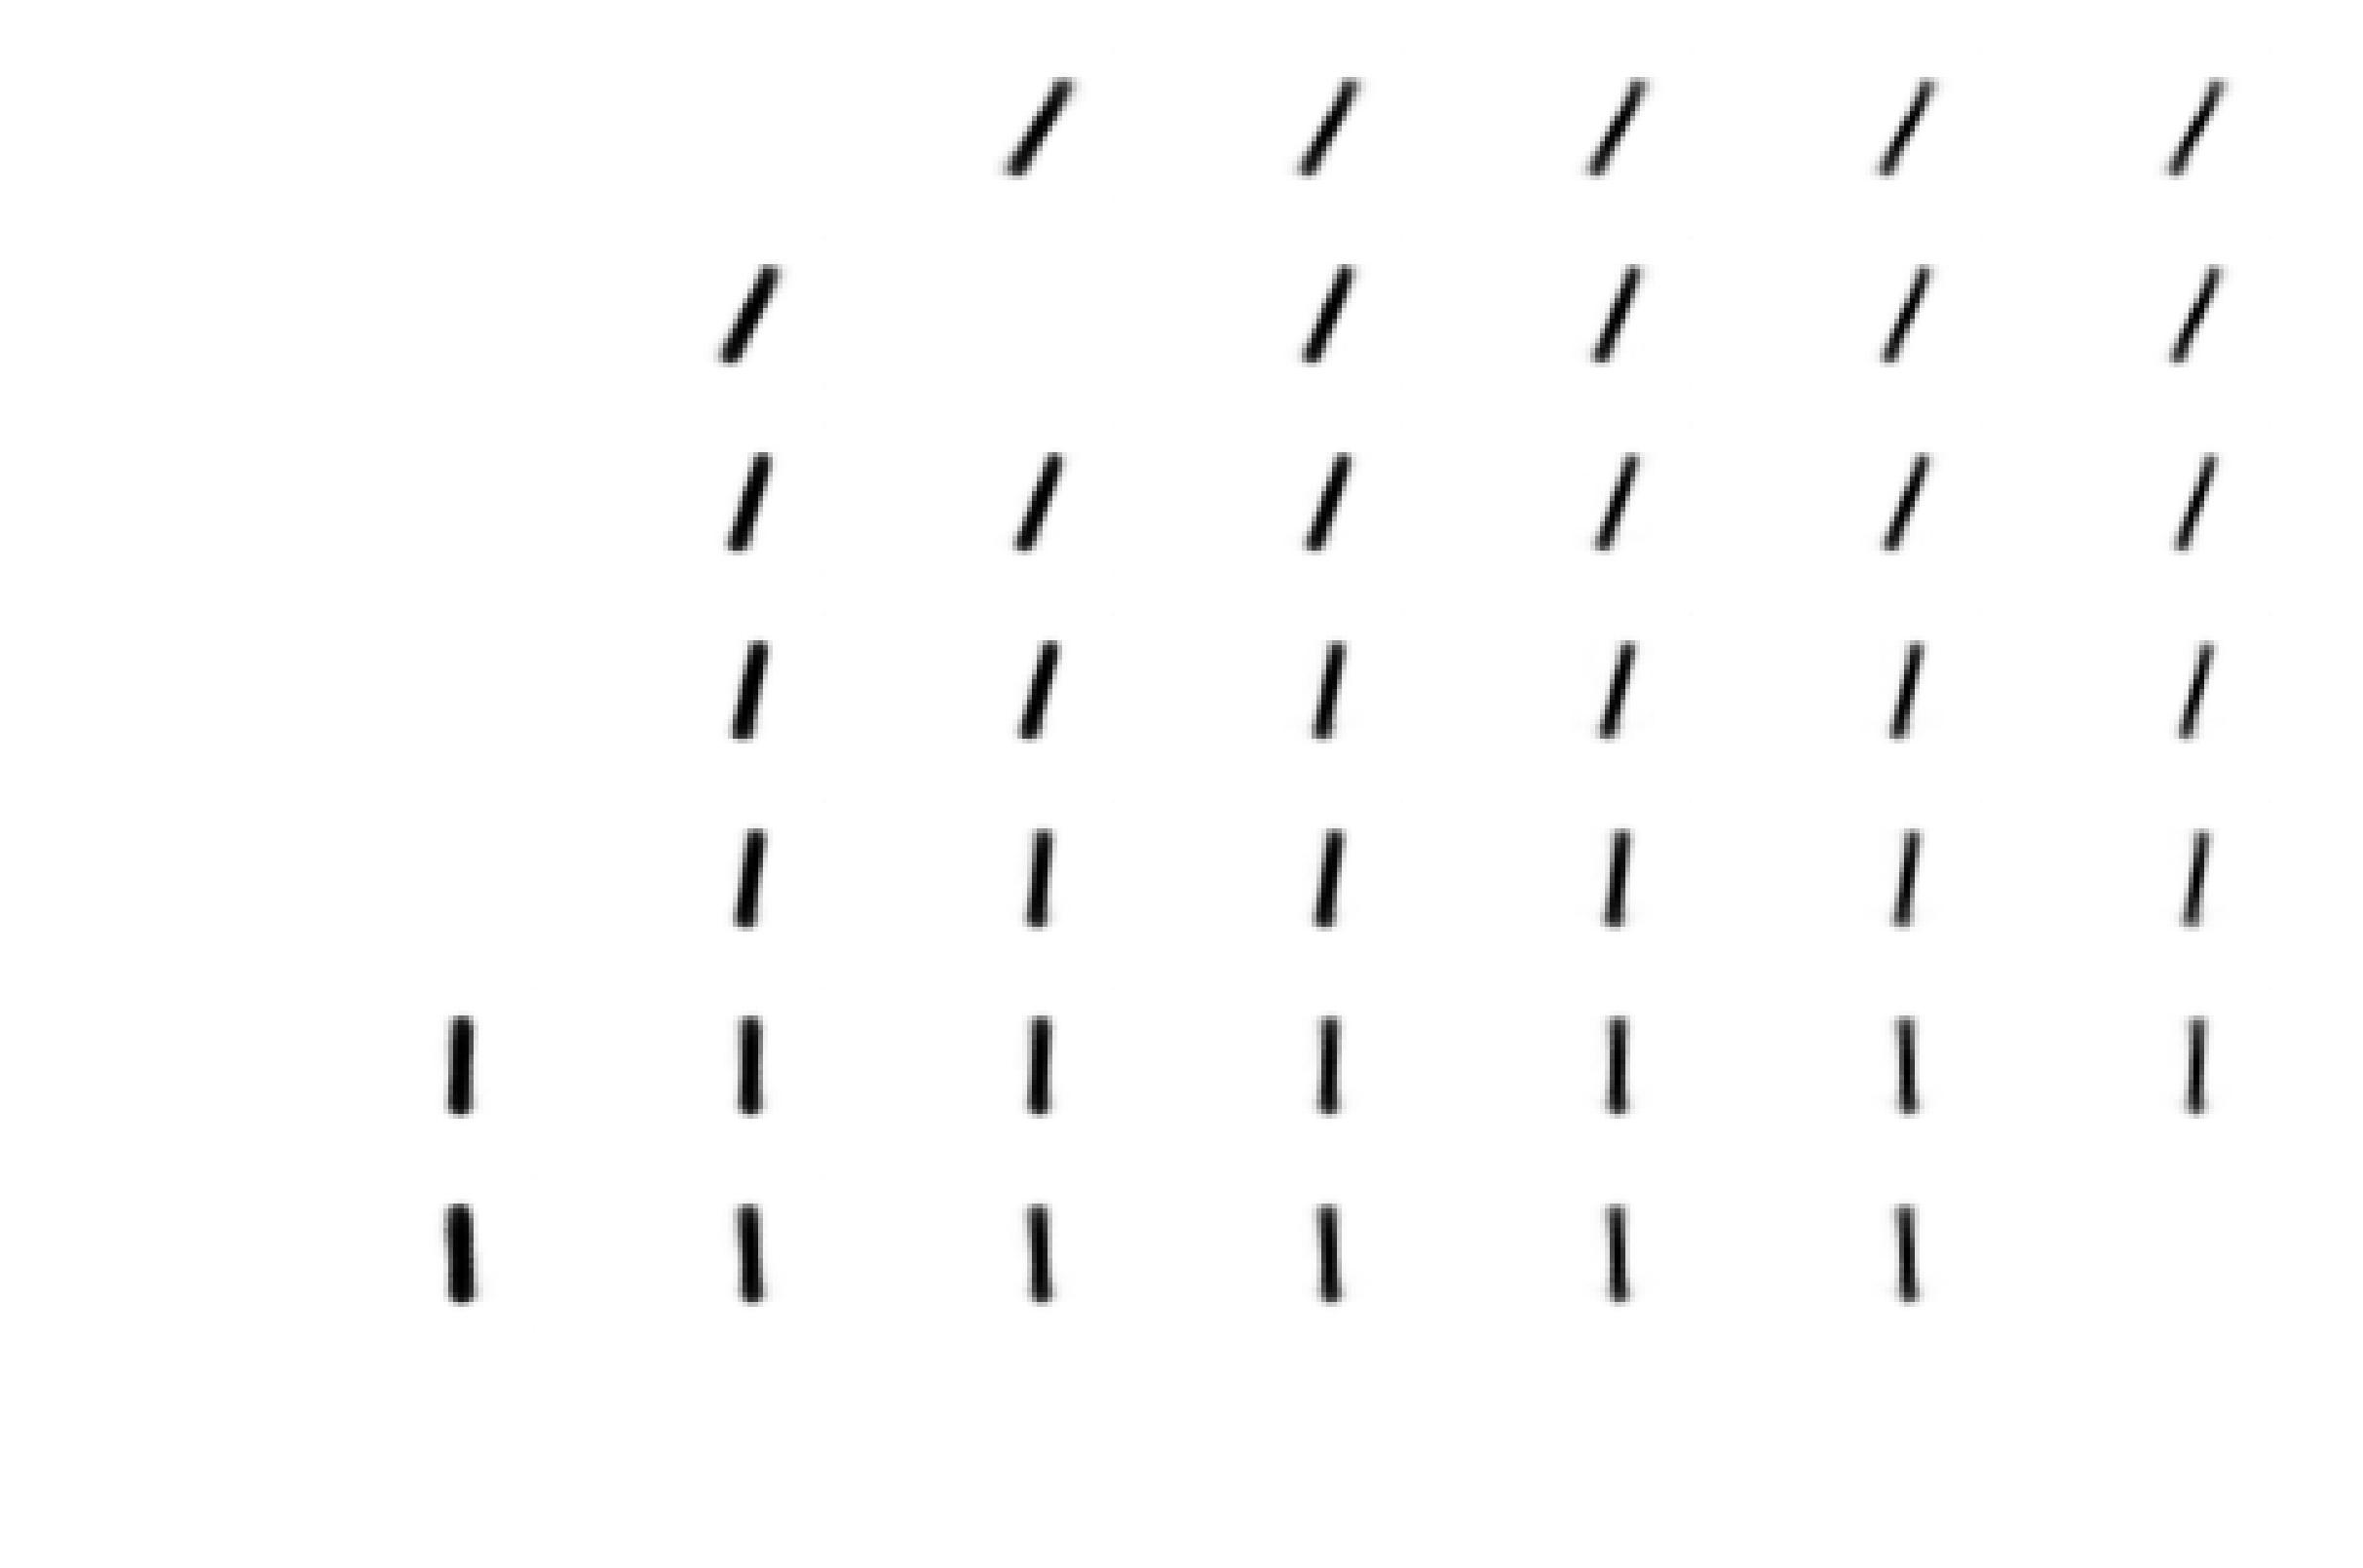

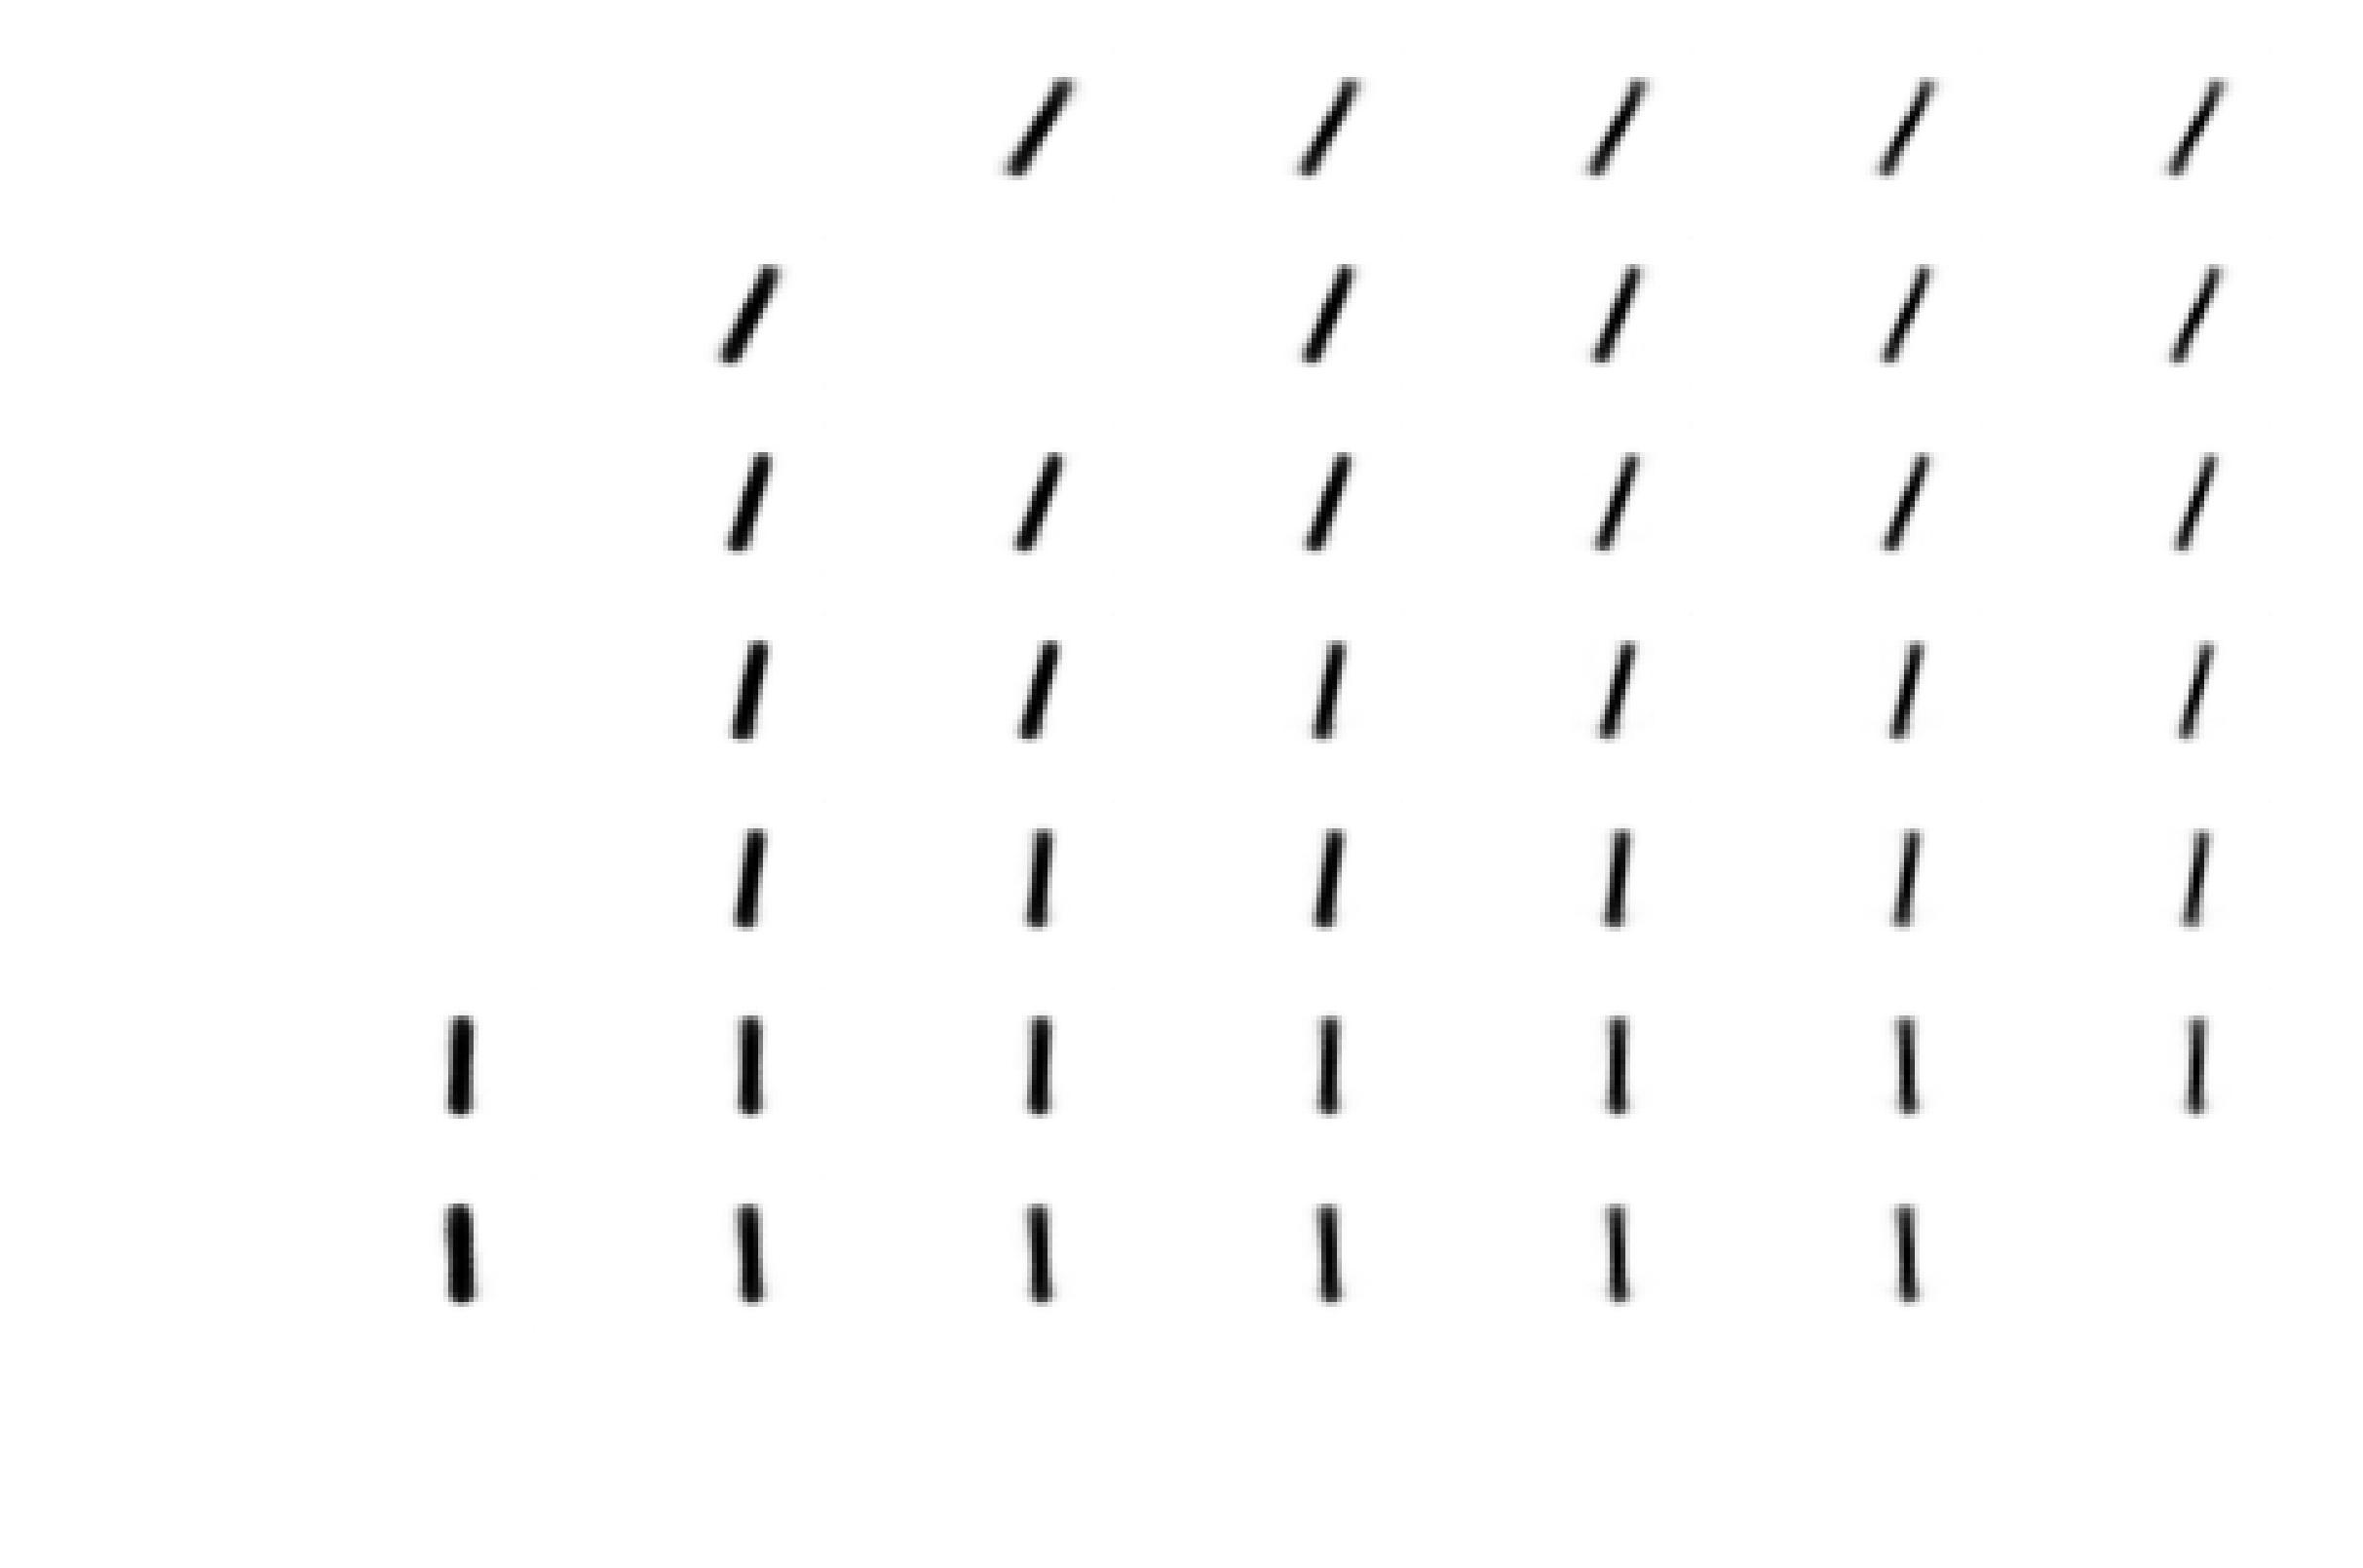

In [37]:
image_sampling.plot_binned_tsne_grid(embedding, embedding, model, num_channels=1, dpi=500, num_x_bins=8, num_y_bins=8, title="")

In [42]:
without_triplet_path = "deep-forest-7671"
model_dir = "../../../logs/"+without_triplet_path
# load up a basic 2D triplet model
model, config = load_model_and_config(model_dir)
data_manager = setup_data_manager(config)
test_images, embedding, morpho_mnist_metadata = sample_embedding(model, data_manager, num_samples=500)

Config object:
{'trials': 1, 'epochs': 50, 'lr': 0.001, 'batch_size': 512, 'trainer': 'triplet', 'group': 'thickness_slant_localization_5', 'localization_config': {'indexed': False, 'trials': 20, 'k': 1.0, 'localizer_type': ['MCMV', 'Random'], 'num_queries': 50, 'similarity_mode': False}, 'model_config': {'model_type': 'BasicVAE', 'latent_dim': 2, 'in_shape': 32, 'd': 32, 'layer_count': 4, 'channels': 1, 'loss_name': 'VAETripletLoss', 'kl_beta': 0.01, 'triplet_beta': 0.0, 'triplet_margin': 1.0, 'warm_start': 30, 'kl_max': 0.01, 'triplet_mining': False}, 'dataset_config': {'dataset_name': 'MorphoMNIST', 'component_weighting': [0.0, 0.0, 3.0, 1.0, 0.0, 0.0], 'localization_component_weighting': [0.0, 0.0, 3.0, 1.0, 0.0, 0.0], 'which_digits': [1], 'one_two_ratio': 0.0, 'batch_size': 512}}
unnormalized metadata
Morphometrics(area=39.375, length=21.149494936611667, thickness=1.9390875132151943, slant=0.2911125601885791, width=3.6947053953511713, height=19.595991281599634)
unnormalized metada

unnormalized metadata
Morphometrics(area=57.6875, length=21.442388155425117, thickness=2.82453317489571, slant=-0.014288492510672266, width=4.67351441321312, height=19.60977537747191)
unnormalized metadata
Morphometrics(area=60.625, length=20.424621202458752, thickness=3.122509800554659, slant=0.05564967873629239, width=4.718425784095466, height=19.343513603416508)
unnormalized metadata
Morphometrics(area=49.0625, length=22.338834764831848, thickness=2.430238518050876, slant=0.04161732833176242, width=4.2029130170845495, height=19.18217630259171)
unnormalized metadata
Morphometrics(area=51.3125, length=18.77817459305202, thickness=2.804148254155483, slant=0.10522421789662552, width=4.274507529086517, height=18.96907293497672)
unnormalized metadata
Morphometrics(area=52.8125, length=19.36396103067893, thickness=2.7980439628286686, slant=0.045814226610336406, width=4.192959176141272, height=19.37691409394247)
unnormalized metadata
Morphometrics(area=68.5, length=20.753048327204944, thick

unnormalized metadata
Morphometrics(area=51.125, length=21.149494936611667, thickness=2.615390108739207, slant=-0.06060704617207442, width=4.328431729636298, height=19.11874757414156)
unnormalized metadata
Morphometrics(area=68.5, length=21.106601717798213, thickness=3.199260411299736, slant=0.37686904169904595, width=5.096138578750448, height=19.473490221639768)
unnormalized metadata
Morphometrics(area=34.625, length=19.61396103067893, thickness=1.8368873458346882, slant=0.1918145963980984, width=3.465067166754082, height=19.40668302226271)
unnormalized metadata
Morphometrics(area=43.375, length=19.053300858899107, thickness=2.286485838317708, slant=0.19320647845485064, width=3.8431429578449894, height=19.383502067764883)
unnormalized metadata
Morphometrics(area=42.0, length=19.656854249492383, thickness=2.21716389745308, slant=-0.10818879666376875, width=3.796181838497345, height=19.269209818375664)
unnormalized metadata
Morphometrics(area=41.25, length=20.856601717798217, thickness=

unnormalized metadata
Morphometrics(area=43.1875, length=21.235281374238575, thickness=2.1783300022674856, slant=0.21333525135749357, width=3.9982361674075513, height=18.768459985506787)
unnormalized metadata
Morphometrics(area=52.25, length=18.053300858899107, thickness=2.762161883137128, slant=0.04985943972289876, width=4.48773281426074, height=19.406642311423468)
unnormalized metadata
Morphometrics(area=35.3125, length=19.46015510839149, thickness=1.983831838739144, slant=-0.018514018261755142, width=3.318613766393481, height=18.64165699759732)
unnormalized metadata
Morphometrics(area=35.5625, length=19.73528137423857, thickness=1.9399677868597216, slant=0.06660806992104476, width=3.547528080034704, height=19.586801938101424)
unnormalized metadata
Morphometrics(area=47.4375, length=19.699747468305837, thickness=2.4974196934876263, slant=0.11740370490902055, width=4.362967681818141, height=19.278322282526233)
unnormalized metadata
Morphometrics(area=36.0625, length=20.735281374238575

unnormalized metadata
Morphometrics(area=48.3125, length=19.34619407771256, thickness=2.5949595788413395, slant=-0.09781911122215954, width=4.096973217921899, height=19.04539809847354)
unnormalized metadata
Morphometrics(area=37.5, length=21.50304832720494, thickness=1.9153768178331105, slant=0.12369005812832733, width=3.6573936570331522, height=19.628847080666823)
unnormalized metadata
Morphometrics(area=79.125, length=17.199747468305837, thickness=4.079657699419089, slant=0.10508029706706953, width=5.421811701285327, height=19.719478352688412)
unnormalized metadata
Morphometrics(area=80.6875, length=24.631727983645295, thickness=3.000319158759903, slant=-0.09677393736112634, width=9.933254854812814, height=19.474807047327936)
unnormalized metadata
Morphometrics(area=49.125, length=19.86396103067893, thickness=2.5365240662790134, slant=0.06893934064435962, width=4.2380073905248175, height=19.493715884595687)
unnormalized metadata
Morphometrics(area=43.4375, length=20.8817279836453, th

unnormalized metadata
Morphometrics(area=60.1875, length=23.970562748477146, thickness=2.540723295562941, slant=0.5751237790013888, width=6.533977641143764, height=19.189666854635266)
unnormalized metadata
Morphometrics(area=44.375, length=19.674621202458752, thickness=2.2457847165834184, slant=0.17429887935996094, width=4.003222304306185, height=19.149559319361074)
unnormalized metadata
Morphometrics(area=107.375, length=27.988329701443515, thickness=4.030890447945079, slant=0.6057007496382679, width=8.728819194072198, height=18.86128356174948)
unnormalized metadata
Morphometrics(area=84.0625, length=17.717514421272202, thickness=4.266543293415982, slant=0.15951649690978512, width=6.53252381885431, height=19.265595265705258)
unnormalized metadata
Morphometrics(area=43.0625, length=20.235281374238575, thickness=2.209457438824106, slant=0.2371683453957619, width=4.137496814245672, height=19.120270615665465)
unnormalized metadata
Morphometrics(area=52.6875, length=20.80330085889911, thic

unnormalized metadata
Morphometrics(area=49.0, length=20.803300858899107, thickness=2.4894141604212594, slant=0.0054873131862048586, width=4.087902721705218, height=19.679932890979487)
unnormalized metadata
Morphometrics(area=69.875, length=17.139087296526014, thickness=3.79799300033097, slant=0.04175035012459778, width=5.04444556942728, height=19.262776982196048)
unnormalized metadata
Morphometrics(area=57.25, length=20.760407640085656, thickness=2.8893681899622807, slant=-0.014015050722659465, width=4.376110342688975, height=19.50260287496583)
unnormalized metadata
Morphometrics(area=55.875, length=21.649494936611667, thickness=2.5851479297115674, slant=0.15029977358338795, width=5.655856661289807, height=19.653071459746336)
unnormalized metadata
Morphometrics(area=84.5, length=20.3817279836453, thickness=4.024890677107436, slant=0.16366561854331962, width=6.803325666246364, height=18.91771820033269)
unnormalized metadata
Morphometrics(area=50.25, length=17.785533905932738, thickness

unnormalized metadata
Morphometrics(area=51.5, length=22.49568901432423, thickness=2.314137033553538, slant=0.46607115034931906, width=4.378124505100029, height=19.6582592594199)
unnormalized metadata
Morphometrics(area=60.5625, length=25.531222920256965, thickness=2.3673586814032226, slant=0.5783378393575271, width=6.740426913410829, height=18.95972434285744)
unnormalized metadata
Morphometrics(area=49.125, length=17.32842712474619, thickness=2.7576707898806796, slant=-0.013439611375261819, width=4.072807554388508, height=19.034796964961068)
unnormalized metadata
Morphometrics(area=32.3125, length=21.063708498984766, thickness=1.7430180673475466, slant=0.02547014461459531, width=3.1763020208011703, height=19.251738281506384)
unnormalized metadata
Morphometrics(area=39.0625, length=20.69238815542512, thickness=1.976017549238134, slant=0.1756594075385054, width=4.441090727668028, height=19.760360452559112)
unnormalized metadata
Morphometrics(area=63.125, length=24.634776310850242, thick

unnormalized metadata
Morphometrics(area=39.8125, length=21.235281374238575, thickness=2.052621822784816, slant=-0.011673917363835893, width=3.9460288747756884, height=19.17728345219069)
unnormalized metadata
Morphometrics(area=61.5, length=21.778174593052025, thickness=2.951144875285203, slant=-0.15590482440181494, width=4.710403395663663, height=19.395030274585192)
unnormalized metadata
Morphometrics(area=32.4375, length=20.52817459305202, thickness=1.6436391418763856, slant=0.26986281145927266, width=3.583901274185415, height=19.466758593893246)
unnormalized metadata
Morphometrics(area=34.3125, length=21.3817279836453, thickness=1.6998529965985265, slant=0.2205660728800815, width=3.625346603412723, height=19.706019718960277)
unnormalized metadata
Morphometrics(area=53.375, length=19.21015510839149, thickness=2.715509627233601, slant=0.4378061669469404, width=5.076293204324138, height=18.055873118085568)
unnormalized metadata
Morphometrics(area=47.625, length=23.220562748477146, thic

unnormalized metadata
Morphometrics(area=71.125, length=18.992640687119284, thickness=3.410324122702974, slant=-0.16285261421710226, width=6.289988258199205, height=19.365246728780743)
unnormalized metadata
Morphometrics(area=68.6875, length=23.05634918610405, thickness=3.000143649594161, slant=0.5457350227739388, width=5.472031921287396, height=19.45544298744435)
unnormalized metadata
Morphometrics(area=72.0625, length=20.003048327204944, thickness=3.47905959550379, slant=-0.4040712154362454, width=5.3919697720321125, height=19.32089212723283)
unnormalized metadata
Morphometrics(area=63.9375, length=20.1317279836453, thickness=3.122863877266015, slant=-0.10081723866038551, width=5.81936983174516, height=19.013833316249272)
unnormalized metadata
Morphometrics(area=71.875, length=21.44238815542512, thickness=3.2839517837812027, slant=0.32461044910613945, width=5.708228388125729, height=19.3543393230197)
unnormalized metadata
Morphometrics(area=36.1875, length=23.106601717798217, thickne

unnormalized metadata
Morphometrics(area=32.75, length=20.510407640085656, thickness=1.7273679519900544, slant=0.07765002907243002, width=3.623945056489932, height=19.477256975694647)
unnormalized metadata
Morphometrics(area=38.5625, length=21.47792206135786, thickness=1.908730836773493, slant=0.47705394179305355, width=3.9971872234559633, height=18.376171538057992)
unnormalized metadata
Morphometrics(area=44.5, length=18.924621202458752, thickness=2.4298891571287857, slant=0.19636789522369663, width=4.697840618086465, height=18.531412661427737)
unnormalized metadata
Morphometrics(area=39.25, length=18.86396103067893, thickness=2.2208986689348498, slant=0.019930842983119267, width=3.898139319493536, height=17.92774333370867)
unnormalized metadata
Morphometrics(area=47.4375, length=19.821067811865476, thickness=2.467155723574735, slant=0.12972070962877044, width=4.146412395270142, height=19.439693393316272)
unnormalized metadata
Morphometrics(area=42.5625, length=18.34619407771256, thic

unnormalized metadata
Morphometrics(area=57.5625, length=19.071067811865476, thickness=2.9596285495111143, slant=0.2901839775863, width=4.58563485778399, height=19.100286395922506)
unnormalized metadata
Morphometrics(area=35.375, length=19.09619407771256, thickness=1.9476639322194897, slant=0.06313515953452291, width=3.5345258355227127, height=19.510816368654567)
unnormalized metadata
Morphometrics(area=47.125, length=21.303300858899107, thickness=2.3667286526887836, slant=0.10371579763265693, width=4.252661294143682, height=19.126960793350882)
unnormalized metadata
Morphometrics(area=45.25, length=22.68502884254441, thickness=2.0745793644193444, slant=0.46021368018489944, width=4.102105607263521, height=19.59804346854748)
unnormalized metadata
Morphometrics(area=39.5, length=21.053300858899107, thickness=2.045748011064248, slant=0.060001396548608386, width=3.630530767609116, height=19.64337665147483)
unnormalized metadata
Morphometrics(area=41.5, length=22.831475451951132, thickness=1

In [43]:
print(os.listdir(model_dir))
with open(model_dir+"/localizers.pkl", "rb") as f:
    no_triplet_localizers = pickle.load(f)
    
with open(model_dir+"/localizer_metrics.pkl", "rb") as f:
    no_triplet_localizer_metrics = pickle.load(f)

['model.pkl', 'params.pkl', 'localizers.pkl', 'localizer_metrics.pkl', 'loss.pkl']


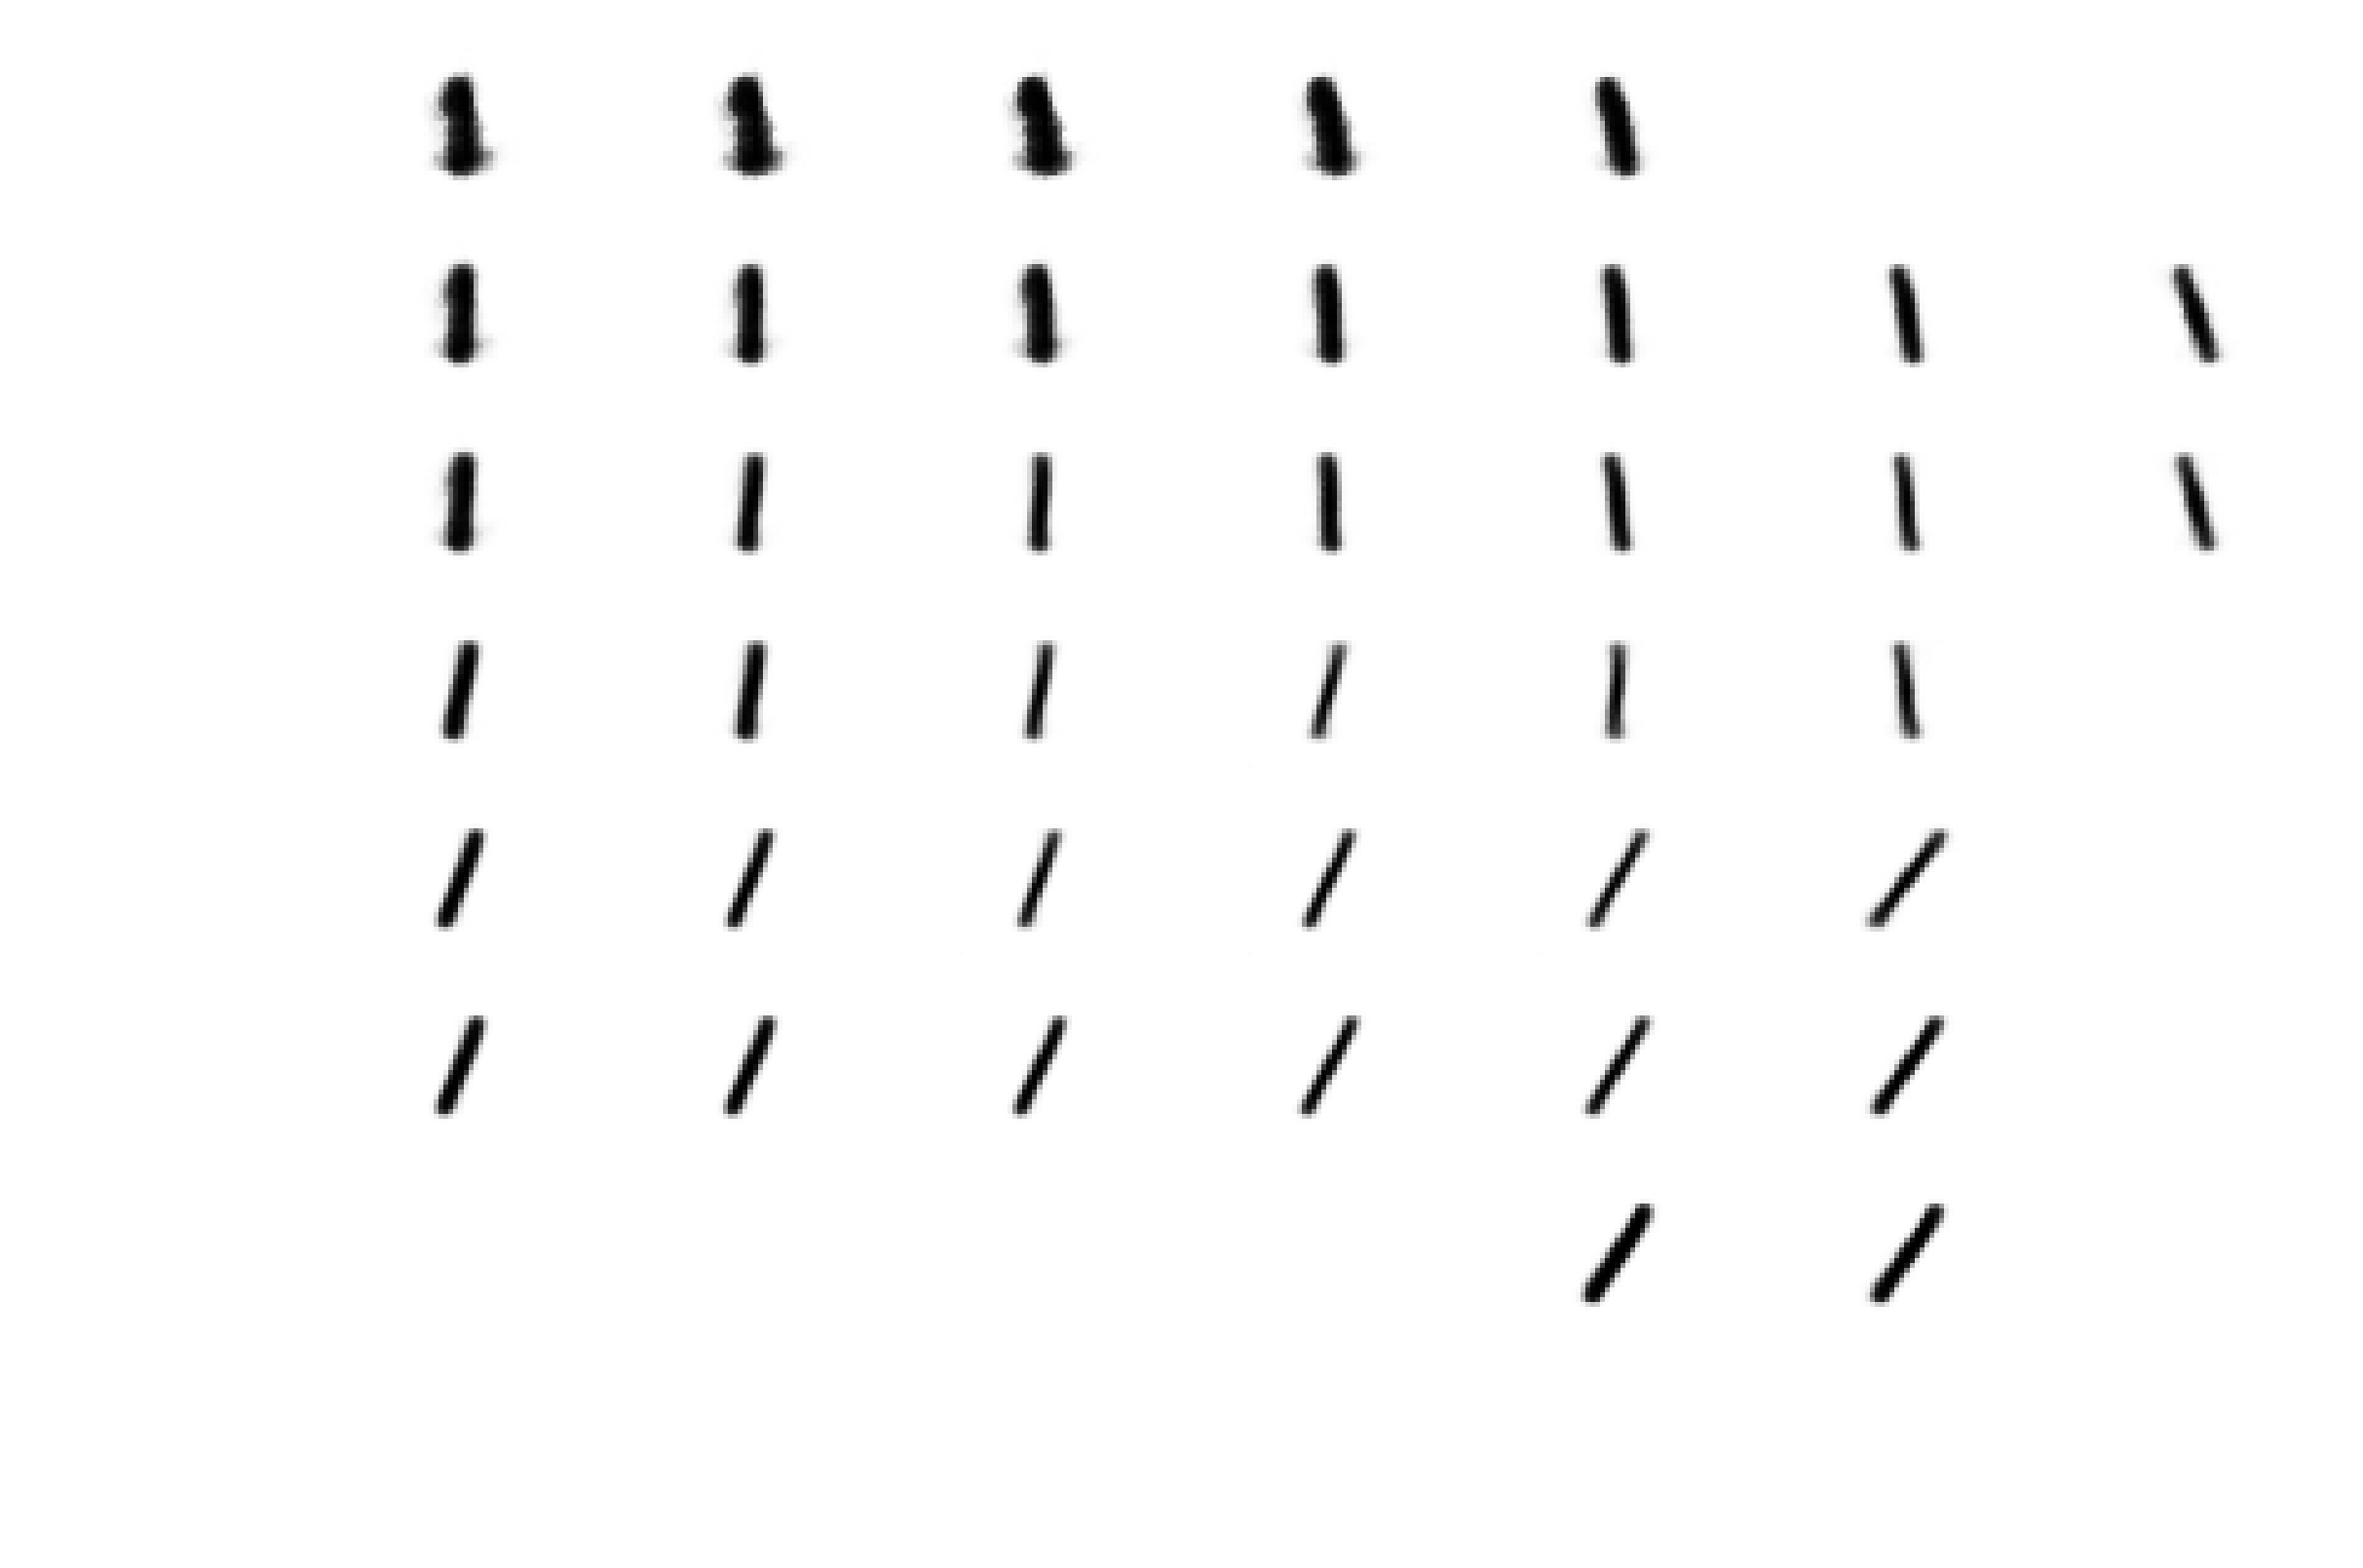

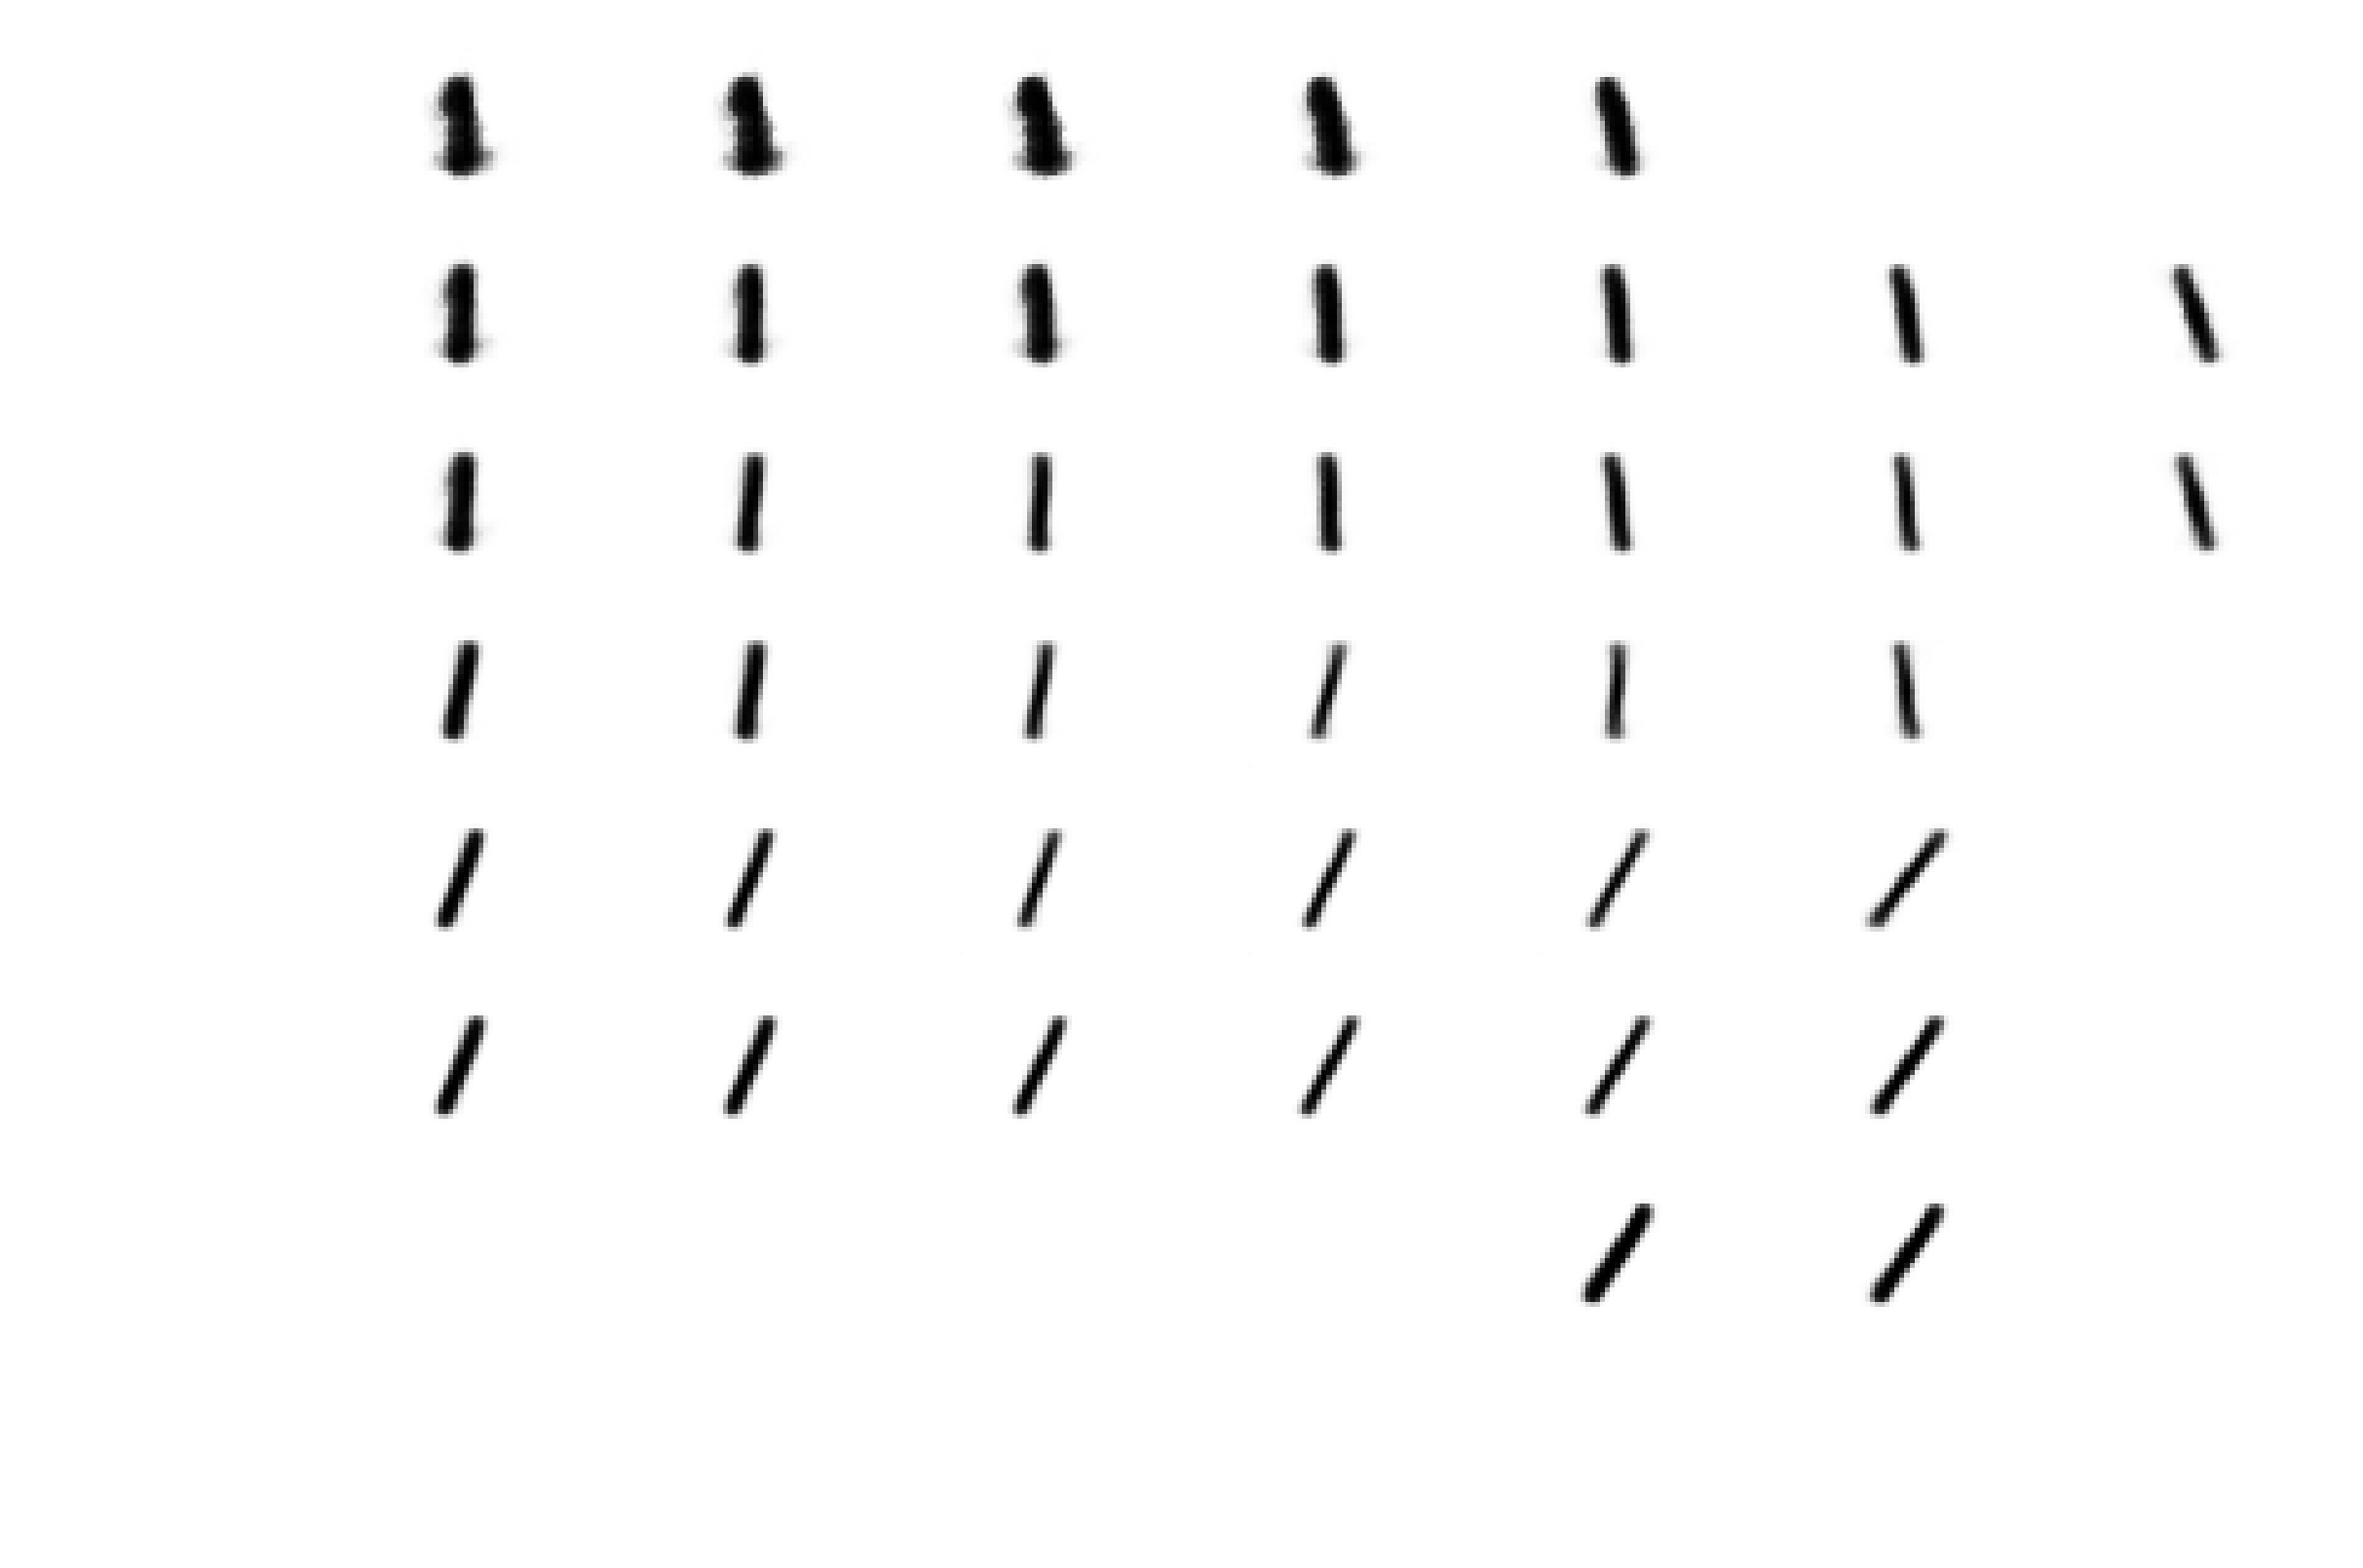

In [39]:
image_sampling.plot_binned_tsne_grid(embedding, embedding, model, num_channels=1, dpi=500, num_x_bins=8, num_y_bins=8, title="")

### Data Setup

This is the run for a triplet model

In [120]:
# load up a basic 2D triplet model
model_dir = "../../../logs/noble-snowball-7399"
feature_index = 2 # thickness
model, config = load_model_and_config(model_dir)
data_manager = setup_data_manager(config)
test_images, embedding_locations, morpho_mnist_metadata = sample_embedding(model, data_manager, num_samples=500)
# run plotting

FileNotFoundError: [Errno 2] No such file or directory: '../../../logs/noble-snowball-7399/params.pkl'

### Plot per metadata characteristic final localization distance

In [51]:
print(triplet_localizer_metrics[0])

{'metadata_loss': [0.3435172488476805, 0.2969932807567908, 0.27027743325399234, 0.3807694835995804, 0.37839782379501413, 0.2983319088650538, 0.3065485993510078, 0.36142835562256137, 0.3084866782377673, 0.3918721657820111, 0.37048580919776175, 0.3357955442935234, 0.3749245667889142, 0.3284576577573578, 0.3598129516733036, 0.4058348033452053, 0.3315572619839232, 0.3722225869527339, 0.4013475320612245, 0.3287486884076923, 0.3256832743056505, 0.14315919858420592, 0.14472751458562383, 0.233667839409693, 0.1431939050136216, 0.14268890404683077, 0.13779476718309727, 0.13896289527029249, 0.25303407809038275, 0.15832857627483246, 0.2380227333286425, 0.14111563512296305, 0.20625464638205693, 0.19974109416103408, 0.23787235668541556, 0.18610336523976578, 0.19624597412767594, 0.15637824966865818, 0.1461811115259884, 0.14604628232271735, 0.14694647894729485, 0.22675815189251652, 0.15230226304085834, 0.1860815915707588, 0.14690685272257284, 0.14946519983678852, 0.1456499770152683, 0.1948810629622092

In [90]:
# separate mcmv and random localization
# evens are mcmv odds are random
mcmv_triplet_localizer_metrics = triplet_localizer_metrics[::2]
triplet_mcmv_vals = {"slant":[], "thickness":[]}
for localizer_index in range(len(mcmv_triplet_localizer_metrics)):
    metrics = mcmv_triplet_localizer_metrics[localizer_index]
    # get final broken_down_metadata_loss
    final_broken_down = metrics["broken_down_metadata_loss"]
    # separate into slant and thickness
    slant = final_broken_down[-1][3]
    thickness = final_broken_down[-1][2]
    # add to mcmv vals
    triplet_mcmv_vals["slant"].append(slant)
    triplet_mcmv_vals["thickness"].append(thickness)
    
random_triplet_localizer_metrics = triplet_localizer_metrics[1::2]
triplet_random_vals = {"slant":[], "thickness":[]}
for localizer_index in range(len(random_triplet_localizer_metrics)):
    metrics = random_triplet_localizer_metrics[localizer_index]
    # get final broken_down_metadata_loss
    final_broken_down = metrics["broken_down_metadata_loss"]
    # separate into slant and thickness
    slant = final_broken_down[-1][3]
    thickness = final_broken_down[-1][2]
    # add to mcmv vals
    triplet_random_vals["slant"].append(slant)
    triplet_random_vals["thickness"].append(thickness)

In [96]:
# separate mcmv and random localization
# evens are mcmv odds are random
mcmv_no_triplet_localizer_metrics = no_triplet_localizer_metrics[::2]
print(mcmv_no_triplet_localizer_metrics)
no_triplet_mcmv_vals = {"slant":[], "thickness":[]}
for localizer_index in range(len(mcmv_no_triplet_localizer_metrics)):
    metrics = mcmv_no_triplet_localizer_metrics[localizer_index]
    # get final broken_down_metadata_loss
    final_broken_down = metrics["broken_down_metadata_loss"]
    # separate into slant and thickness
    slant = final_broken_down[-1][3]
    thickness = final_broken_down[-1][2]
    # add to mcmv vals
    no_triplet_mcmv_vals["slant"].append(slant)
    no_triplet_mcmv_vals["thickness"].append(thickness)
    
random_triplet_localizer_metrics = no_triplet_localizer_metrics[1::2]
no_triplet_random_vals = {"slant":[], "thickness":[]}
for localizer_index in range(len(random_no_triplet_localizer_metrics)):
    metrics = random_no_triplet_localizer_metrics[localizer_index]
    # get final broken_down_metadata_loss
    final_broken_down = metrics["broken_down_metadata_loss"]
    # separate into slant and thickness
    slant = final_broken_down[-1][3]
    thickness = final_broken_down[-1][2]
    # add to mcmv vals
    no_triplet_random_vals["slant"].append(slant)
    no_triplet_random_vals["thickness"].append(thickness)

[{'metadata_loss': [0.14921377918086065, 0.14821213318250226, 0.3046264847921939, 0.09976231458436288, 0.08315117120815775, 0.10617985475089955, 0.13448385448369826, 0.19200324720506318, 0.16959303007776394, 0.18531232703667908, 0.15012129005584254, 0.22547943709967994, 0.2198803011864925, 0.22002397993813078, 0.2072797605687577, 0.16626412775313448, 0.20341187386599346, 0.20622573932943897, 0.17551237625016902, 0.24471256423560622, 0.21368940868541234, 0.214174061640413, 0.20031639236725363, 0.20170702228800158, 0.18530277951797888, 0.24130651075635054, 0.20639136153689672, 0.17874667647071274, 0.2440100254122738, 0.24608017018217368, 0.15607964158366977, 0.1686317929056925, 0.2863978558777572, 0.1606781887009148, 0.24830913812325997, 0.25562997933461185, 0.17793756617150458, 0.2556524571238617, 0.1956540963867351, 0.16994489570309146, 0.2049669891988462, 0.1876527548082193, 0.1973563743678849, 0.1846886930866084, 0.20811914508789217, 0.31264152456923283, 0.21684086374454434, 0.170623

In [97]:
print(no_triplet_mcmv_vals)

{'slant': [0.005011913365468246, 0.04721167078722266, 0.005834016744160175, 0.154202788487233, 0.025243290118546202, 0.124614861969225, 0.013713225420451503, 0.07854355023182641, 0.19150285760714492, 0.08704256531585791, 0.12320922092867342, 0.06958333975875763, 0.15685624579109214, 0.0023942875990949908, 0.12965441305805925, 0.09341739250103054, 0.09964493965233134, 0.1415032309878177, 0.28185511620432263, 0.13983068987457714], 'thickness': [0.19196217382498348, 0.18122258703698435, 0.03884439506881654, 0.763451844662143, 0.5988425738410392, 0.2332281022928559, 0.319673339920723, 0.35250646373899475, 0.24613629696111272, 0.016089533147427892, 0.05679675652264937, 0.4278127933480569, 0.25935566893805784, 0.14074913881542606, 0.0829212599301572, 0.3559199454092402, 0.1801784669022471, 0.13696584185099225, 0.8056614482754887, 0.22740034689128508]}


'\nviolin_plot = plt.violinplot(one_triplet_spearmans_slant, positions=[1.0], widths=0.4)\nplt.gca().set_prop_cycle(None)\nviolin_plot = plt.violinplot(zero_triplet_spearmans_thickness, positions=[2.0], widths=0.4)\nviolin_plot = plt.violinplot(one_triplet_spearmans_thickness, positions=[2.5], widths=0.4)\n# make ticks\nxticks = ["Slant", "Thickness"]\nxtick_positions = [0.75, 2.25]\nplt.xticks(xtick_positions, xticks)\n# high level plot info\nplt.ylim(0, 1.0)\nplt.ylabel("Final Spearman\'s Coefficients")\nplt.xlabel("Feature Names")\nplt.title("Rank Correlation of Latent Features\n with MorphoMNIST Metadata Characteristics")\nplt.tight_layout()\n# make legends\nplt.gca().set_prop_cycle(None)\nplt.plot([], label="Without Triplets")\nplt.plot([], label="With Triplets")\n# show plot\nplt.legend(loc="lower left")\nplt.show()\nplt.draw()\nplt.savefig("RankCorrelationMetadata.pdf")\n'

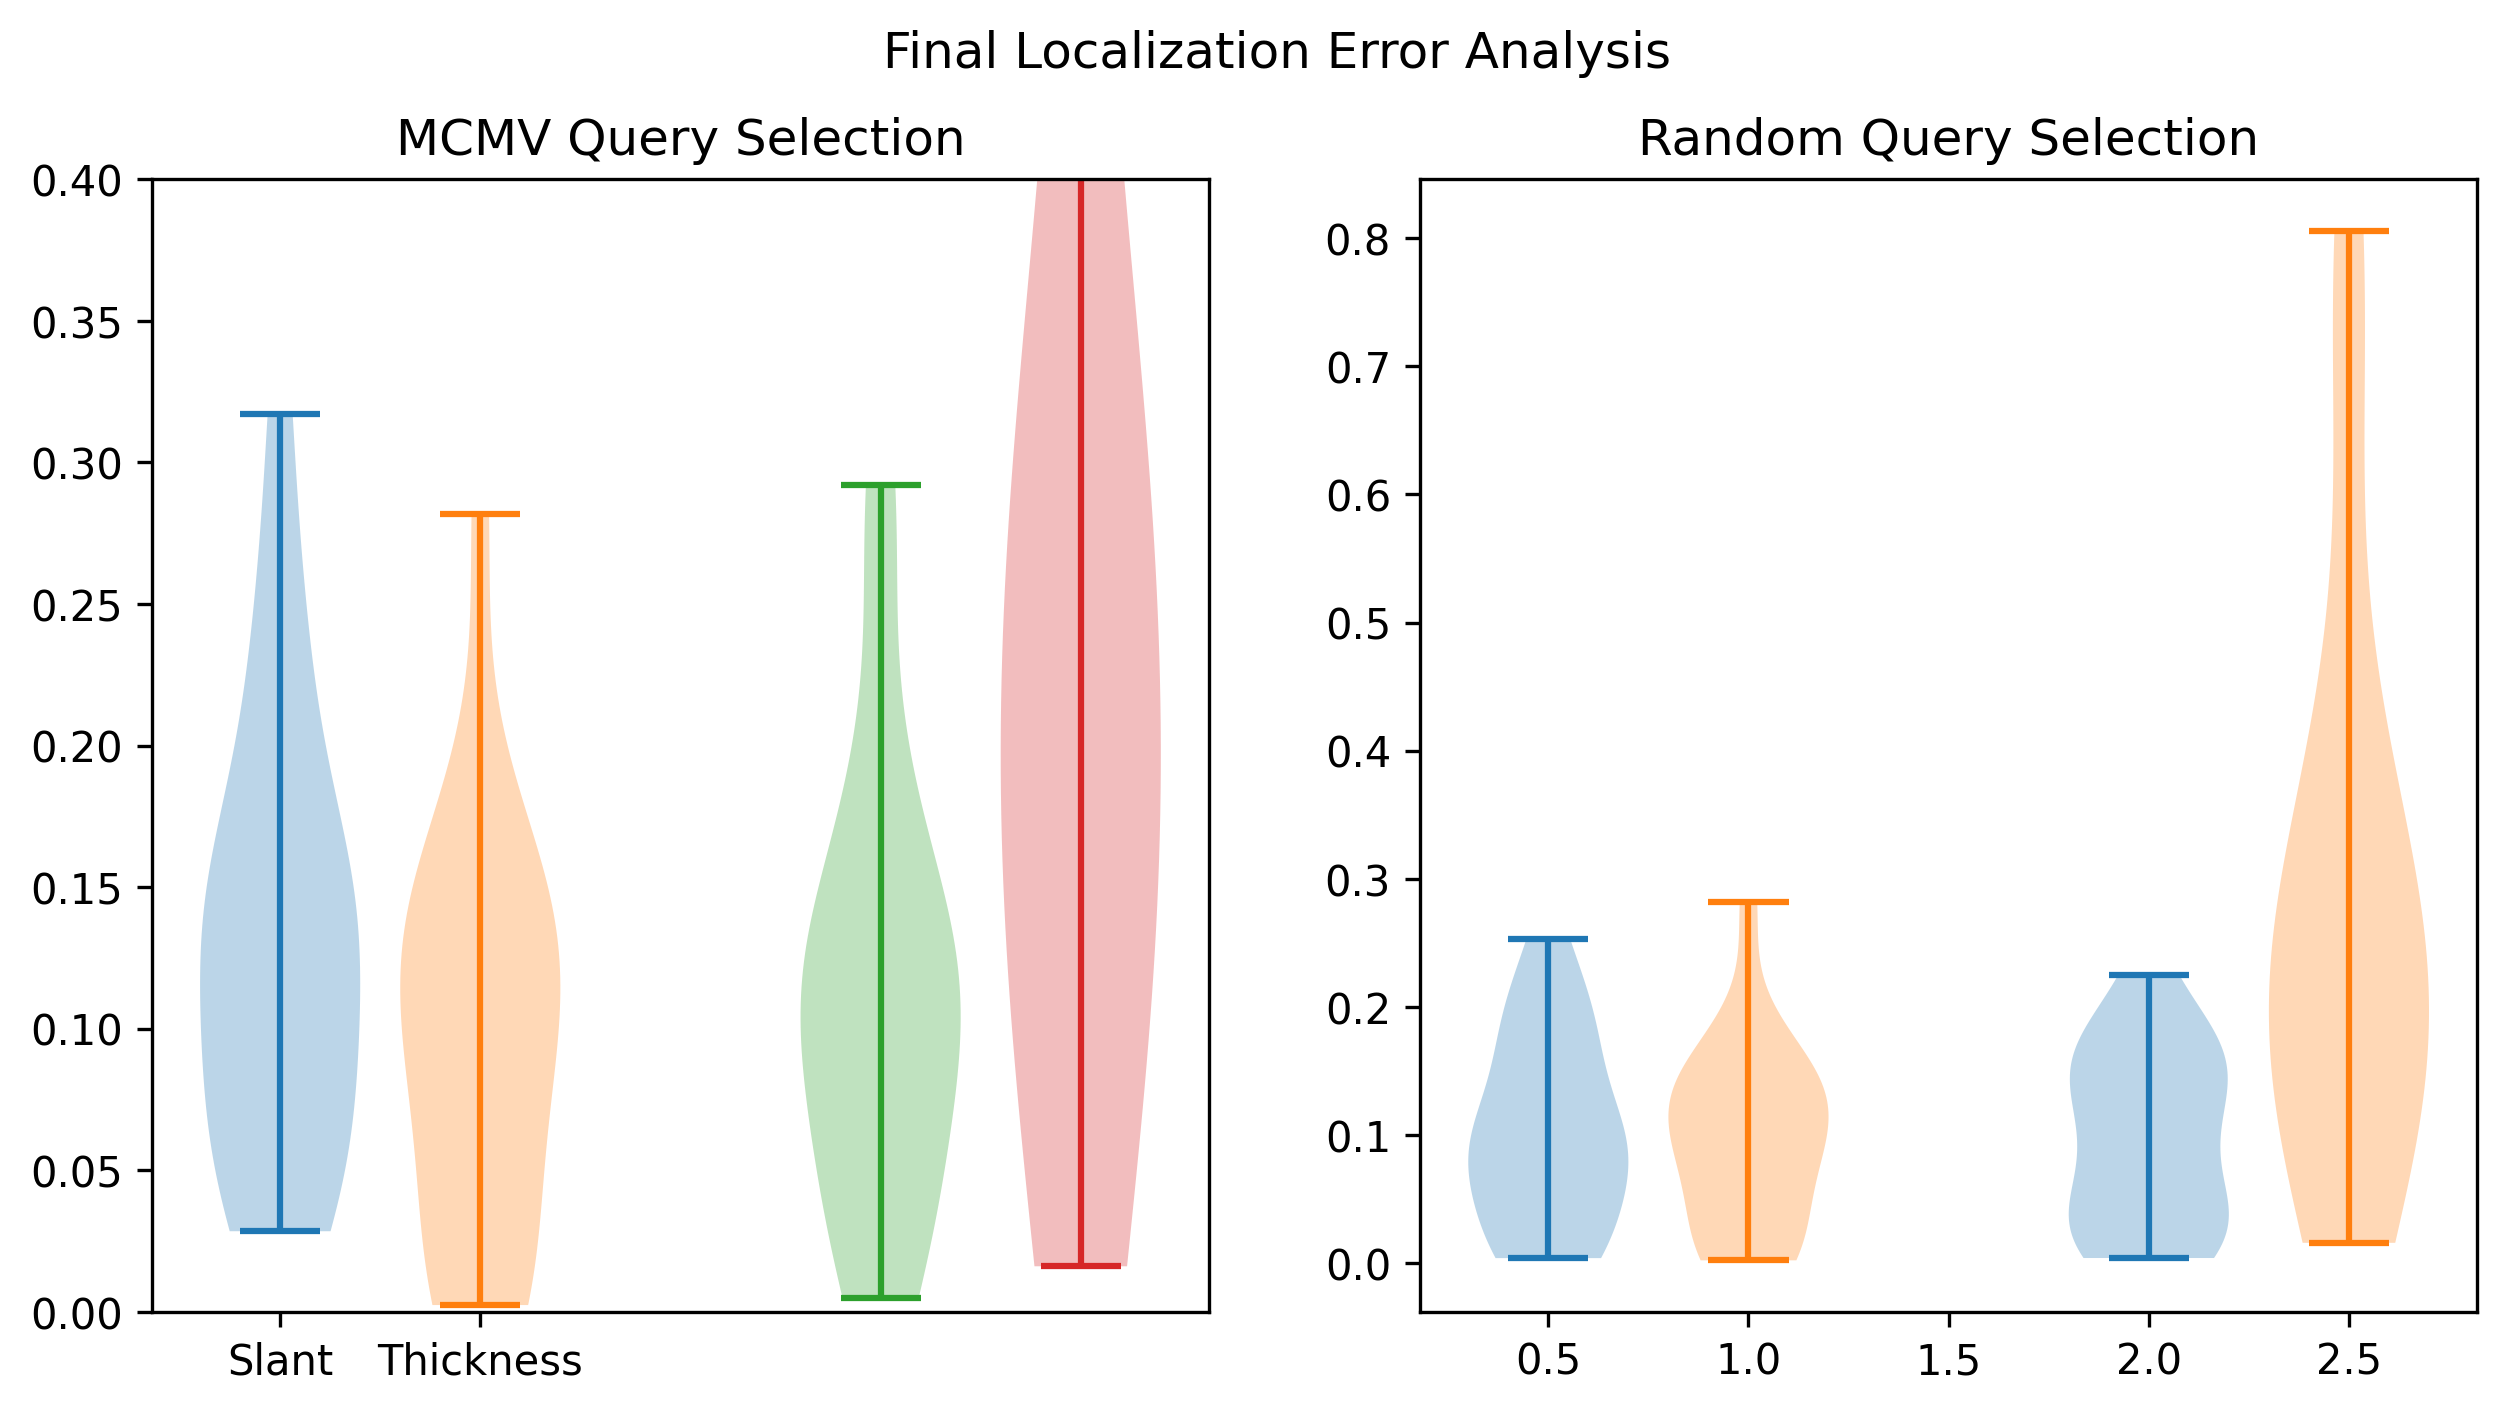

In [105]:
# make the violin plot


# final_rank_correlations is a dictionary that maps
# the model name to a 2D arrays of shape (num_metadata_features, num_trials) 
# holding the final rank correlations
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
feature_names = ["Slant", "Thickness"]
plt.suptitle("Final Localization Error Analysis")
axs[0].set_title("MCMV Query Selection")
xticks = ["Slant", "Thickness"]
xtick_positions = [0.5, 1.0]
axs[0].set_xticks(xtick_positions)
axs[0].set_xticklabels(xticks)
axs[1].set_title("Random Query Selection")
# make violin plot for the model

plt.gca().set_prop_cycle(None)
violin_plot = axs[0].violinplot(triplet_mcmv_vals["slant"], positions=[0.5], widths=0.4)
violin_plot = axs[0].violinplot(no_triplet_mcmv_vals["slant"], positions=[1.0], widths=0.4)
plt.gca().set_prop_cycle(None)
violin_plot = axs[0].violinplot(triplet_mcmv_vals["thickness"], positions=[2.0], widths=0.4)
violin_plot = axs[0].violinplot(no_triplet_mcmv_vals["thickness"], positions=[2.5], widths=0.4)
axs[0].set_ylim(0, 0.4)
# 
plt.gca().set_prop_cycle(None)
violin_plot = axs[1].violinplot(triplet_random_vals["slant"], positions=[0.5], widths=0.4)
violin_plot = axs[1].violinplot(no_triplet_random_vals["slant"], positions=[1.0], widths=0.4)
plt.gca().set_prop_cycle(None)
violin_plot = axs[1].violinplot(triplet_random_vals["thickness"], positions=[2.0], widths=0.4)
violin_plot = axs[1].violinplot(no_triplet_random_vals["thickness"], positions=[2.5], widths=0.4)
"""
violin_plot = plt.violinplot(one_triplet_spearmans_slant, positions=[1.0], widths=0.4)
plt.gca().set_prop_cycle(None)
violin_plot = plt.violinplot(zero_triplet_spearmans_thickness, positions=[2.0], widths=0.4)
violin_plot = plt.violinplot(one_triplet_spearmans_thickness, positions=[2.5], widths=0.4)
# make ticks
xticks = ["Slant", "Thickness"]
xtick_positions = [0.75, 2.25]
plt.xticks(xtick_positions, xticks)
# high level plot info
plt.ylim(0, 1.0)
plt.ylabel("Final Spearman's Coefficients")
plt.xlabel("Feature Names")
plt.title("Rank Correlation of Latent Features\n with MorphoMNIST Metadata Characteristics")
plt.tight_layout()
# make legends
plt.gca().set_prop_cycle(None)
plt.plot([], label="Without Triplets")
plt.plot([], label="With Triplets")
# show plot
plt.legend(loc="lower left")
plt.show()
plt.draw()
plt.savefig("RankCorrelationMetadata.pdf")
"""

### Calculate sample statistics

In [119]:
# load up a basic 2D triplet model
model_dir = "../../../logs/noble-snowball-7399"
feature_index = 2 # thickness
model, config = load_model_and_config(model_dir)
data_manager = setup_data_manager(config)
test_images, embedding_locations, morpho_mnist_metadata = sample_embedding(model, data_manager, num_samples=500)
# run plotting
experiment_config = config

FileNotFoundError: [Errno 2] No such file or directory: '../../../logs/noble-snowball-7399/params.pkl'

In [117]:
print(experiment_config)
experiment_config["trials"] = 5
experiment_config["model_config"]["triplet_beta"] = [0.0, 1.0]

NameError: name 'experiment_config' is not defined

In [118]:
print(config)
hyp_exp = HyperparameterExperiment(experiment_config=experiment_config)
group_directory_list = ["deep-forest-7671", "brisk-resonance-7670", "glamorous-sun-7669", "smart-sunset-7667", "silvery-plasma-7668", "brisk-fog-7674", "youthful-water-7673", "peach-resonance-7672", "soft-grass-7676", "super-sun-7675"]
hyp_exp.load_data(group_directory_list)
# sample mean and sample variance for trial metrics
model_config_localizer_metrics = []
for config_index, config in enumerate(hyp_exp.model_configs):
    # mean across different trials of the same model
    config_metrics = hyp_exp.metrics_map[config_index]
    print(len(config_metrics))
    average_dict, variance_dict = hyp_exp._calculate_summary_localizer_metrics(config_metrics)
    model_config_localizer_metrics.append((average_dict, variance_dict))


{'model_type': 'BasicVAE', 'latent_dim': 2, 'in_shape': 32, 'd': 32, 'layer_count': 4, 'channels': 1, 'loss_name': 'VAETripletLoss', 'kl_beta': 0.01, 'triplet_beta': 1.0, 'triplet_margin': 1.0, 'warm_start': 30, 'kl_max': 0.01, 'triplet_mining': False}


NameError: name 'experiment_config' is not defined

In [114]:
print(len(model_config_localizer_metrics))
print(model_config_localizer_metrics[0])

2
({'metadata_loss': array([0.39862123, 0.3834219 , 0.37694212, 0.37603042, 0.36555474,
       0.36437744, 0.36647955, 0.36449286, 0.35199765, 0.35216292,
       0.34669646, 0.34946681, 0.34880549, 0.34988309, 0.34506555,
       0.33651346, 0.33943872, 0.33746634, 0.33849559, 0.34390256,
       0.33862961, 0.34011068, 0.34034385, 0.34321158, 0.33977758,
       0.34212751, 0.34170708, 0.34335062, 0.34320843, 0.34219823,
       0.34095384, 0.33494901, 0.33802072, 0.3345023 , 0.3381015 ,
       0.33663163, 0.33667874, 0.33452497, 0.3357464 , 0.33488263,
       0.3335919 , 0.33470213, 0.33273227, 0.33298429, 0.33183744,
       0.33245948, 0.32997065, 0.33079689, 0.3344886 , 0.33283465,
       0.33259051]), 'broken_down_metadata_loss': array([[0.        , 0.        , 0.34779802, 0.13695068, 0.        ,
        0.        ],
       [0.        , 0.        , 0.33535983, 0.13031004, 0.        ,
        0.        ],
       [0.        , 0.        , 0.3257322 , 0.13268036, 0.        ,
        0.   

### Plot per metadata characteristic final localization distance

In [51]:
print(triplet_localizer_metrics[0])

{'metadata_loss': [0.3435172488476805, 0.2969932807567908, 0.27027743325399234, 0.3807694835995804, 0.37839782379501413, 0.2983319088650538, 0.3065485993510078, 0.36142835562256137, 0.3084866782377673, 0.3918721657820111, 0.37048580919776175, 0.3357955442935234, 0.3749245667889142, 0.3284576577573578, 0.3598129516733036, 0.4058348033452053, 0.3315572619839232, 0.3722225869527339, 0.4013475320612245, 0.3287486884076923, 0.3256832743056505, 0.14315919858420592, 0.14472751458562383, 0.233667839409693, 0.1431939050136216, 0.14268890404683077, 0.13779476718309727, 0.13896289527029249, 0.25303407809038275, 0.15832857627483246, 0.2380227333286425, 0.14111563512296305, 0.20625464638205693, 0.19974109416103408, 0.23787235668541556, 0.18610336523976578, 0.19624597412767594, 0.15637824966865818, 0.1461811115259884, 0.14604628232271735, 0.14694647894729485, 0.22675815189251652, 0.15230226304085834, 0.1860815915707588, 0.14690685272257284, 0.14946519983678852, 0.1456499770152683, 0.1948810629622092

In [90]:
# separate mcmv and random localization
# evens are mcmv odds are random
mcmv_triplet_localizer_metrics = triplet_localizer_metrics[::2]
triplet_mcmv_vals = {"slant":[], "thickness":[]}
for localizer_index in range(len(mcmv_triplet_localizer_metrics)):
    metrics = mcmv_triplet_localizer_metrics[localizer_index]
    # get final broken_down_metadata_loss
    final_broken_down = metrics["broken_down_metadata_loss"]
    # separate into slant and thickness
    slant = final_broken_down[-1][3]
    thickness = final_broken_down[-1][2]
    # add to mcmv vals
    triplet_mcmv_vals["slant"].append(slant)
    triplet_mcmv_vals["thickness"].append(thickness)
    
random_triplet_localizer_metrics = triplet_localizer_metrics[1::2]
triplet_random_vals = {"slant":[], "thickness":[]}
for localizer_index in range(len(random_triplet_localizer_metrics)):
    metrics = random_triplet_localizer_metrics[localizer_index]
    # get final broken_down_metadata_loss
    final_broken_down = metrics["broken_down_metadata_loss"]
    # separate into slant and thickness
    slant = final_broken_down[-1][3]
    thickness = final_broken_down[-1][2]
    # add to mcmv vals
    triplet_random_vals["slant"].append(slant)
    triplet_random_vals["thickness"].append(thickness)

In [96]:
# separate mcmv and random localization
# evens are mcmv odds are random
mcmv_no_triplet_localizer_metrics = no_triplet_localizer_metrics[::2]
print(mcmv_no_triplet_localizer_metrics)
no_triplet_mcmv_vals = {"slant":[], "thickness":[]}
for localizer_index in range(len(mcmv_no_triplet_localizer_metrics)):
    metrics = mcmv_no_triplet_localizer_metrics[localizer_index]
    # get final broken_down_metadata_loss
    final_broken_down = metrics["broken_down_metadata_loss"]
    # separate into slant and thickness
    slant = final_broken_down[-1][3]
    thickness = final_broken_down[-1][2]
    # add to mcmv vals
    no_triplet_mcmv_vals["slant"].append(slant)
    no_triplet_mcmv_vals["thickness"].append(thickness)
    
random_triplet_localizer_metrics = no_triplet_localizer_metrics[1::2]
no_triplet_random_vals = {"slant":[], "thickness":[]}
for localizer_index in range(len(random_no_triplet_localizer_metrics)):
    metrics = random_no_triplet_localizer_metrics[localizer_index]
    # get final broken_down_metadata_loss
    final_broken_down = metrics["broken_down_metadata_loss"]
    # separate into slant and thickness
    slant = final_broken_down[-1][3]
    thickness = final_broken_down[-1][2]
    # add to mcmv vals
    no_triplet_random_vals["slant"].append(slant)
    no_triplet_random_vals["thickness"].append(thickness)

[{'metadata_loss': [0.14921377918086065, 0.14821213318250226, 0.3046264847921939, 0.09976231458436288, 0.08315117120815775, 0.10617985475089955, 0.13448385448369826, 0.19200324720506318, 0.16959303007776394, 0.18531232703667908, 0.15012129005584254, 0.22547943709967994, 0.2198803011864925, 0.22002397993813078, 0.2072797605687577, 0.16626412775313448, 0.20341187386599346, 0.20622573932943897, 0.17551237625016902, 0.24471256423560622, 0.21368940868541234, 0.214174061640413, 0.20031639236725363, 0.20170702228800158, 0.18530277951797888, 0.24130651075635054, 0.20639136153689672, 0.17874667647071274, 0.2440100254122738, 0.24608017018217368, 0.15607964158366977, 0.1686317929056925, 0.2863978558777572, 0.1606781887009148, 0.24830913812325997, 0.25562997933461185, 0.17793756617150458, 0.2556524571238617, 0.1956540963867351, 0.16994489570309146, 0.2049669891988462, 0.1876527548082193, 0.1973563743678849, 0.1846886930866084, 0.20811914508789217, 0.31264152456923283, 0.21684086374454434, 0.170623

In [97]:
print(no_triplet_mcmv_vals)

{'slant': [0.005011913365468246, 0.04721167078722266, 0.005834016744160175, 0.154202788487233, 0.025243290118546202, 0.124614861969225, 0.013713225420451503, 0.07854355023182641, 0.19150285760714492, 0.08704256531585791, 0.12320922092867342, 0.06958333975875763, 0.15685624579109214, 0.0023942875990949908, 0.12965441305805925, 0.09341739250103054, 0.09964493965233134, 0.1415032309878177, 0.28185511620432263, 0.13983068987457714], 'thickness': [0.19196217382498348, 0.18122258703698435, 0.03884439506881654, 0.763451844662143, 0.5988425738410392, 0.2332281022928559, 0.319673339920723, 0.35250646373899475, 0.24613629696111272, 0.016089533147427892, 0.05679675652264937, 0.4278127933480569, 0.25935566893805784, 0.14074913881542606, 0.0829212599301572, 0.3559199454092402, 0.1801784669022471, 0.13696584185099225, 0.8056614482754887, 0.22740034689128508]}


'\nviolin_plot = plt.violinplot(one_triplet_spearmans_slant, positions=[1.0], widths=0.4)\nplt.gca().set_prop_cycle(None)\nviolin_plot = plt.violinplot(zero_triplet_spearmans_thickness, positions=[2.0], widths=0.4)\nviolin_plot = plt.violinplot(one_triplet_spearmans_thickness, positions=[2.5], widths=0.4)\n# make ticks\nxticks = ["Slant", "Thickness"]\nxtick_positions = [0.75, 2.25]\nplt.xticks(xtick_positions, xticks)\n# high level plot info\nplt.ylim(0, 1.0)\nplt.ylabel("Final Spearman\'s Coefficients")\nplt.xlabel("Feature Names")\nplt.title("Rank Correlation of Latent Features\n with MorphoMNIST Metadata Characteristics")\nplt.tight_layout()\n# make legends\nplt.gca().set_prop_cycle(None)\nplt.plot([], label="Without Triplets")\nplt.plot([], label="With Triplets")\n# show plot\nplt.legend(loc="lower left")\nplt.show()\nplt.draw()\nplt.savefig("RankCorrelationMetadata.pdf")\n'

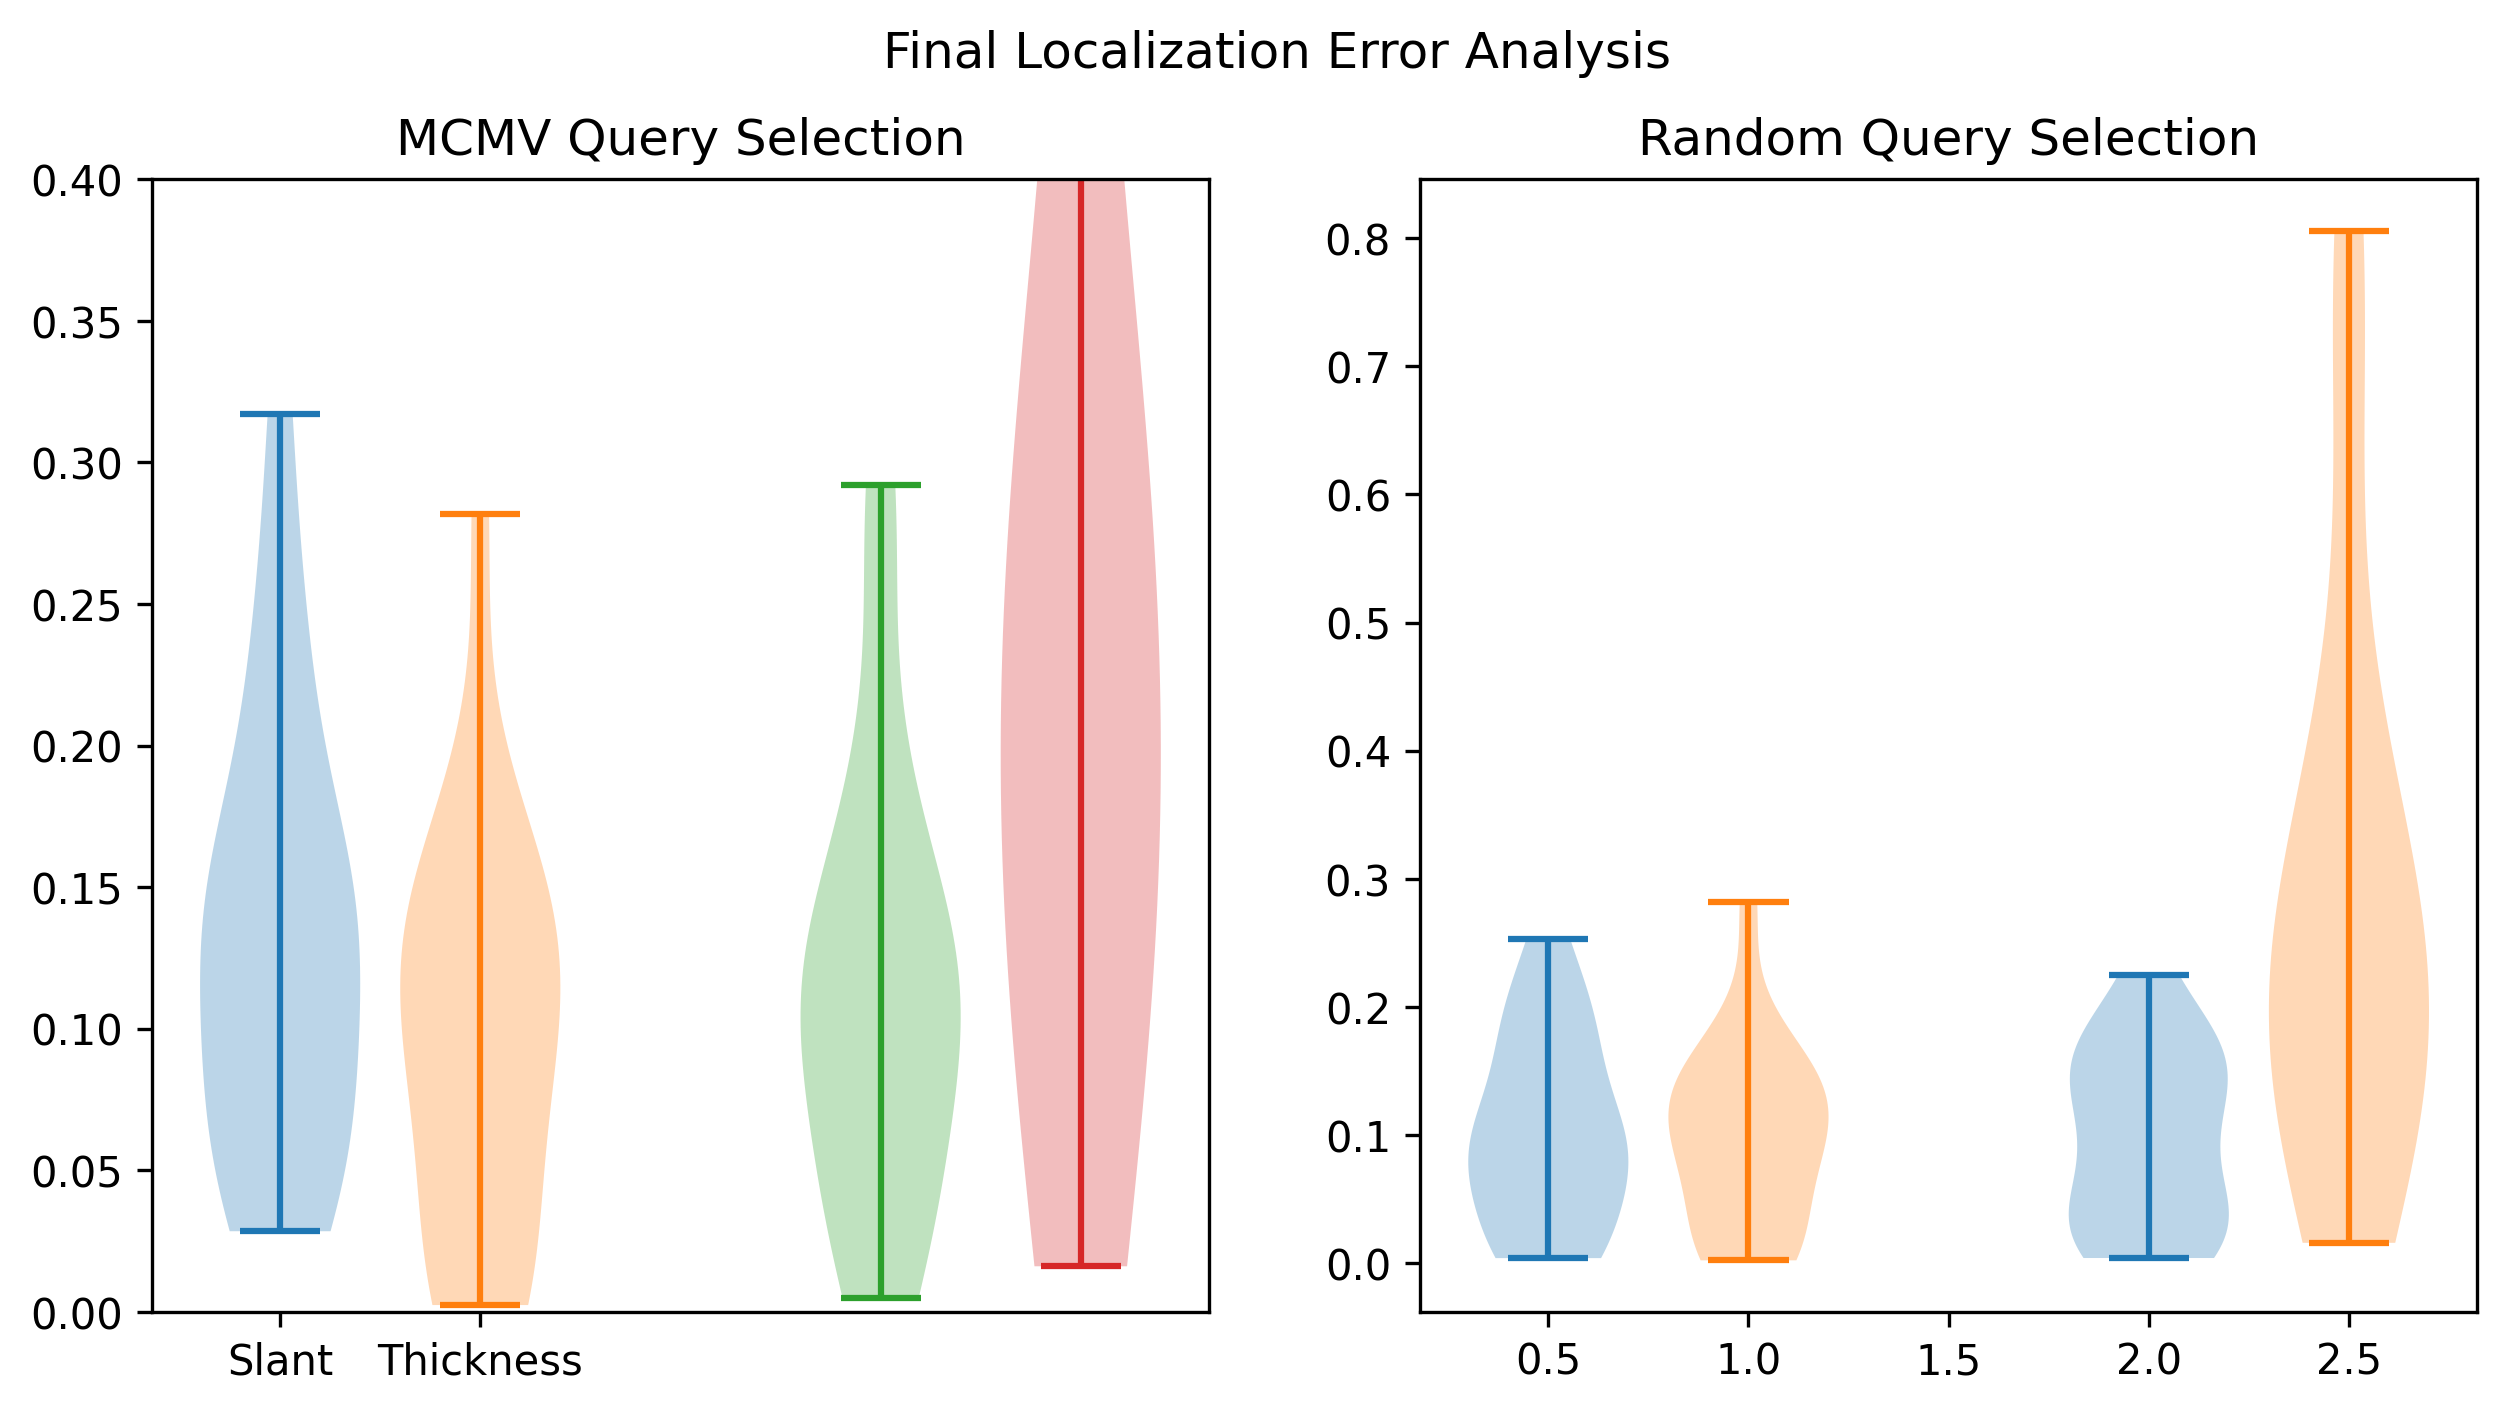

In [105]:
# make the violin plot


# final_rank_correlations is a dictionary that maps
# the model name to a 2D arrays of shape (num_metadata_features, num_trials) 
# holding the final rank correlations
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
feature_names = ["Slant", "Thickness"]
plt.suptitle("Final Localization Error Analysis")
axs[0].set_title("MCMV Query Selection")
xticks = ["Slant", "Thickness"]
xtick_positions = [0.5, 1.0]
axs[0].set_xticks(xtick_positions)
axs[0].set_xticklabels(xticks)
axs[1].set_title("Random Query Selection")
# make violin plot for the model

plt.gca().set_prop_cycle(None)
violin_plot = axs[0].violinplot(triplet_mcmv_vals["slant"], positions=[0.5], widths=0.4)
violin_plot = axs[0].violinplot(no_triplet_mcmv_vals["slant"], positions=[1.0], widths=0.4)
plt.gca().set_prop_cycle(None)
violin_plot = axs[0].violinplot(triplet_mcmv_vals["thickness"], positions=[2.0], widths=0.4)
violin_plot = axs[0].violinplot(no_triplet_mcmv_vals["thickness"], positions=[2.5], widths=0.4)
axs[0].set_ylim(0, 0.4)
# 
plt.gca().set_prop_cycle(None)
violin_plot = axs[1].violinplot(triplet_random_vals["slant"], positions=[0.5], widths=0.4)
violin_plot = axs[1].violinplot(no_triplet_random_vals["slant"], positions=[1.0], widths=0.4)
plt.gca().set_prop_cycle(None)
violin_plot = axs[1].violinplot(triplet_random_vals["thickness"], positions=[2.0], widths=0.4)
violin_plot = axs[1].violinplot(no_triplet_random_vals["thickness"], positions=[2.5], widths=0.4)
"""
violin_plot = plt.violinplot(one_triplet_spearmans_slant, positions=[1.0], widths=0.4)
plt.gca().set_prop_cycle(None)
violin_plot = plt.violinplot(zero_triplet_spearmans_thickness, positions=[2.0], widths=0.4)
violin_plot = plt.violinplot(one_triplet_spearmans_thickness, positions=[2.5], widths=0.4)
# make ticks
xticks = ["Slant", "Thickness"]
xtick_positions = [0.75, 2.25]
plt.xticks(xtick_positions, xticks)
# high level plot info
plt.ylim(0, 1.0)
plt.ylabel("Final Spearman's Coefficients")
plt.xlabel("Feature Names")
plt.title("Rank Correlation of Latent Features\n with MorphoMNIST Metadata Characteristics")
plt.tight_layout()
# make legends
plt.gca().set_prop_cycle(None)
plt.plot([], label="Without Triplets")
plt.plot([], label="With Triplets")
# show plot
plt.legend(loc="lower left")
plt.show()
plt.draw()
plt.savefig("RankCorrelationMetadata.pdf")
"""

# Test reconstruction of metadata

In [94]:
# line wiht best ordering
line = line_with_best_ordering(embedding_locations, morpho_mnist_metadata, feature_index, num_lines=300)
print(line)

NameError: name 'embedding_locations' is not defined

# Runs

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: helblazer811 (use `wandb login --relogin` to force relogin)


unnormalized metadata
Morphometrics(area=39.375, length=21.149494936611667, thickness=1.9390875132151943, slant=0.2911125601885791, width=3.6947053953511713, height=19.595991281599634)
unnormalized metadata
Morphometrics(area=53.3125, length=20.3817279836453, thickness=2.6435554291388197, slant=0.29845526027537556, width=4.395511172575098, height=18.97065174258441)
unnormalized metadata
Morphometrics(area=62.5625, length=23.124368670764586, thickness=2.986846766693401, slant=0.03715587055105054, width=5.010982472877858, height=19.474854631606377)
unnormalized metadata
Morphometrics(area=50.6875, length=22.54594154601839, thickness=2.424282607475105, slant=-0.1425275665434549, width=4.283377237432624, height=19.638827235850023)
unnormalized metadata
Morphometrics(area=42.3125, length=20.674621202458752, thickness=2.156684761313788, slant=-0.17148208442328303, width=3.8257815753606597, height=19.53487507615566)
unnormalized metadata
Morphometrics(area=53.9375, length=22.356601717798213, 

unnormalized metadata
Morphometrics(area=52.8125, length=19.36396103067893, thickness=2.7980439628286686, slant=0.045814226610336406, width=4.192959176141272, height=19.37691409394247)
unnormalized metadata
Morphometrics(area=68.5, length=20.753048327204944, thickness=3.5496866588928477, slant=0.02282779671594521, width=5.002845185501643, height=19.014301386627814)
unnormalized metadata
Morphometrics(area=56.0, length=21.73528137423857, thickness=2.6888820050715814, slant=0.218720668548944, width=4.674584097745626, height=19.60543708669926)
unnormalized metadata
Morphometrics(area=66.875, length=16.69974746830583, thickness=3.6572483076509212, slant=-0.2135040792022889, width=5.057949206291298, height=18.829269453209307)
unnormalized metadata
Morphometrics(area=48.75, length=23.617009357883873, thickness=2.121034763584235, slant=0.6005109405787485, width=4.631845970203397, height=19.44559335090665)
unnormalized metadata
Morphometrics(area=31.25, length=20.6317279836453, thickness=1.657

unnormalized metadata
Morphometrics(area=42.0, length=19.656854249492383, thickness=2.21716389745308, slant=-0.10818879666376875, width=3.796181838497345, height=19.269209818375664)
unnormalized metadata
Morphometrics(area=41.25, length=20.856601717798217, thickness=2.0611465913706857, slant=0.40033728311418354, width=4.1953117773434485, height=18.769831576834118)
unnormalized metadata
Morphometrics(area=59.1875, length=23.69238815542512, thickness=2.825904352982311, slant=0.09223817237835881, width=4.621101439336554, height=19.245279746624355)
unnormalized metadata
Morphometrics(area=47.3125, length=21.838834764831848, thickness=2.313518413371367, slant=-0.01524705281424292, width=4.283698538536443, height=19.73417108924509)
unnormalized metadata
Morphometrics(area=77.0, length=20.3817279836453, thickness=3.771773148730757, slant=-0.11618154275953474, width=5.497808949875454, height=19.445099813717604)
unnormalized metadata
Morphometrics(area=39.6875, length=18.449747468305837, thickn

unnormalized metadata
Morphometrics(area=36.0625, length=20.735281374238575, thickness=1.8942084463612168, slant=0.06718614741955564, width=3.5554605494166474, height=19.46114264849732)
unnormalized metadata
Morphometrics(area=38.6875, length=19.010407640085653, thickness=2.0451480412462764, slant=-0.10831960542516766, width=3.668447584590986, height=19.629992465716413)
unnormalized metadata
Morphometrics(area=36.8125, length=20.23528137423857, thickness=2.0024019856217325, slant=0.10700407623399182, width=3.9232293992838727, height=18.633465817102714)
unnormalized metadata
Morphometrics(area=79.0625, length=19.588834764831844, thickness=3.6094518552067125, slant=0.3108855648636426, width=5.6429629062480124, height=19.54986608053438)
unnormalized metadata
Morphometrics(area=57.1875, length=21.588834764831844, thickness=2.7702794591832083, slant=0.19274434226631573, width=5.617360134077257, height=19.243965114715216)
unnormalized metadata
Morphometrics(area=33.875, length=19.80330085889

unnormalized metadata
Morphometrics(area=43.4375, length=20.8817279836453, thickness=2.202777654339853, slant=-0.0424949112709888, width=4.287388774386022, height=19.375487297518372)
unnormalized metadata
Morphometrics(area=44.6875, length=21.295941546018394, thickness=2.2408937247054186, slant=0.26057188906304646, width=4.042804576383329, height=19.339686270824537)
unnormalized metadata
Morphometrics(area=51.125, length=20.19238815542512, thickness=2.538056861487266, slant=0.2328374331903782, width=4.586650056325617, height=19.636799911740724)
unnormalized metadata
Morphometrics(area=63.375, length=18.61396103067893, thickness=3.2184106862104405, slant=-0.14928024276665455, width=4.91394192382905, height=19.600279100413935)
unnormalized metadata
Morphometrics(area=42.0, length=20.338834764831844, thickness=2.2346506513230904, slant=0.1591420204677877, width=3.970446821053441, height=18.906802789993122)
unnormalized metadata
Morphometrics(area=57.3125, length=19.760407640085656, thickn

unnormalized metadata
Morphometrics(area=53.0625, length=18.717514421272202, thickness=2.7349094257596205, slant=-0.09290443432449107, width=4.755360978219702, height=19.475642582140125)
unnormalized metadata
Morphometrics(area=75.625, length=21.917261889578036, thickness=3.4231608597695375, slant=0.3381692994811995, width=5.844297513056151, height=19.194914167110824)
unnormalized metadata
Morphometrics(area=48.3125, length=19.15685424949238, thickness=2.6378151614332355, slant=-0.08930434615095029, width=4.236580869203799, height=19.064106667974823)
unnormalized metadata
Morphometrics(area=51.0, length=24.485281374238568, thickness=2.342458696928185, slant=-0.02748390418435792, width=6.778077741390748, height=19.47359061653537)
unnormalized metadata
Morphometrics(area=69.4375, length=26.048989873223338, thickness=2.7532835601975347, slant=0.6525167599625499, width=6.660313297960517, height=19.033981488462143)
unnormalized metadata
Morphometrics(area=49.5625, length=20.86396103067893, 

unnormalized metadata
Morphometrics(area=49.0625, length=20.67462120245875, thickness=2.4979475400635396, slant=0.22555162329072737, width=4.241795707096649, height=19.08110429823653)
unnormalized metadata
Morphometrics(area=100.9375, length=35.702795795510774, thickness=3.1179890582721557, slant=0.14939895605544903, width=12.192963551844649, height=18.99542262154131)
unnormalized metadata
Morphometrics(area=47.625, length=18.199747468305834, thickness=2.5922268753573543, slant=0.15489450392295767, width=4.433017711907217, height=18.588880439101764)
unnormalized metadata
Morphometrics(area=61.875, length=19.967514421272206, thickness=3.0701529380363763, slant=0.15735766066480456, width=4.875693604983002, height=19.477614954750823)
unnormalized metadata
Morphometrics(area=62.375, length=24.46015510839149, thickness=2.853030776980215, slant=0.09689390774376583, width=5.083172379313334, height=19.36075884299724)
unnormalized metadata
Morphometrics(area=93.625, length=19.924621202458752, t

unnormalized metadata
Morphometrics(area=61.0625, length=19.649494936611667, thickness=2.9829483714850284, slant=-0.08614230669417286, width=7.195717400385748, height=19.238265190315424)
unnormalized metadata
Morphometrics(area=69.875, length=23.97792206135786, thickness=3.0823290033226396, slant=-0.27358589411216716, width=5.146281569543847, height=19.69165265939479)
unnormalized metadata
Morphometrics(area=44.9375, length=20.96015510839149, thickness=2.164122709464186, slant=0.3700542688238237, width=4.162877179359267, height=19.394949648314093)
unnormalized metadata
Morphometrics(area=70.4375, length=22.96015510839149, thickness=3.340999060062851, slant=-0.03268322965556506, width=5.013495310507317, height=19.779640995156953)
unnormalized metadata
Morphometrics(area=72.0625, length=22.149494936611667, thickness=3.3069863579524497, slant=-0.21711950227746316, width=5.735703112714269, height=19.547425165171585)
unnormalized metadata
Morphometrics(area=30.5625, length=20.19238815542512

unnormalized metadata
Morphometrics(area=39.9375, length=19.821067811865476, thickness=2.112568236838091, slant=0.11643794706109711, width=3.9393961930236827, height=19.505132136592383)
unnormalized metadata
Morphometrics(area=63.5625, length=19.053300858899107, thickness=3.310250101282669, slant=-0.07204542005951589, width=4.864842197464524, height=19.215635194647195)
unnormalized metadata
Morphometrics(area=66.0625, length=19.61396103067893, thickness=3.384092352496166, slant=-0.11002713077013362, width=5.04426652226635, height=19.042960039236632)
unnormalized metadata
Morphometrics(area=39.5, length=20.44238815542512, thickness=2.105867951004027, slant=-0.10963170814397585, width=3.9165547967340544, height=19.237053262969702)
unnormalized metadata
Morphometrics(area=50.5, length=21.94238815542512, thickness=2.4487962094631373, slant=0.26578693939673387, width=4.723818144166398, height=19.262901873924488)
unnormalized metadata
Morphometrics(area=45.4375, length=19.924621202458752, th

unnormalized metadata
Morphometrics(area=43.75, length=20.98528137423857, thickness=2.2170781008054856, slant=0.1532604652793101, width=4.259957106832529, height=19.15679997139126)
unnormalized metadata
Morphometrics(area=60.8125, length=19.6317279836453, thickness=2.990976804320399, slant=0.2953751000485222, width=4.801570006610362, height=19.30898738953927)
unnormalized metadata
Morphometrics(area=44.9375, length=18.32842712474619, thickness=2.447540666447544, slant=0.04250704028661891, width=3.930125206291379, height=19.656840377333587)
unnormalized metadata
Morphometrics(area=42.5625, length=20.321067811865476, thickness=2.2317687330038543, slant=-0.08140722749610335, width=3.798889703605731, height=19.427236696111297)
unnormalized metadata
Morphometrics(area=49.3125, length=19.028174593052025, thickness=2.638319574201988, slant=0.0855072746747164, width=4.276537046571864, height=19.369018196540182)
unnormalized metadata
Morphometrics(area=56.625, length=18.242640687119284, thickne

unnormalized metadata
Morphometrics(area=88.9375, length=38.32411613907042, thickness=2.6779313220113816, slant=-0.028791027199764768, width=12.602890070304896, height=19.929088618787475)
unnormalized metadata
Morphometrics(area=47.3125, length=19.571067811865476, thickness=2.5334521788398567, slant=0.021132715809704574, width=4.225442663466653, height=19.220388934642962)
unnormalized metadata
Morphometrics(area=50.5625, length=22.088834764831844, thickness=2.447933285675477, slant=0.12596694280457732, width=4.751601818979479, height=19.58971744875522)
unnormalized metadata
Morphometrics(area=54.75, length=18.863961030678926, thickness=2.981493977438722, slant=-0.09578158756474198, width=4.484241919529435, height=18.794585033191826)
unnormalized metadata
Morphometrics(area=79.1875, length=19.071067811865476, thickness=3.8416376452389884, slant=0.2880943289084782, width=5.659972127868677, height=19.482743400796227)
unnormalized metadata
Morphometrics(area=70.125, length=20.4675144212722

unnormalized metadata
Morphometrics(area=35.625, length=22.41726188957804, thickness=1.7124578277999956, slant=0.36605810123028204, width=3.8124854566058524, height=19.479400245284435)
unnormalized metadata
Morphometrics(area=60.25, length=17.785533905932738, thickness=3.205080882708009, slant=0.0784927969536502, width=4.530085220822976, height=19.6952804560537)


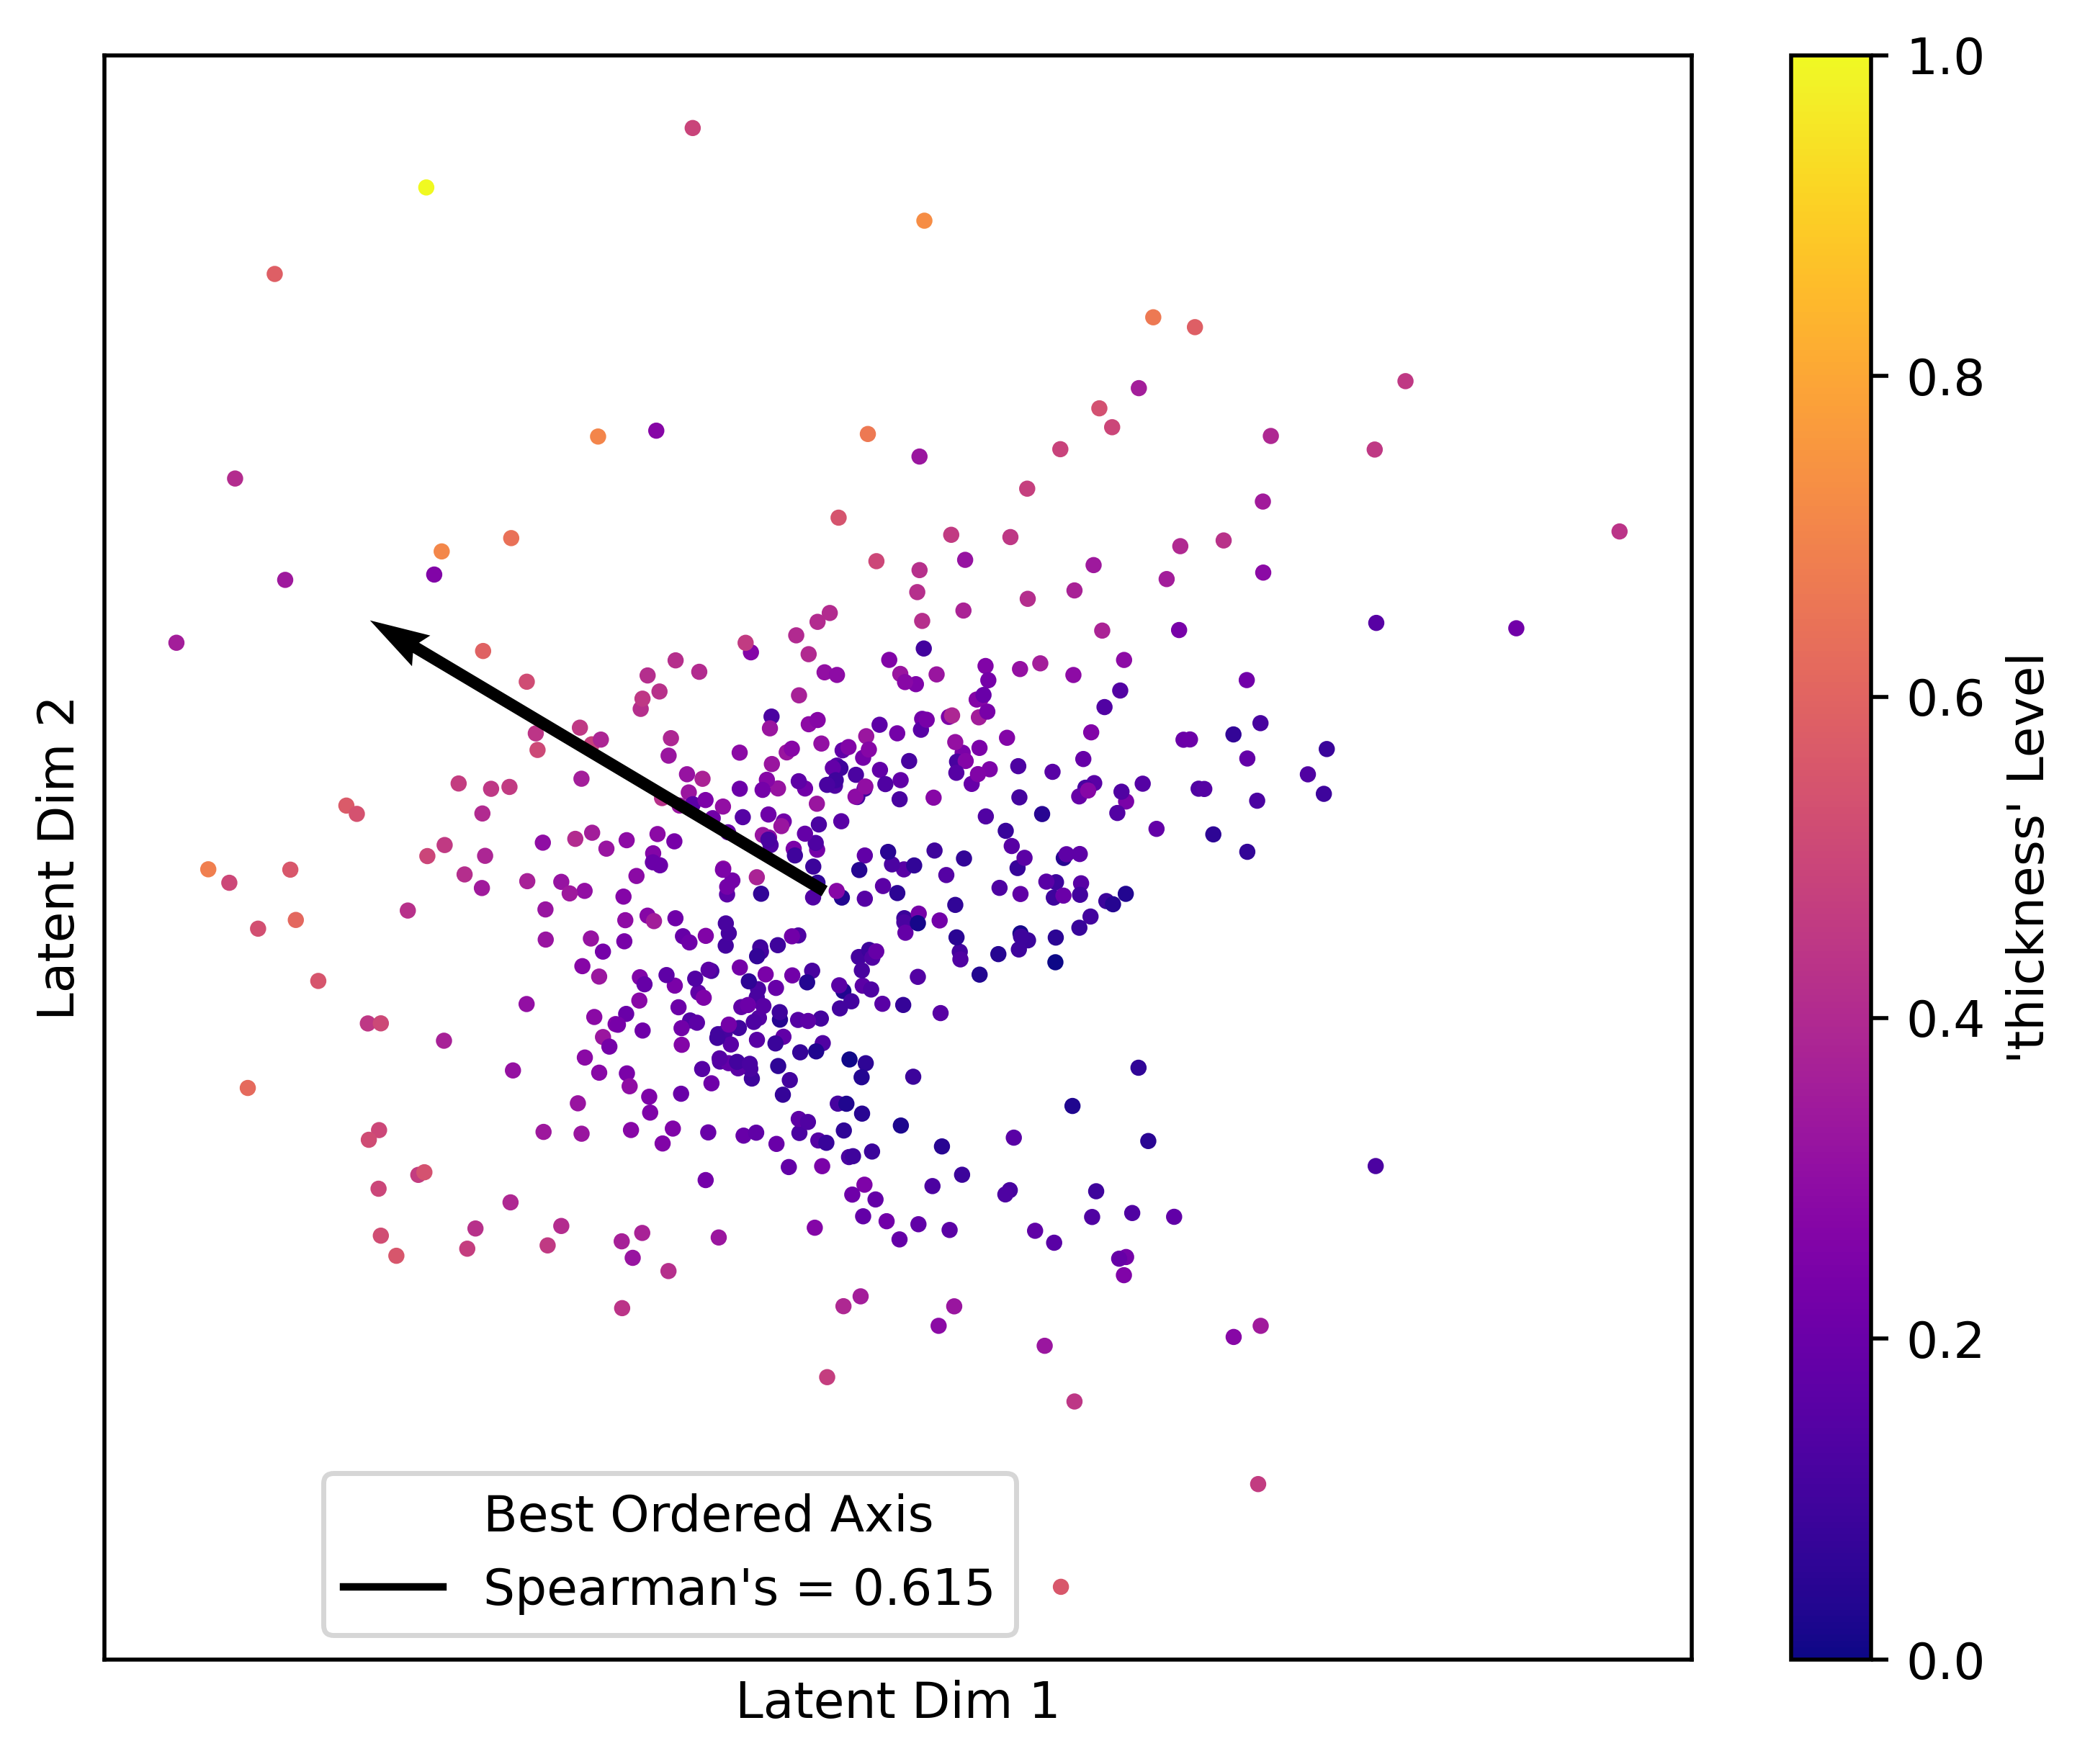

In [95]:
import auto_localization.plotting.disentanglement as disentanglement_plotting
import wandb
feature_index = 2
wandb.init()
disentanglement_plotting.plot_feature_embedding(model, data_manager, feature_index=feature_index)
plt.show()

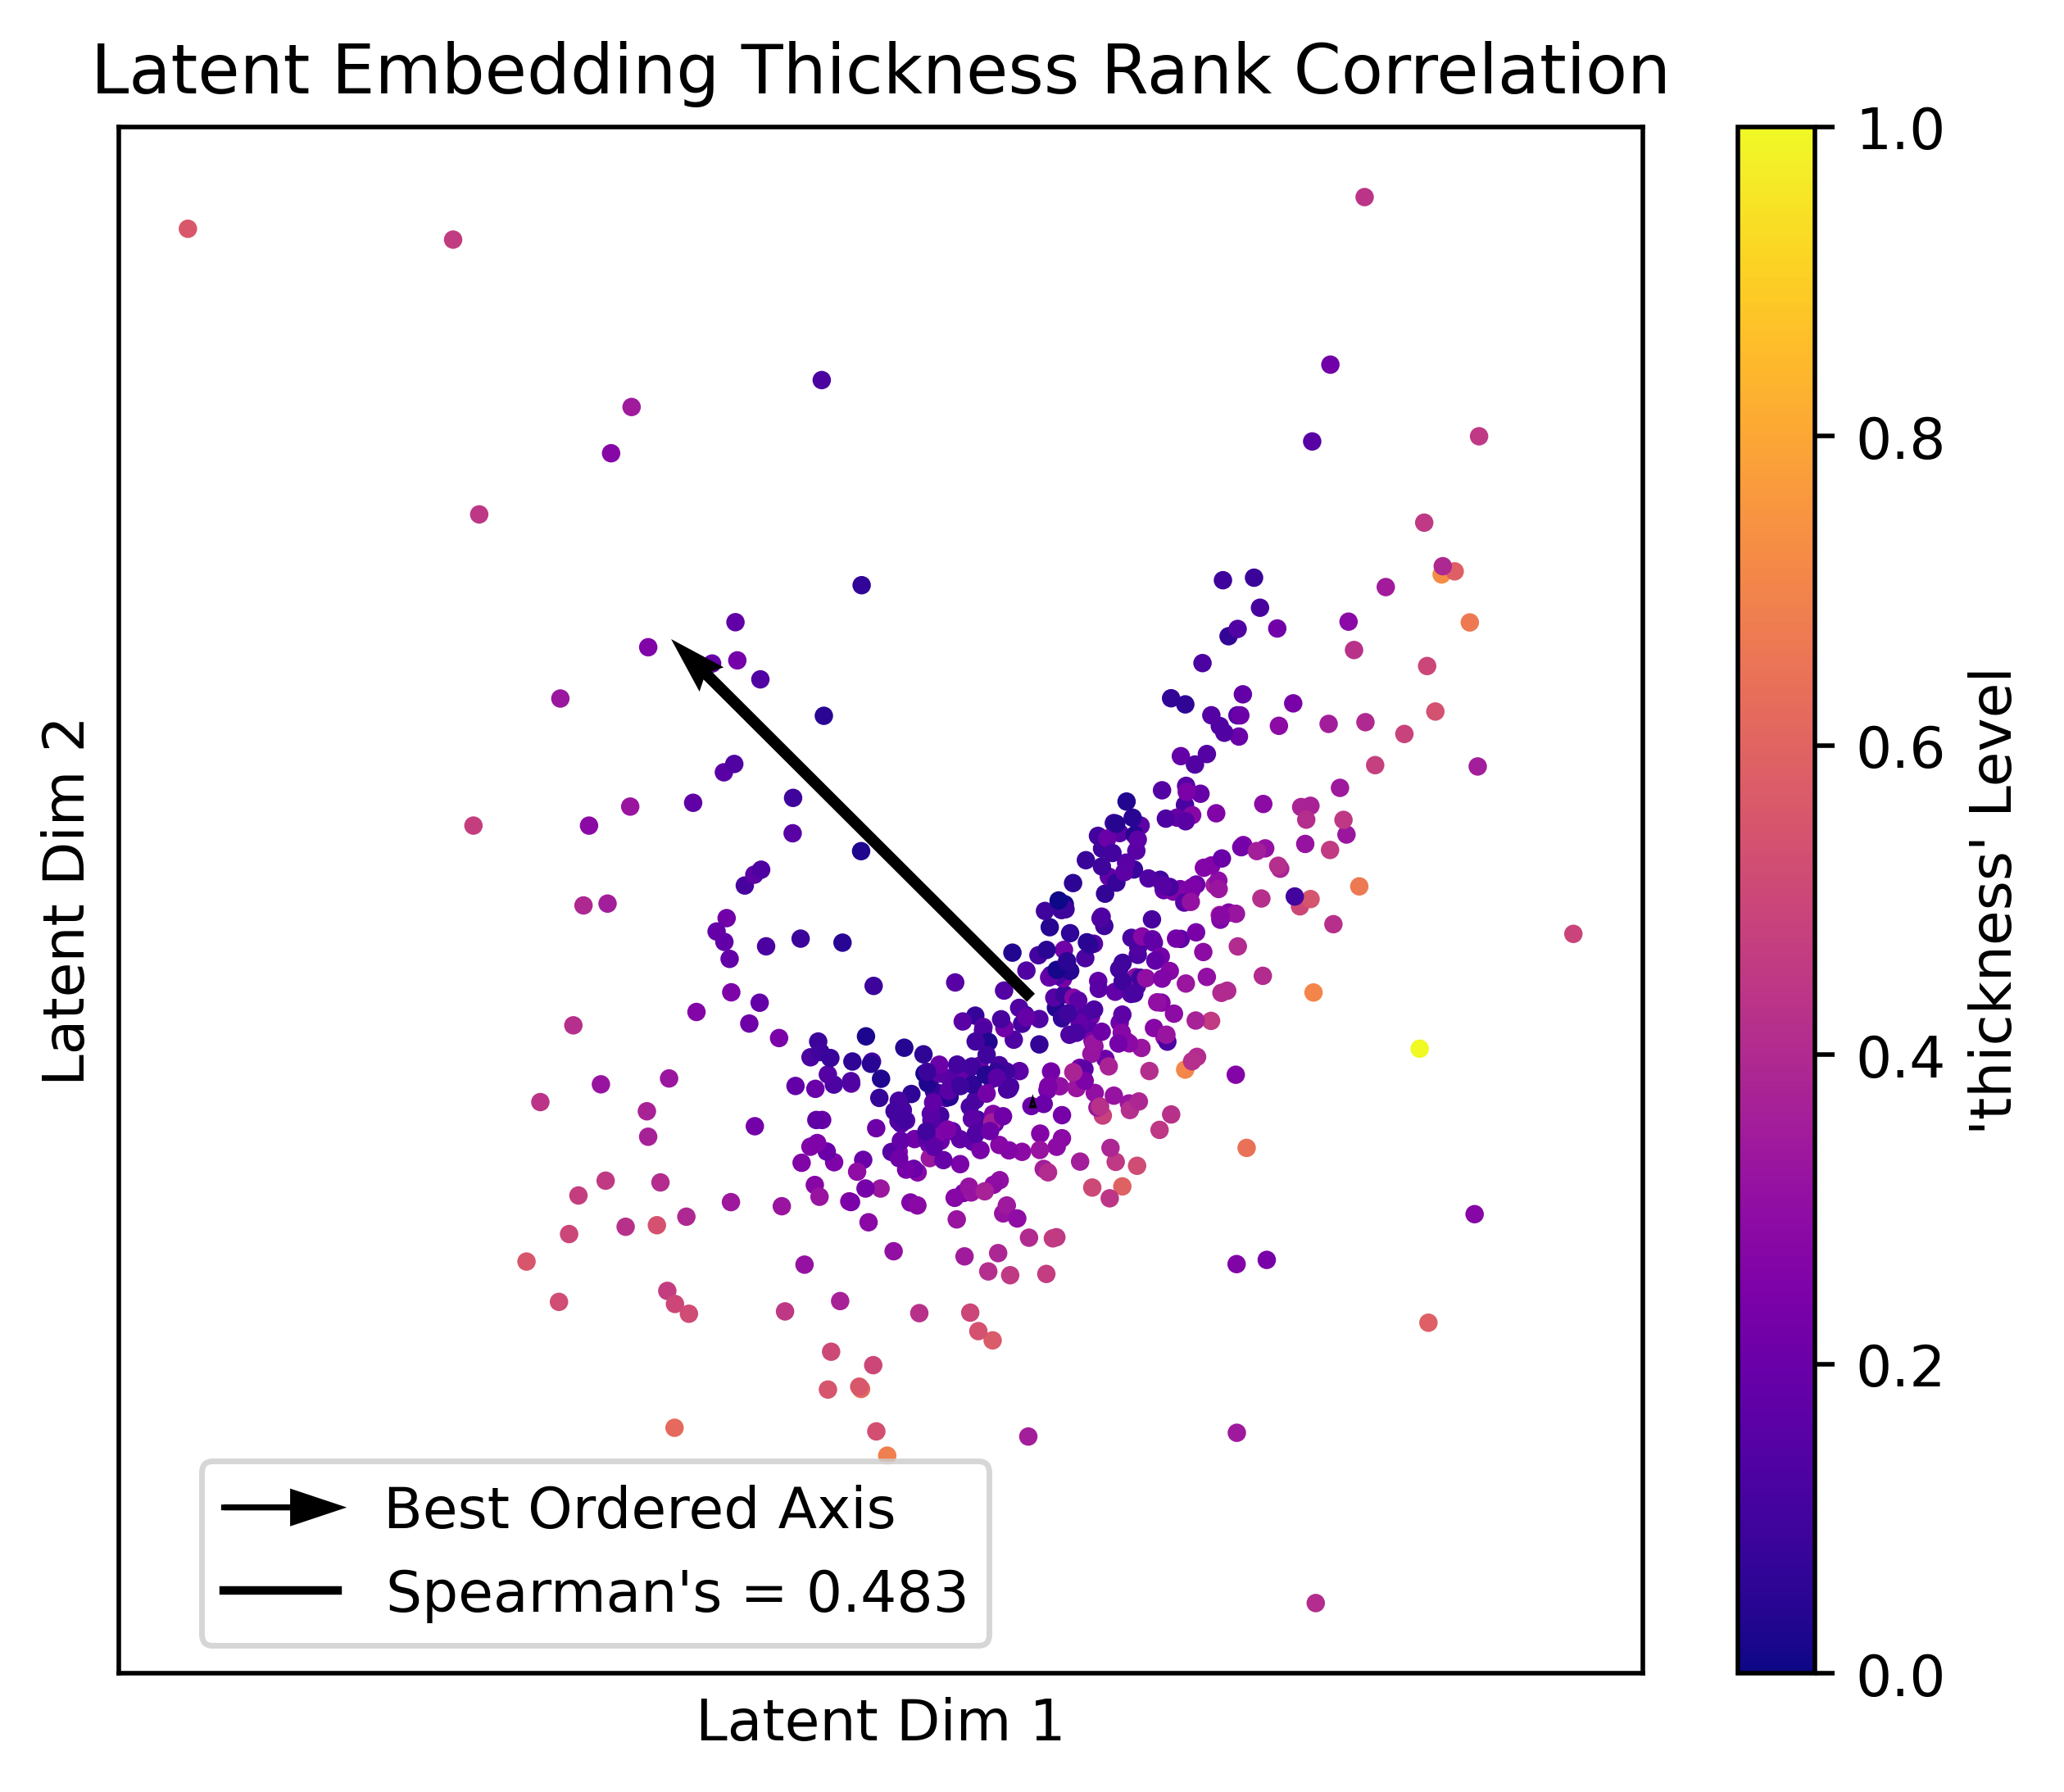

In [18]:
feature_index = 2 # thickness
plot_feature_embedding(embedding_locations, morpho_mnist_metadata, feature_index=feature_index, title="Latent Embedding Thickness Rank Correlation")
plot_image_sampling()

This is a run for a regular model

In [19]:
feature_index = 5 # height

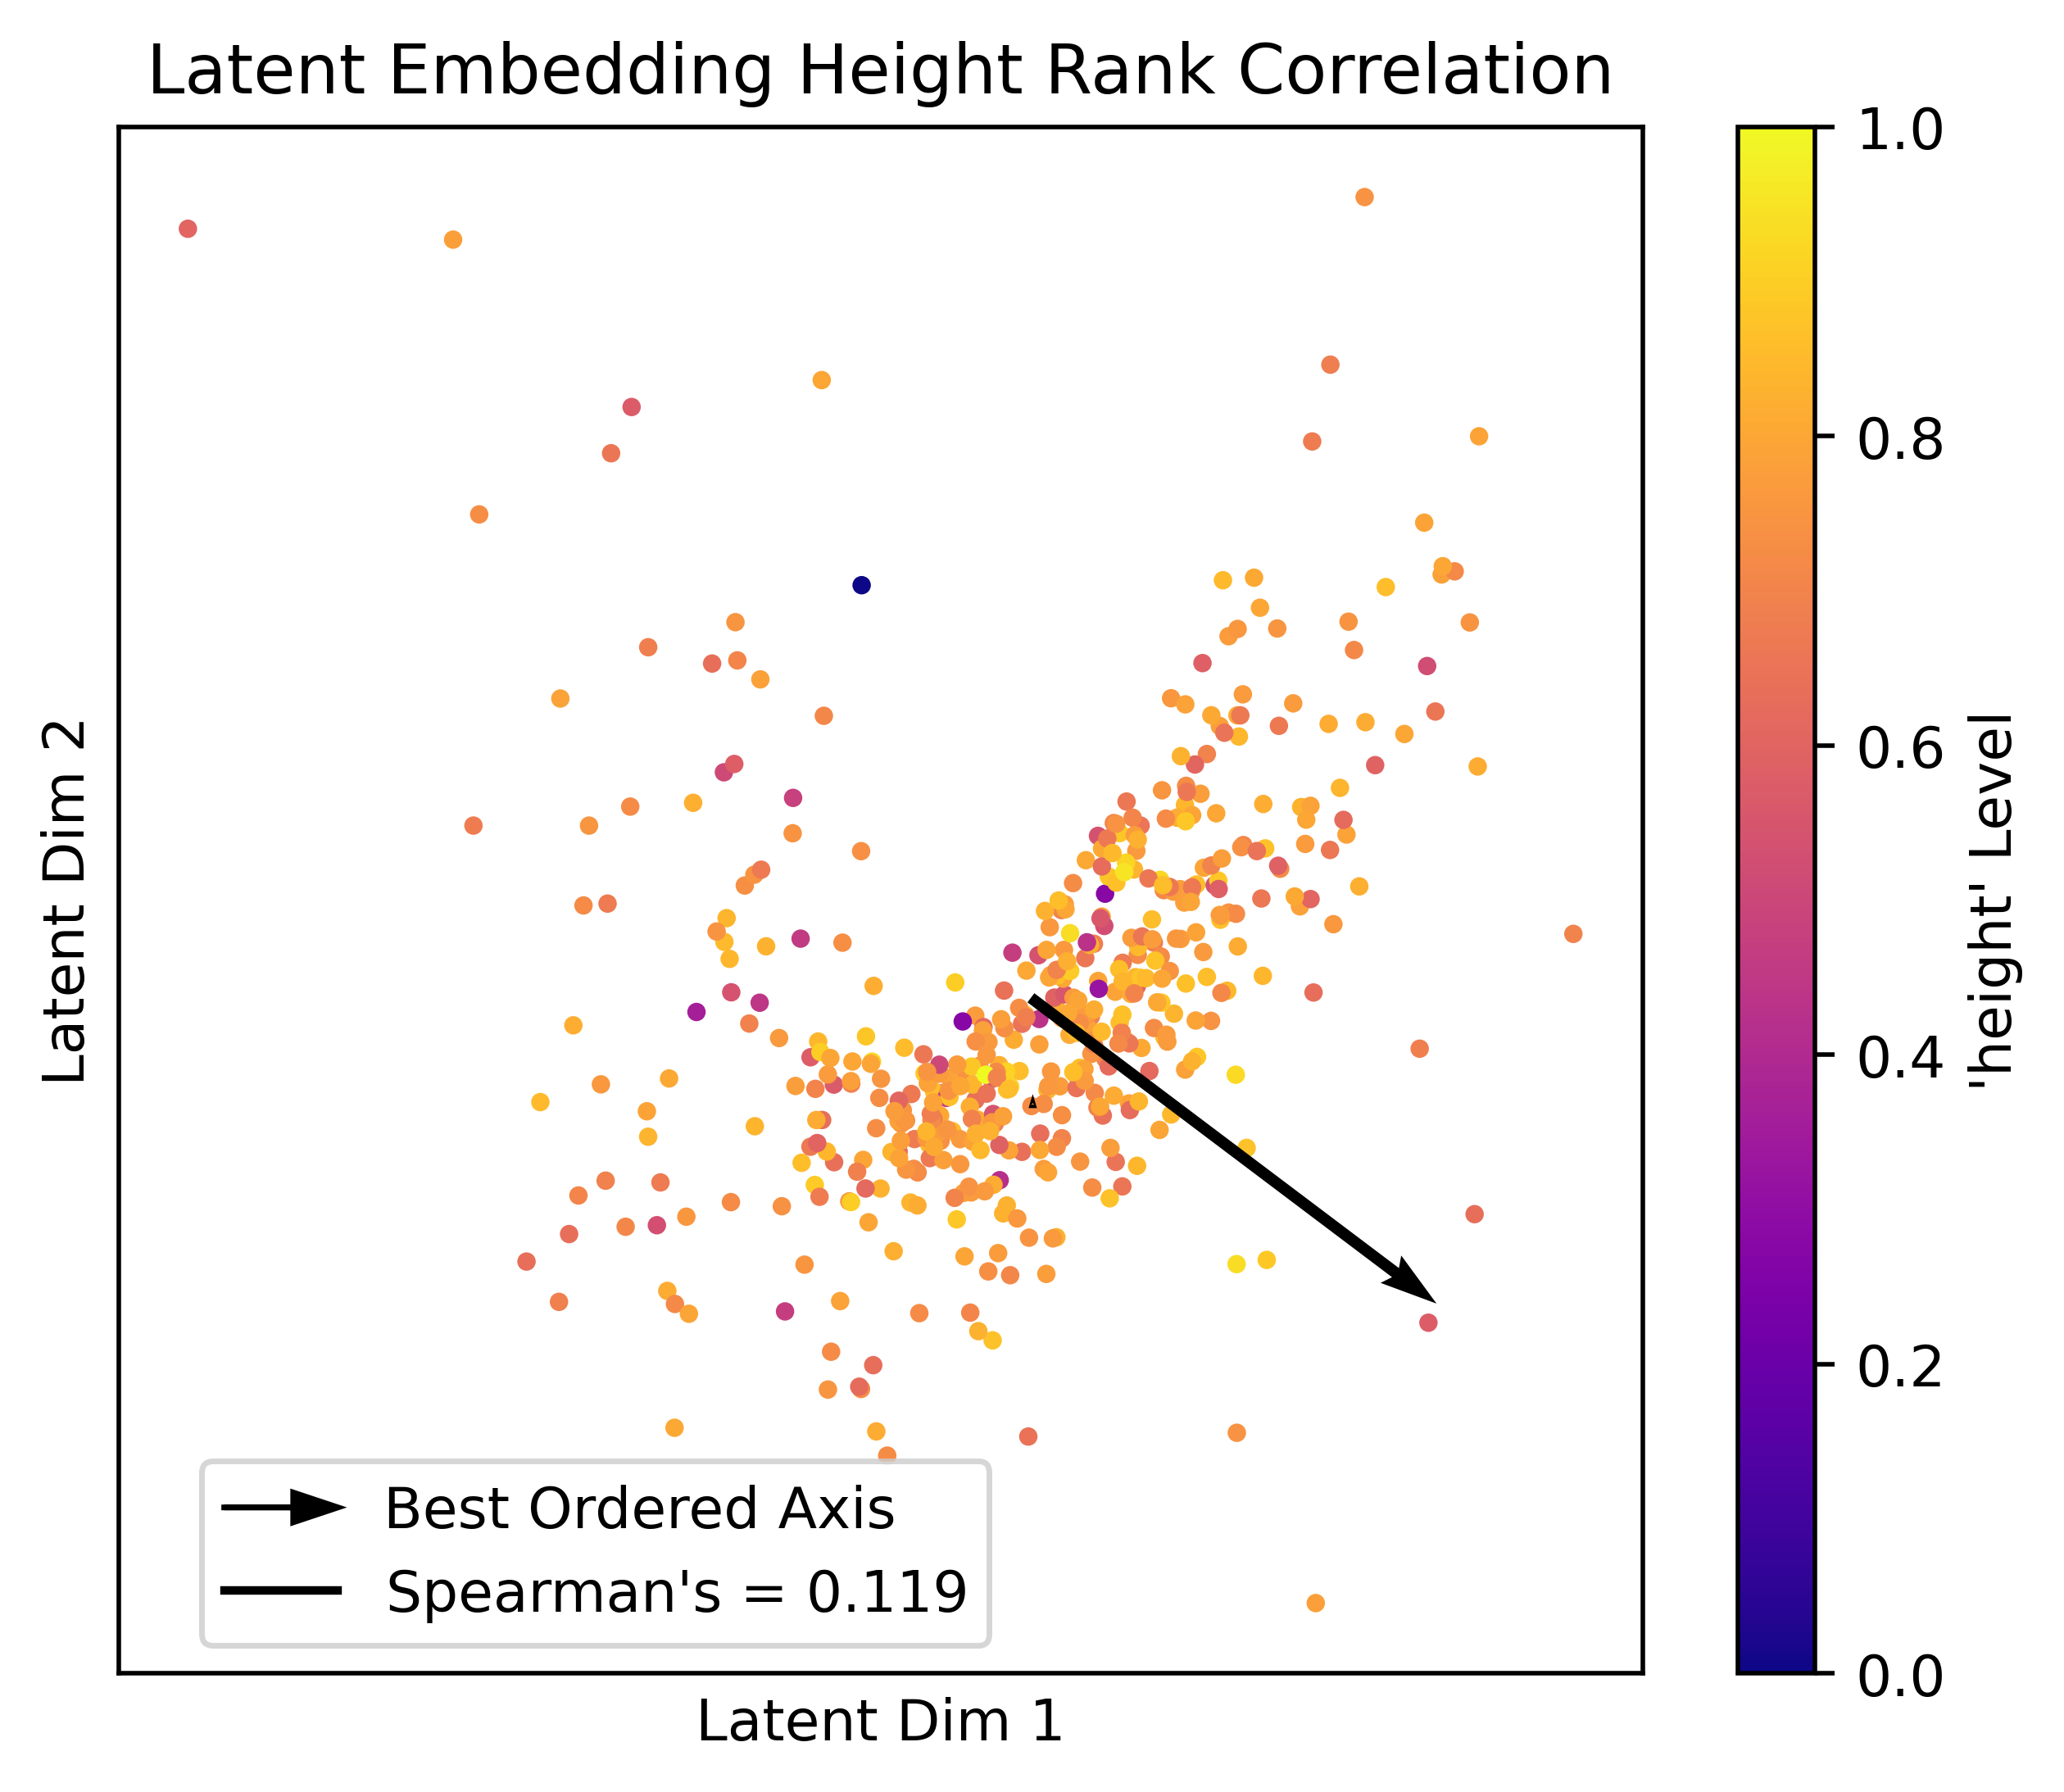

In [20]:
plot_feature_embedding(embedding_locations, morpho_mnist_metadata, feature_index=feature_index, title="Latent Embedding Height Rank Correlation")
plot_image_sampling()

### Image Sampling

In [ ]:
# plot image sampling
fig = image_sampling.plot_binned_tsne_grid_ims(embedding_locations, test_images, num_x_bins=int(10))
plt.ylabel("Latent Dim 2")
plt.xlabel("Latent Dim 1")
plt.show()

### Covariance of Metadata

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'answer_query', 'calculate_metadata', 'calculate_metadata_distance', 'calculate_weighted_metadata', 'component_weighting', 'metadata_dataset']
[0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1.]
[[ 1.          0.26028435  0.90943953  0.21791239  0.68470547  0.01058441]
 [ 0.26028435  1.         -0.13651869  0.25541468  0.63599961  0.06703861]
 [ 0.90943953 -0.13651869  1.          0.05053681  0.43262584 -0.02450532]
 [ 0.21791239  0.25541468  0.05053681  1.          0.10192402  0.00689722]
 [ 0.68470547  0.63599961  0.43262584  0.10192402  1.         -0.08382843]
 [ 0.01058441  0.06703861 -0.02450532  0.00689722 -0.08382843  1.        ]]


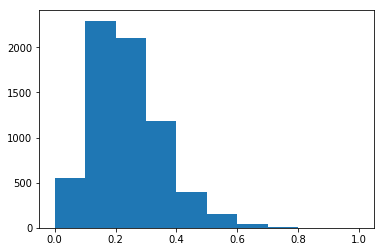

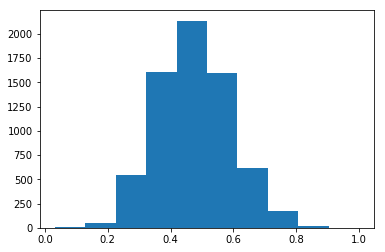

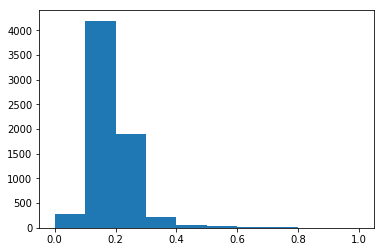

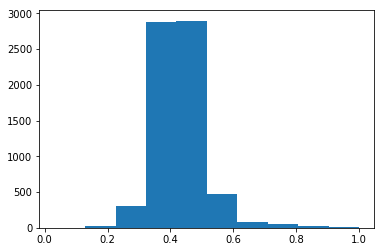

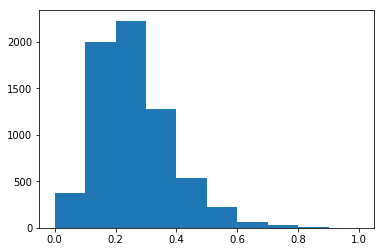

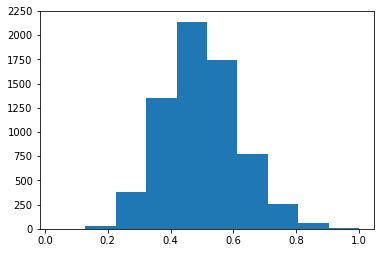

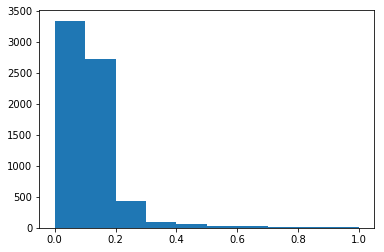

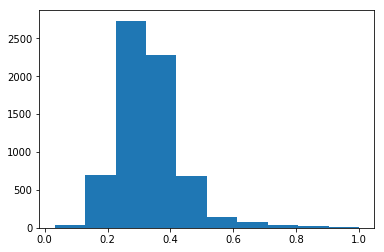

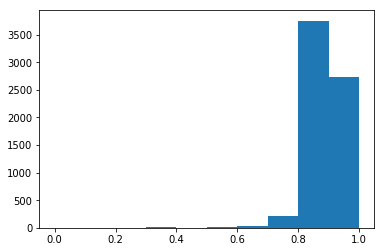

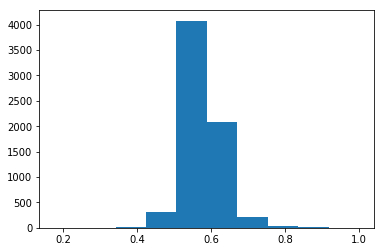

In [41]:
# get metadata
print(dir(data_manager.triplet_train.oracle))
metadata_dataset = data_manager.triplet_train.metadata_dataset
metadata = metadata_dataset[0: len(metadata_dataset)]
print(np.min(metadata, axis=0))
print(np.max(metadata, axis=0))
correlation = np.corrcoef(metadata.T)
print(correlation)
from scipy import stats

#plt.hist(stats.boxcox(metadata[:, 1] + 0.0001))
#plt.show()
#plt.hist(np.log(metadata[:, 1] + 0.001))
#plt.show()
#plt.hist(metadata[:, 2])
#plt.show()
#plt.hist(metadata[:, 3])
#plt.show()
plt.hist(metadata[:, 0])
plt.show()
plt.hist(np.sqrt(metadata[:, 0] + 0.001))
plt.show()

plt.hist(metadata[:, 1])
plt.show()
plt.hist(np.sqrt(metadata[:, 1] + 0.001))
plt.show()

plt.hist(metadata[:, 2])
plt.show()
plt.hist(np.sqrt(metadata[:, 2] + 0.001))
plt.show()

plt.hist(metadata[:, 4])
plt.show()
plt.hist(np.sqrt(metadata[:, 4] + 0.001))
plt.show()

plt.hist(metadata[:, 5])
plt.show()
plt.hist(np.sqrt(np.sqrt(1 - metadata[:, 5] + 0.001)))
plt.show()

### Post Processing

In [152]:
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("helblazer811/latent-space-localization")
summary_list = [] 
config_list = [] 
name_list = [] 
for run in runs: 
    if not run.group == "thickness_height_test_single":
        continue
    # run.summary are the output key/values like accuracy.
    # We call ._json_dict to omit large files 
    summary_obj = run.summary._json_dict
    print(summary_obj)
    summary_obj["triplet_beta"] = run.config["model_config"]["triplet_beta"]
    summary_list.append(summary_obj)
    # run.config is the input metrics.
    # We remove special values that start with _.
    config = {k:v for k,v in run.config.items() if not k.startswith('_')}
    config_list.append(config) 
    # run.name is the name of the run.
    name_list.append(run.name)       

summary_df = pd.DataFrame.from_records(summary_list) 
config_df = pd.DataFrame.from_records(config_list) 
name_df = pd.DataFrame({'name': name_list}) 
all_df = pd.concat([name_df, config_df,summary_df], axis=1)

{'_runtime': 3046, 'feature_area': 0.42058854054470873, 'test_kl_loss': 1.1680832703908284, 'train_recon_loss': 0.05605808060084071, "Colored Feature 'width' Embedding": {'sha256': 'e3a23e6b8fab0d64168a5fe448da5d73837d68d25f44409d20df20dc84c24ae1', 'path': "media/images/Colored Feature 'width' Embedding_405_e3a23e6b.png", 'size': 368565, '_type': 'image-file', 'width': 3000, 'format': 'png', 'height': 2500}, '_step': 411, 'feature_thickness': 0.5219346881632019, 'train_triplet_loss': 0, "Colored Feature 'thickness' Embedding": {'_type': 'image-file', 'width': 3000, 'format': 'png', 'height': 2500, 'sha256': 'e1ed89fa45f950397e0cb53500d7223e9b208cb35bcde10dd1802968acde1ab7', 'path': "media/images/Colored Feature 'thickness' Embedding_403_e1ed89fa.png", 'size': 373595}, 'Reconstructive Sampling': {'size': 112893, '_type': 'image-file', 'width': 400, 'format': 'png', 'height': 4000, 'sha256': 'fe94a3aa7feaabd789751cff8305597640ae91654c927dc6fa6d30de3d44475a', 'path': 'media/images/Reconst

In [15]:
#print(all_df.loc[all_df["triplet_beta"] != 0.0])
print(all_df["feature_thickness"])
feature_thickness = all_df["feature_thickness"].values
feature_thickness = feature_thickness[np.logical_not(np.isnan(feature_thickness))]
print(feature_thickness)
print(len(feature_thickness))

0          NaN
1     0.970223
2     0.976588
3     0.967557
4     0.964631
5     0.975199
6     0.545965
7     0.551595
8     0.457397
9     0.719610
10    0.587225
Name: feature_thickness, dtype: float64
[0.97022278 0.97658774 0.96755653 0.96463072 0.97519884 0.54596473
 0.55159502 0.45739708 0.71960977 0.58722475]
10


In [24]:
df = pd.read_csv("thickness_data.csv")
triplet_pos = []
triplet_zero = []
for col in df.columns:
    if "0.8" in col:
        triplet_pos.append(df[col].values)
    elif "0" in col:
        triplet_zero.append(df[col].values)
pos_mean = np.mean(triplet_pos, axis=0)
print(triplet_pos)
pos_var = np.std(triplet_pos, axis=0)
print(pos_var)
zero_mean = np.mean(triplet_zero, axis=0)
zero_var = np.std(triplet_zero, axis=0)
triplet_pos_thickness = triplet_pos
triplet_zero_thickness = triplet_zero

[array([0.93940288, 0.93576373, 0.95905155, 0.96804764, 0.96648852,
       0.94212025, 0.95204791, 0.91749064, 0.96539028, 0.95365904,
       0.97382771, 0.96824542, 0.94723319, 0.94381982, 0.93705219,
       0.96659474, 0.94706297, 0.95341504, 0.96145957, 0.95605729,
       0.96553428, 0.96594495, 0.9717028 , 0.96891254, 0.9507719 ,
       0.9750095 , 0.97273525, 0.9621498 , 0.97293259, 0.96484405,
       0.97206947, 0.97453527, 0.96626985, 0.97983089, 0.96848587,
       0.9769873 , 0.97048012, 0.97782198, 0.97609751, 0.97090945,
       0.96611073, 0.9729397 , 0.96611473, 0.96074356, 0.97418638,
       0.97277481, 0.97322726, 0.96991567, 0.97547839, 0.97322815]), array([0.91946844, 0.89099257, 0.97895088, 0.95870932, 0.9526217 ,
       0.97728464, 0.96382493, 0.96458583, 0.95115724, 0.9507399 ,
       0.92703074, 0.97496461, 0.96250625, 0.95517728, 0.95715686,
       0.9242476 , 0.96610318, 0.94233625, 0.89034367, 0.94811676,
       0.96749742, 0.95140346, 0.95447594, 0.96568895, 0.94

In [17]:
print(pos_var)

[0.01019993 0.00936687 0.00432157 0.02101762 0.00460297 0.01589163
 0.03788046 0.19884063 0.03411112 0.01872366 0.01292694 0.02206581
 0.04822445 0.02906449 0.00894107 0.02323442 0.01268173 0.01699755
 0.00785496 0.01884779 0.01749081 0.00376941 0.04356708 0.01064037
 0.0390227  0.02305914 0.02905438 0.00749448 0.01821932 0.01986637
 0.00579709 0.01734359 0.0017514  0.01229689 0.0083901  0.00711027
 0.00592936 0.00471222 0.00652096 0.00730514 0.01233437 0.01120529
 0.00458497 0.01276233 0.01018731 0.00907152 0.01162114 0.02569404
 0.00849338 0.00451117]


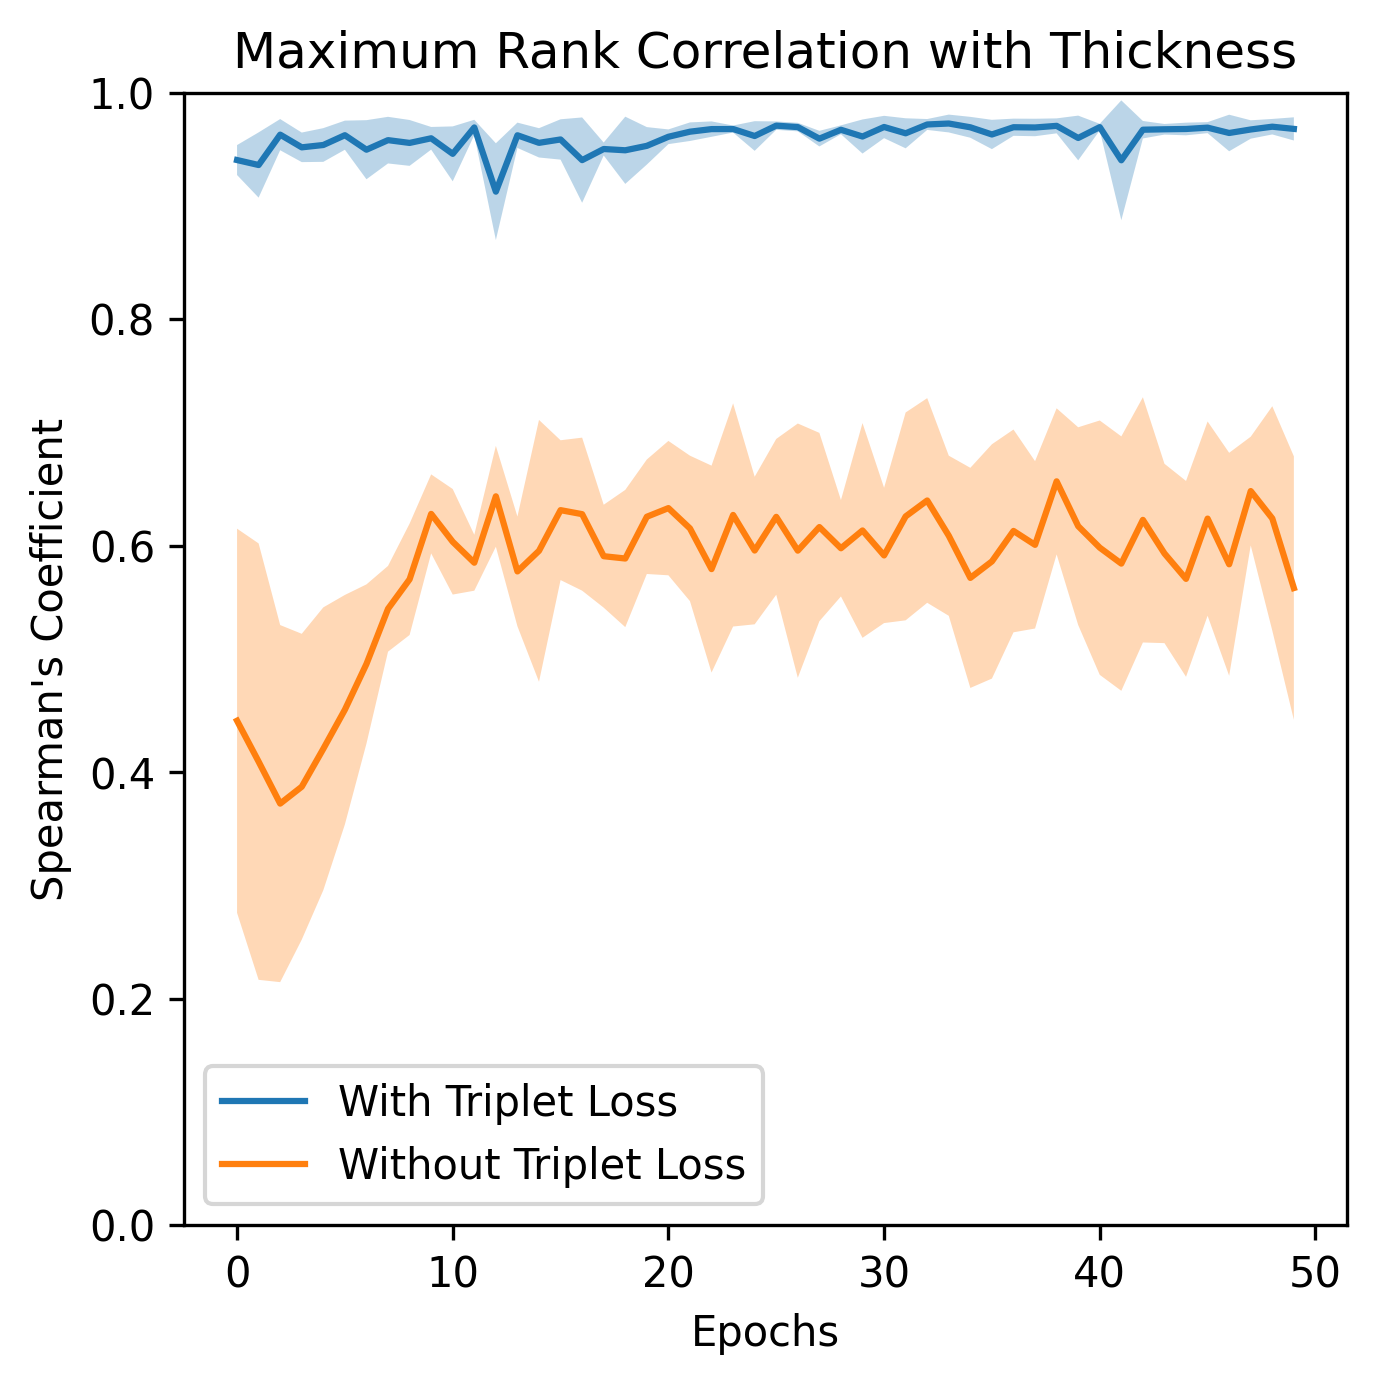

In [25]:
fig = plt.figure(figsize=(5,5), dpi=300)
plt.ylim(0.0, 1.0)
plt.ylabel("Spearman's Coefficient")
plt.xlabel("Epochs")
plt.title("Maximum Rank Correlation with Thickness")
plt.plot(pos_mean, label="With Triplet Loss")
plt.fill_between(np.arange(0, 50), pos_mean - pos_var, pos_mean + pos_var, alpha=0.3)
plt.plot(zero_mean, label="Without Triplet Loss")
plt.fill_between(np.arange(0, 50), zero_mean - zero_var, zero_mean + zero_var, alpha=0.3)
plt.legend()
plt.show()

[array([0.13023211, 0.26917544, 0.32059245, 0.44250803, 0.44055378,
       0.75586751, 0.80026134, 0.83635818, 0.90941099, 0.87538884,
       0.85215658, 0.87803242, 0.91264081, 0.85763531, 0.94724919,
       0.87373326, 0.90712252, 0.93513706, 0.92651652, 0.89853621,
       0.93042367, 0.95714975, 0.94076245, 0.93632863, 0.93332459,
       0.92666852, 0.93962822, 0.95259947, 0.86073712, 0.92467339,
       0.90608207, 0.94491228, 0.91389327, 0.91275859, 0.91974311,
       0.93225614, 0.92179158, 0.93133301, 0.93460061, 0.92733653,
       0.90375138, 0.91450838, 0.92700097, 0.92414271, 0.94483361,
       0.9477532 , 0.94480383, 0.93715619, 0.92496894, 0.94183491]), array([0.21153346, 0.21053523, 0.1225947 , 0.26180646, 0.29153657,
       0.38031178, 0.30079712, 0.46365982, 0.61983044, 0.62575051,
       0.7458954 , 0.83227191, 0.86553717, 0.8081112 , 0.88805076,
       0.92073156, 0.90553317, 0.91026611, 0.87870399, 0.87754086,
       0.85244058, 0.92974544, 0.920284  , 0.88430449, 0.83

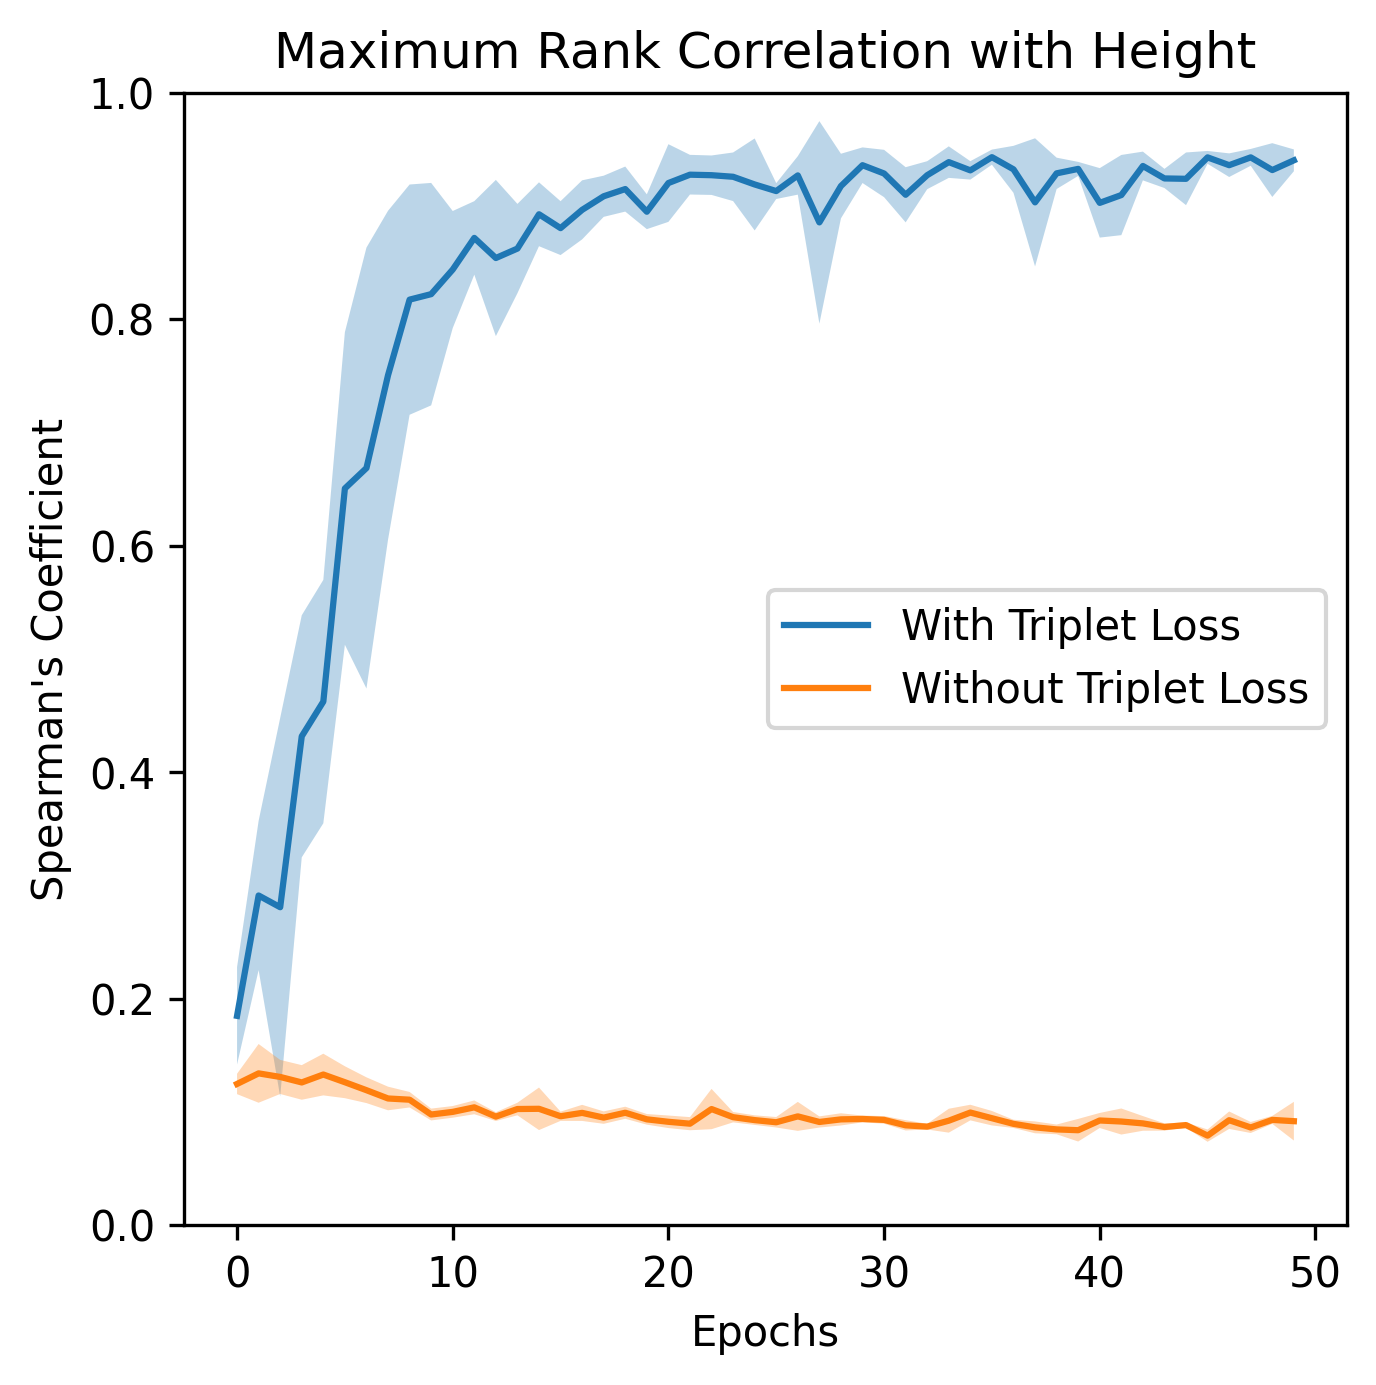

In [26]:
df = pd.read_csv("height_data.csv")
triplet_pos = []
triplet_zero = []
for col in df.columns:
    if "0.8" in col:
        triplet_pos.append(df[col].values)
    elif "0" in col:
        triplet_zero.append(df[col].values)
pos_mean = np.mean(triplet_pos, axis=0)
print(triplet_pos)
triplet_pos_height = triplet_pos
triplet_zero_height = triplet_zero
pos_var = np.std(triplet_pos, axis=0)
zero_mean = np.mean(triplet_zero, axis=0)
zero_var = np.std(triplet_zero, axis=0)


fig = plt.figure(figsize=(5,5), dpi=300)
plt.ylim(0.0, 1.0)
plt.ylabel("Spearman's Coefficient")
plt.xlabel("Epochs")
plt.title("Maximum Rank Correlation with Height")
plt.plot(pos_mean, label="With Triplet Loss")
plt.fill_between(np.arange(0, 50), pos_mean - pos_var, pos_mean + pos_var, alpha=0.3)
plt.plot(zero_mean, label="Without Triplet Loss")
plt.fill_between(np.arange(0, 50), zero_mean - zero_var, zero_mean + zero_var, alpha=0.3)
plt.legend()
plt.show()

### Final Metadata Correlation

In [50]:
# format the data from the above experiments to fit the desired input format
triplet_zero_thickness = np.array(triplet_zero_thickness)
triplet_zero_height = np.array(triplet_zero_height)
triplet_pos_thickness = np.array(triplet_pos_thickness)
triplet_pos_height = np.array(triplet_pos_height)
thickness_zero_last = triplet_zero_thickness[:, -1]
thickness_pos_last = triplet_pos_thickness[:, -1]
height_zero_last = triplet_zero_height[:, -1]
height_pos_last = triplet_pos_height[:, -1]
final_rank_correlations = {
    "Triplet VAE": {
        "thickness": thickness_pos_last,
        "height": height_pos_last
    },
    "Normal VAE": {
        "thickness": thickness_zero_last,
        "height": height_zero_last
    },
}
print(final_rank_correlations)

{'Triplet VAE': {'thickness': array([0.97322815, 0.98008422, 0.9675752 , 0.94935944, 0.969765  ]), 'height': array([0.94183491, 0.92315826, 0.94749497, 0.93797353, 0.95082345])}, 'Normal VAE': {'thickness': array([0.67147768, 0.55889688, 0.52193469, 0.36898232, 0.69154768]), 'height': array([0.09408949, 0.07796753, 0.08105023, 0.1241876 , 0.08183291])}}


In [150]:
"""
    This plots a violin plot of the final rank correlation of the line of best order
    fit with each of the metadata characteristics. It compares various approaches
"""
def plot_final_rank_correlation_ablation(final_rank_correlations):
    # final_rank_correlations is a dictionary that maps
    # the model name to a 2D arrays of shape (num_metadata_features, num_trials) 
    # holding the final rank correlations
    fig = plt.figure(figsize=(5, 5), dpi=300)
    feature_names = []
    model_types = []
    for model_type in final_rank_correlations.keys():
        model_finals = final_rank_correlations[model_type]
        model_types.append(model_type)
        feature_names = []
        for feature_name in model_finals.keys():
            feature_names.append(feature_name)
    print(model_types)
    # make violin plot for the model
    offset = 0.0
    offset_change = 0.8
    spacing = 1.2 * len(model_types)
    for model_type in final_rank_correlations.keys():
        # get each feature last correlations
        model_finals = final_rank_correlations[model_type].values()
        # plt the violin plots
        violin_plot = plt.violinplot(model_finals, positions=np.arange(len(feature_names))*spacing+offset, widths=0.6)
        offset += offset_change
    # make ticks
    xticks = []
    xtick_positions = []
    position = 0.0
    for index, feature_name in enumerate(feature_names):
        position = offset_change * (len(model_types) - 1) / 2 + spacing * index
        xtick_positions.append(position)
        xticks.append(feature_name)
    plt.xticks(xtick_positions, xticks)
    # high level plot info
    plt.ylim(0, 1.0)
    plt.ylabel("Final Spearman's Coefficients")
    plt.xlabel("Feature Names")
    plt.title("Best Rank Correlation of Latent Features\n with MorphoMNIST Metadata Characteristics")
    plt.tight_layout()
    # make legends
    plt.gca().set_prop_cycle(None)
    for model_type in model_types:
        plt.plot([], label=model_type)
    # show plot
    plt.legend(loc="lower left")
    plt.show()

['Triplet VAE', 'Normal VAE']


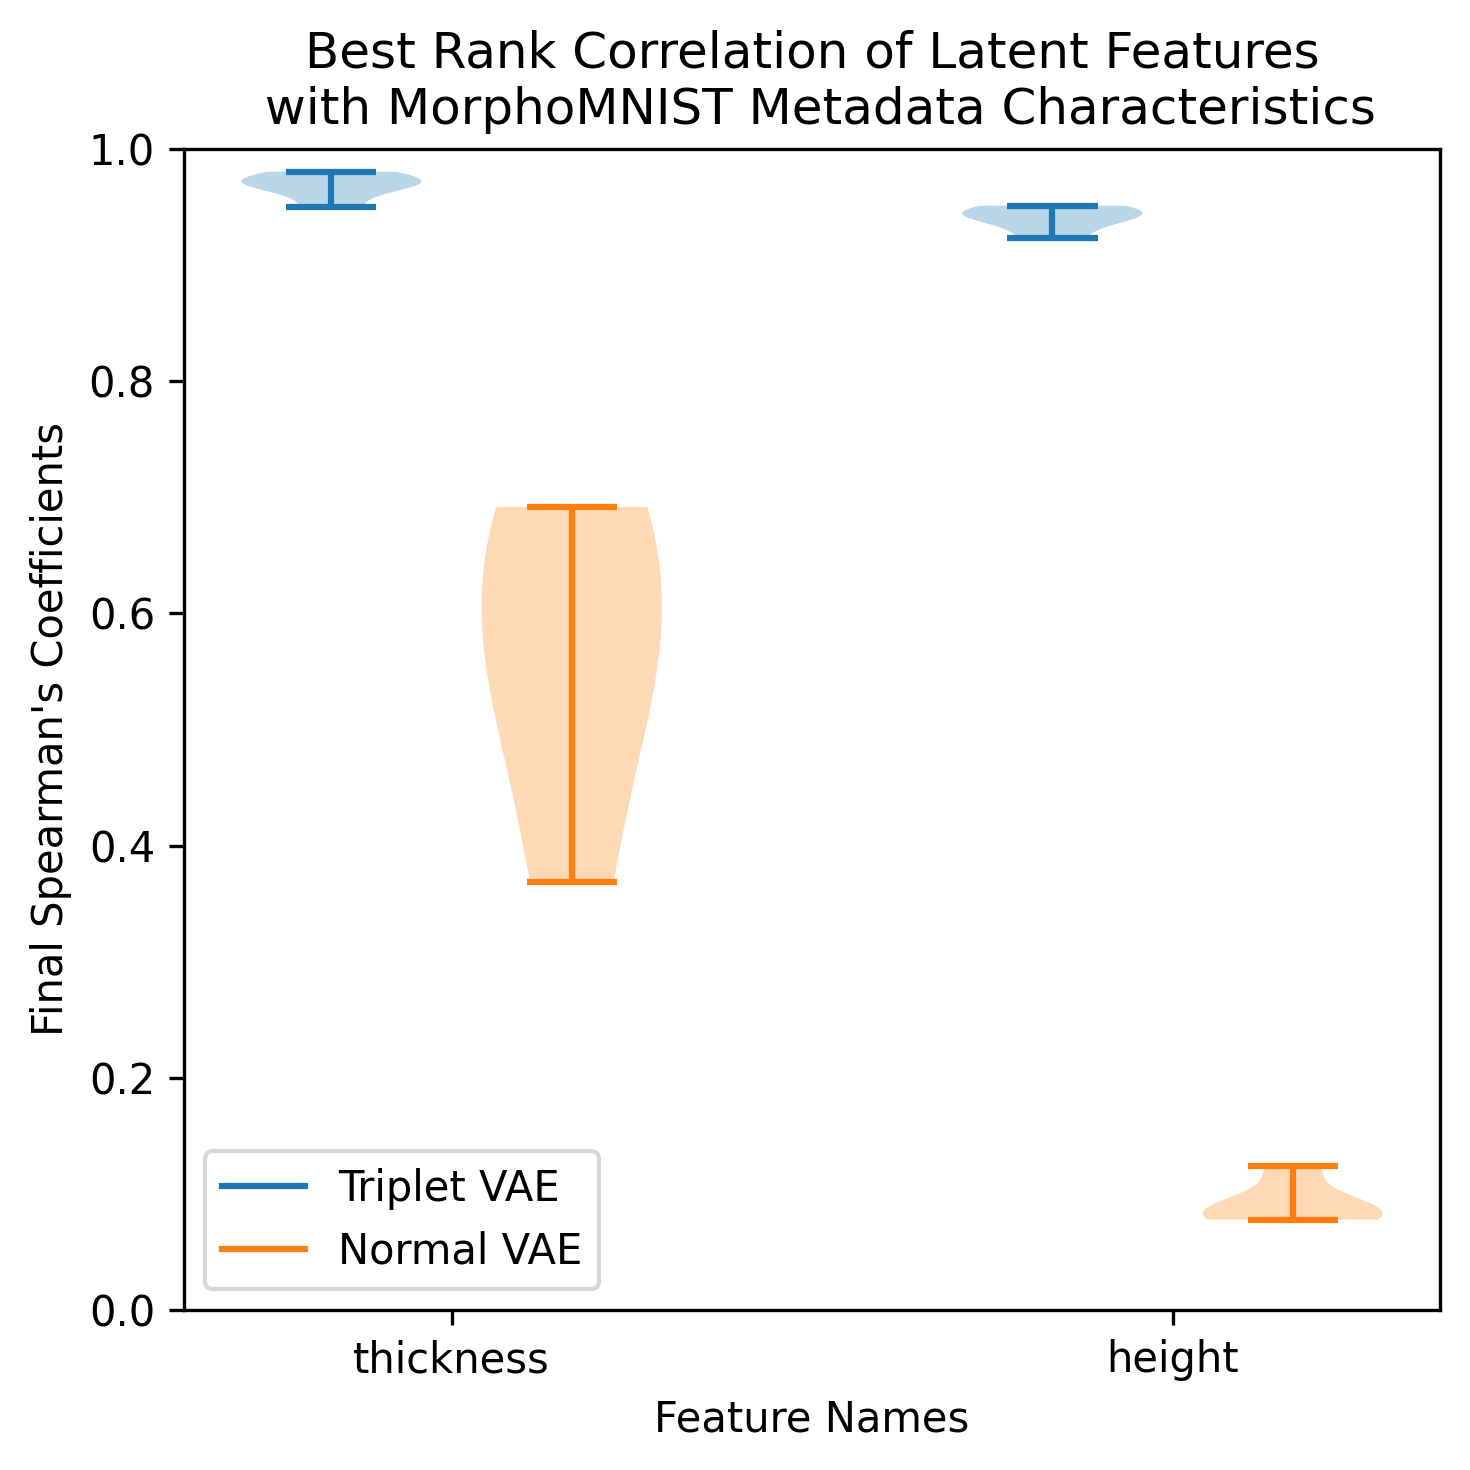

In [151]:
plot_final_rank_correlation_ablation(final_rank_correlations)

### Metadata error testing

In [11]:
loc_exp_man = LocalizationExperimentManager(localization_config=config["localization_config"])
localizer_configs = loc_exp_man.generate_configs()
num_trials = config["localization_config"]["trials"]
localization_plotting.save_localization_ablation(localizer_metrics, localizer_configs, "normalization", num_trials=num_trials)
plt.show()

KeyError: 'normalization'

[array([-6.7995005, -1.8744867], dtype=float32), array([-2.63132868, -1.06363462]), array([-2.21390699, -0.81434691]), array([-2.41385217, -0.87474695]), array([-2.25802149, -0.98716585]), array([-2.68608945, -1.08761188]), array([-2.13727568, -1.18671394]), array([-2.09112246, -0.95025542]), array([-1.18952858, -0.96969001]), array([-1.07340877, -0.94286639]), array([-1.50073574, -1.02522715]), array([-1.02945126, -1.31242249]), array([-1.00854322, -1.31388199]), array([-0.83606474, -1.45211166]), array([-0.95502069, -1.23760923]), array([-1.20600551, -0.98582872]), array([-0.94960995, -1.12321029]), array([-1.23408116, -1.19295334]), array([-0.8749312 , -1.14281879]), array([-1.08082958, -0.98665852]), array([-0.98781046, -1.27315374]), array([-1.07572837, -1.17414223]), array([-0.76329654, -1.09916615]), array([-1.07013108, -1.24893366]), array([-1.050448  , -1.15651017])]
(32, 32)
unnormalized metadata
Morphometrics(area=54.875, length=17.906854249492383, thickness=2.86935367462515

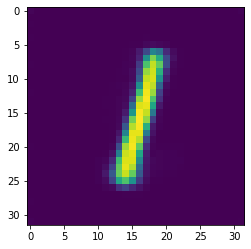

In [17]:
print(localizers[1].posterior_means)
img = model.decode(torch.Tensor(localizers[0].posterior_means[0])[None, :].cuda()).squeeze().detach().cpu().numpy()
plt.imshow(img)
print(img.shape)
metadata = data_manager.triplet_test.metadata_dataset.measure_images(img[None, :, :])
print(metadata)

In [9]:
print(dir(data_manager))
metadata_0 = data_manager.triplet_test.metadata_dataset[0]
print(metadata_0)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'batch_size', 'device', 'get_latent_point_training', 'image_test', 'image_test_loader', 'image_train', 'image_train_loader', 'setup_data_loaders', 'transform', 'triplet_test', 'triplet_test_loader', 'triplet_train', 'triplet_train_loader']
[0.28874735 0.29883527 0.25603096 0.74141134 0.13858003 0.92530424]


In [12]:
image_0 = data_manager.triplet_test.image_dataset[0]
metadata_of_image = data_manager.triplet_test.metadata_dataset.measure_images(image_0)
print(metadata_of_image)

unnormalized metadata
Morphometrics(area=66.1875, length=26.134776310850242, thickness=2.7436966973354373, slant=0.5068620883059122, width=5.332866686149806, height=19.69849731926733)
[[0.28789809 0.29883527 0.25536117 0.74133077 0.14074078 0.92772614]]


### Test metadata reconstruction


In [14]:
# load up a model
model_dir = "../../../logs/stellar-fog-7471"
print(os.listdir(model_dir))
model, config = load_model_and_config(model_dir)
data_manager = setup_data_manager(config)
# get a set of images
image_test = data_manager.image_test[0: 300]
image_test = image_test.permute(1, 0, 2, 3).cuda()
metadata_values = data_manager.triplet_test.metadata_dataset[0: 300]
# reconstruct the images
_, _, _, recon = model.forward(image_test)
recon = recon.detach().cpu().numpy().squeeze()
# calculate the metadata values of the reconstructed images
recon_metadata_values = data_manager.triplet_train.metadata_dataset.measure_images(recon)
# look at the differences for different metadata characteristics
differences = recon_metadata_values - metadata_values
print(np.mean(differences, axis=0))
# try and change the parallelogram mass fraction to see if that improves things

['model.pkl', 'params.pkl', 'localizers.pkl', 'localizer_metrics.pkl', 'loss.pkl']
Config object:
{'trials': 1, 'epochs': 50, 'lr': 0.001, 'batch_size': 512, 'trainer': 'triplet', 'group': 'global_mask_softmax_test', 'localization_config': {'indexed': False, 'trials': 5, 'k': 0.2, 'localizer_type': 'MCMV', 'num_queries': 25, 'similarity_mode': False}, 'model_config': {'d': 32, 'kl_max': 0, 'kl_beta': 0.01, 'channels': 1, 'in_shape': 32, 'loss_name': 'GlobalMaskVAETripletLoss', 'latent_dim': 2, 'model_type': 'BasicVAE', 'warm_start': 30, 'layer_count': 4, 'triplet_beta': 1, 'triplet_margin': 1, 'triplet_mining': False}, 'dataset_config': {'dataset_name': 'MorphoMNIST', 'component_weighting': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], 'localization_component_weighting': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], 'which_digits': [1], 'one_two_ratio': 0.0, 'batch_size': 512, 'apply_transform': True}}
unnormalized metadata
Morphometrics(area=39.125, length=19.528174593052025, thickness=2.0552139259019597, slant=

unnormalized metadata
Morphometrics(area=55.6875, length=18.94974746830583, thickness=2.9804931969862487, slant=-0.032863570604918846, width=5.798025562417319, height=18.823267499104418)
unnormalized metadata
Morphometrics(area=61.3125, length=16.742640687119284, thickness=3.285627880082851, slant=0.10879331994253406, width=5.49752490628091, height=18.85599324129518)
unnormalized metadata
Morphometrics(area=50.8125, length=17.82842712474619, thickness=2.8812058266683542, slant=-0.009749915825584555, width=5.669780611121627, height=18.836376805930012)
unnormalized metadata
Morphometrics(area=53.25, length=18.59619407771256, thickness=2.82448214963762, slant=0.12130428809390915, width=5.328071375251367, height=18.848291119018953)
unnormalized metadata
Morphometrics(area=53.3125, length=18.303300858899107, thickness=2.9383356363675275, slant=-0.0225687199802602, width=5.747791753122028, height=18.8221919275542)
unnormalized metadata
Morphometrics(area=72.0625, length=16.285533905932738, t

unnormalized metadata
Morphometrics(area=52.375, length=18.09619407771256, thickness=2.810901802003544, slant=-0.1368167776531473, width=5.768378390847882, height=18.80387484759636)
unnormalized metadata
Morphometrics(area=66.9375, length=21.331475451951135, thickness=3.1042282757817206, slant=0.44354408158241865, width=5.3853055448397384, height=18.84550165323208)
unnormalized metadata
Morphometrics(area=34.75, length=19.92462120245875, thickness=1.9056381174569645, slant=0.07819297094774845, width=6.324106041931696, height=19.049327957463834)
unnormalized metadata
Morphometrics(area=41.6875, length=16.889087296526014, thickness=2.376446165274179, slant=0.14487460170694874, width=6.590390454480911, height=18.929707029434127)
unnormalized metadata
Morphometrics(area=44.5625, length=17.510407640085653, thickness=2.468565425595668, slant=-0.19237676929351014, width=5.70069577863122, height=18.87418273226087)
unnormalized metadata
Morphometrics(area=46.5625, length=20.72792206135786, thic

unnormalized metadata
Morphometrics(area=45.0, length=18.760407640085656, thickness=2.446088613403171, slant=0.15652959838242048, width=5.323627082927157, height=18.88091410314584)
unnormalized metadata
Morphometrics(area=52.6875, length=16.26776695296637, thickness=3.0303742016856337, slant=0.003265478252789594, width=5.687078250139173, height=18.83476891707761)
unnormalized metadata
Morphometrics(area=37.8125, length=18.924621202458752, thickness=2.1007710647365285, slant=-0.06973920877961, width=5.759690628136264, height=18.946195594873124)
unnormalized metadata
Morphometrics(area=35.1875, length=17.742640687119287, thickness=2.0234984720753832, slant=-0.009949042930457076, width=6.530998475052167, height=19.006231412739773)
unnormalized metadata
Morphometrics(area=48.1875, length=18.217514421272206, thickness=2.638499076975575, slant=0.03861864393058205, width=5.594472423414496, height=18.84885516748392)
unnormalized metadata
Morphometrics(area=34.5625, length=19.192388155425117, t

unnormalized metadata
Morphometrics(area=52.75, length=16.699747468305834, thickness=2.8794302326222625, slant=-0.18623926003093158, width=5.866553542942617, height=18.773505405280392)
unnormalized metadata
Morphometrics(area=36.0625, length=20.003048327204944, thickness=1.9628309624107247, slant=0.02645130804514847, width=6.645163766214933, height=19.048259385945116)
unnormalized metadata
Morphometrics(area=78.75, length=19.028174593052025, thickness=3.8712022561526926, slant=0.25724600604289394, width=5.791607367771398, height=18.812281041391138)
unnormalized metadata
Morphometrics(area=53.125, length=19.449747468305834, thickness=2.8244877652485596, slant=-0.025214226217715952, width=5.74119516147946, height=18.822810162424894)
unnormalized metadata
Morphometrics(area=49.625, length=17.82842712474619, thickness=2.7883763693033736, slant=-0.04000386395539027, width=5.64287678354086, height=18.834729539091803)
unnormalized metadata
Morphometrics(area=44.6875, length=17.406854249492383

unnormalized metadata
Morphometrics(area=58.75, length=20.909902576697323, thickness=2.6808245947379805, slant=0.6082508764991379, width=5.934527382653712, height=18.58038776533853)
unnormalized metadata
Morphometrics(area=45.3125, length=19.61396103067893, thickness=2.41789295459616, slant=0.13441407713857134, width=5.381153924990933, height=18.880439567787334)
unnormalized metadata
Morphometrics(area=96.8125, length=18.97792206135786, thickness=4.435989222471848, slant=0.5203265871832663, width=6.641625762231207, height=18.783910082718204)
unnormalized metadata
Morphometrics(area=80.9375, length=20.25304832720494, thickness=3.8863209337386877, slant=0.3127991737236916, width=5.8452174084229505, height=18.841057636011264)
unnormalized metadata
Morphometrics(area=42.625, length=17.760407640085653, thickness=2.362262834792323, slant=0.19652588866438672, width=6.346372104200093, height=18.94088321034849)
unnormalized metadata
Morphometrics(area=53.5625, length=18.59619407771256, thicknes

unnormalized metadata
Morphometrics(area=49.0625, length=18.699747468305834, thickness=2.734256706884754, slant=-0.044450293501924795, width=5.626452977737184, height=18.83428027786204)
unnormalized metadata
Morphometrics(area=71.4375, length=18.86396103067893, thickness=3.586892121980901, slant=0.15442821560137748, width=5.589066463008768, height=18.84400113669781)
unnormalized metadata
Morphometrics(area=57.75, length=16.681980515339465, thickness=3.1847300357943835, slant=-0.029590423801804565, width=5.830573430611336, height=18.82524065541322)
unnormalized metadata
Morphometrics(area=48.375, length=18.967514421272206, thickness=2.4948109956610067, slant=0.08607030353985501, width=5.410152623356719, height=18.863942588649635)
unnormalized metadata
Morphometrics(area=83.5, length=18.3817279836453, thickness=4.195964080578467, slant=0.2948245759791634, width=5.944658868181531, height=18.82851841923506)
unnormalized metadata
Morphometrics(area=52.625, length=18.510407640085653, thickne

In [15]:

print(np.mean(differences, axis=0))

[-0.055138   -0.07919266 -0.00899061 -0.10475656  0.04650446 -0.08488292]


In [45]:
im_num = 0
#print(data_manager.image_test.indices)
image = data_manager.image_test[im_num].squeeze()
metadata = data_manager.triplet_train.metadata_dataset.measure_image(image)
print
#plt.imshow()
morpho_metadata = data_manager.triplet_test.metadata_dataset[im_num]
plt.show()
print(recon_metadata_values[im_num])
#plt.imshow(recon[im_num])
plt.show()

unnormalized metadata
Morphometrics(area=39.375, length=21.149494936611667, thickness=1.9390875132151943, slant=0.2911125601885791, width=3.1845005894374445, height=18.614396798503318)
[0.10403397 0.13704566 0.13296863 0.56978531 0.18362873 0.81139926]


In [46]:
morpho_metadata = np.array([39.375, 21.149494936611667, 1.9390875132151943, 0.2911125601885791, 3.1845005894374445, 18.614396798503318])
diff = np.array([39.3125,21.149494936611667,1.936092421219954,0.291222606814183,3.6622959758240725,19.570043233096122]) - morpho_metadata
print(diff)

[-6.25000000e-02  0.00000000e+00 -2.99509200e-03  1.10046626e-04
  4.77795386e-01  9.55646435e-01]
